In [1]:
# 사용할 모든 파일 리스트로 읽어오기
import os
import numpy as np
import pandas as pd
import math #math 모듈을 먼저 import해야 한다.    
import matplotlib.pyplot as plt

path = os.getcwd() # 모델 저장할 경로
read_path = path+"\\"+"전처리된파일\\" # 데이터 저장 경로
os_file_list = os.listdir(path+'\전처리된파일') # 사용할 파일


# 딕셔너리 안에 모든 데이터 프레임 저장
All_data = {}

for files in os_file_list:
    print(files)
    df= pd.read_csv(read_path+files, encoding = "cp949")
    All_data[files[:-4]] = df

key_list = list(All_data.keys())
data = All_data.copy()
key_list = list(set(key_list) - {"BTC_KRW","bin_data"})
key_list

bin_data.csv
BTC_KRW.csv
DXY.csv
KRW_CNY.csv
KRW_EUR.csv
KRW_USDT.csv
krx_100.csv
니케이 225.csv
독일.csv
미국금리.csv
중화인민공화국 상해종합.csv
코스피.csv
프랑스.csv
한국금리.csv


['KRW_USDT',
 'krx_100',
 '프랑스',
 '미국금리',
 '한국금리',
 '중화인민공화국 상해종합',
 'DXY',
 'KRW_EUR',
 'KRW_CNY',
 '독일',
 '니케이 225',
 '코스피']

KRW_USDT
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6139 entries, 0 to 6138
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    6139 non-null   object 
 1   Open    6139 non-null   float64
 2   High    6139 non-null   float64
 3   Low     6139 non-null   float64
 4   Close   6139 non-null   float64
dtypes: float64(4), object(1)
memory usage: 239.9+ KB
None
krx_100
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5326 entries, 0 to 5325
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    5326 non-null   object 
 1   Open    5326 non-null   float64
 2   High    5326 non-null   float64
 3   Low     5326 non-null   float64
 4   Close   5326 non-null   float64
dtypes: float64(4), object(1)
memory usage: 208.2+ KB
None
프랑스
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5882 entries, 0 to 5881
Data columns (total 5 columns):
 #   Column  Non-Null Cou

<Figure size 432x288 with 0 Axes>

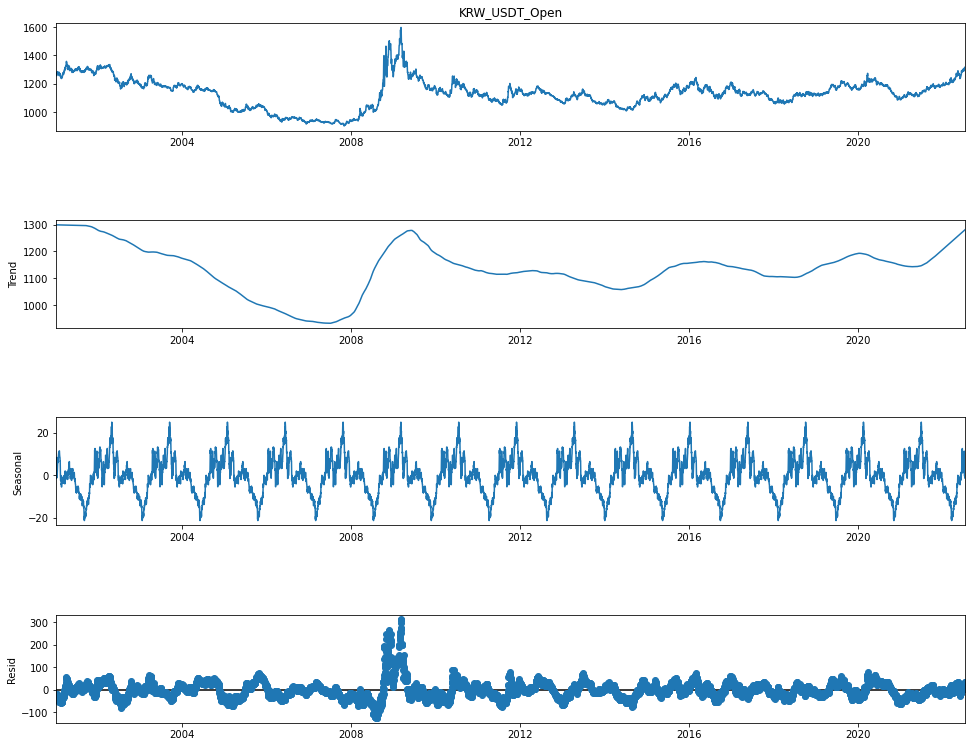

In [2]:
def For_LSTM_DATA(All_data,key_list):
    # All_data , key_list
    for i in range(len(key_list)):
        print(key_list[i])
        print(All_data[key_list[i]].info())
    #     All_data[key_list[i]] = All_data[key_list[i]]

    def set_index(df):
        df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d', errors='raise')
        df = df.set_index('time',drop=False)
        return df

    Use_data = {}
    # All_data , key_list
    for i in range(len(key_list)):
    #     print(key_list[i])
    #     print(All_data[key_list[i]].info())
        Use_data[key_list[i]] = All_data[key_list[i]].copy() # [["time","Open"]]
    #     All_data[key_list[i]] = All_data[key_list[i]]

    for i in range(len(key_list)):
        print(key_list[i],i)
        Use_data[key_list[i]] = set_index(Use_data[key_list[i]])

    # 기간 조정
    pariod_min_list = [Use_data[key_list[i]].index.min() for i in range(len(key_list)) ]
    pariod_max_list = [Use_data[key_list[i]].index.max() for i in range(len(key_list)) ]
    pariod_start = max(pariod_min_list)
    pariod_end = min(pariod_max_list)
    print("시작일 교집합 : ",pariod_start)
    print("최종일 교집합 : ",pariod_end)

    #날짜 조정.(모든 사용할 데이터들의 날짜를 같게 조정함.)
    for i in range(len(key_list)):
        Use_data[key_list[i]] = Use_data[key_list[i]].loc[Use_data[key_list[i]]["time"].between(pariod_start,pariod_end)]
    # 모든 컬럼명을 데이터 프레임 이름으로 바꿈
    for i in range(len(key_list)):
        col_list = list(Use_data[key_list[i]].columns)
        col_list = list(set(col_list) - {"time"})
        for j in range(len(col_list)):
            print(key_list[i]+"_"+col_list[j])
            Use_data[key_list[i]] = Use_data[key_list[i]].rename(columns={col_list[j]:key_list[i]+"_"+col_list[j]})

    ALL_DATA_BY_USE = pd.DataFrame()
    for i in range(len(key_list)):
    #     Use_data[key_list[i]]
        print(len(Use_data[key_list[i]]),key_list[i])
        if i == 0: # 처음시작만 @ 또는 가장 길이가 긴 값!!!!(날짜)
            ALL_DATA_BY_USE = Use_data[key_list[i]]
        else:
            ALL_DATA_BY_USE = pd.concat([ALL_DATA_BY_USE,Use_data[key_list[i]]],axis = 1)
    #     try:
    #         del ALL_DATA_BY_USE["time"]
    #     except:
    #         pass
    ALL_DATA_BY_USE = ALL_DATA_BY_USE.fillna(method="ffill")

    if (len(ALL_DATA_BY_USE) == len(ALL_DATA_BY_USE.drop_duplicates())): # 중복데이터가 더 없는지 확인
        pass
    else:
        print("길이가 다름")

    # try:
    #     del ALL_DATA_BY_USE["time"]
    # except:
    #     pass

    try:
        del ALL_DATA_BY_USE["time"]
    except:
        pass



    # 이렇게 설정하면 다음날 얼마나 오르고 내리는지 예측하게 됨.
    ALL_DATA_BY_USE["KRW_USDT_High - KRW_USDT_Open"] = ALL_DATA_BY_USE["KRW_USDT_High"] - ALL_DATA_BY_USE["KRW_USDT_Open"] # 변동성
    ALL_DATA_BY_USE["KRW_USDT_Open_shift_1"] = ALL_DATA_BY_USE[["KRW_USDT_Open"]].shift(-1) #다음날 시작가 데이터 까지 가지고 시작

    # 일단 다음날 시가를 예측해보자.!!
    use_columns = list(ALL_DATA_BY_USE.columns)
    print(use_columns)
    target = "KRW_USDT_Open"#"KRW_USDT_High - KRW_USDT_Open" # "KRW_USDT_Open"
    ALL_DATA_BY_USE = ALL_DATA_BY_USE.dropna()
    print(ALL_DATA_BY_USE[[target]])
    
    from statsmodels.tsa.seasonal import seasonal_decompose

    target_col = seasonal_decompose(ALL_DATA_BY_USE[target], model = 'additive' ,period = 500, extrapolate_trend = 1)

    fig = plt.figure()
    fig = target_col.plot()
    fig.set_size_inches(15,12)

    ALL_DATA_BY_USE[target+'col_trend'] = target_col.trend
    ALL_DATA_BY_USE[target+'col_seasonal'] = target_col.seasonal
    ALL_DATA_BY_USE[target+'col_resid'] = target_col.resid
    
    col_index = ['한국금리_Open', 'KRW_USDT_Open', 'KRW_USDT_High', 'KRW_USDT_Low',
           'KRW_USDT_Close', '미국금리_Open', 'KRW_CNY_Open', 'KRW_CNY_High',
           'KRW_CNY_Low', 'KRW_CNY_Close', 'krx_100_Open', 'krx_100_High',
           'krx_100_Low', 'krx_100_Close', '중화인민공화국 상해종합_Open',
           '중화인민공화국 상해종합_High', '중화인민공화국 상해종합_Low', '중화인민공화국 상해종합_Close',
           '프랑스_Open', '프랑스_High', '프랑스_Low', '프랑스_Close', '니케이 225_Open',
           '니케이 225_High', '니케이 225_Low', '니케이 225_Close', 'KRW_EUR_Open',
           'KRW_EUR_High', 'KRW_EUR_Low', 'KRW_EUR_Close', '독일_Open', '독일_High',
           '독일_Low', '독일_Close', '코스피_Open', '코스피_High', '코스피_Low', '코스피_Close',
           'DXY_Open', 'DXY_High', 'DXY_Low', 'DXY_Close',
           'KRW_USDT_High - KRW_USDT_Open', 'KRW_USDT_Open_shift_1',
           'KRW_USDT_Opencol_trend', 'KRW_USDT_Opencol_seasonal',
           'KRW_USDT_Opencol_resid']
    
    ALL_DATA_BY_USE = ALL_DATA_BY_USE[col_index]
    
    return ALL_DATA_BY_USE, target

ALL_DATA_BY_USE,target = For_LSTM_DATA(All_data,key_list)

## 만들어둔 LSTM 모델 불러오기

In [3]:
# X_data = ALL_DATA_BY_USE[list(set(use_columns) - {target})]
X_data = ALL_DATA_BY_USE
Y_data = ALL_DATA_BY_USE[[target]]
ALL_DATA_BY_USE = pd.concat([X_data,Y_data],axis = 1)

from sklearn.preprocessing import MinMaxScaler,PowerTransformer,LabelEncoder,StandardScaler

# 이부분 class로 변환할까? 나중에 정해진 범위까지만 데이터 스케일링 할 수도 있음.
# def MinMaxScaler_fun(df): #맞춤 변환 함수와 그에 맞는 데이터를 돌려줌
#     col = list(df.columns)
#     Scaler = MinMaxScaler()
#     Scaler.fit(df)
#     df = Scaler.transform(df)
# #     df = Scaler_X.fit_transform(df)
#     df = pd.DataFrame(df, columns = X_col)
#     return df, Scaler
# X_data ,Scaler = MinMaxScaler_fun(X_data)
# Y_data , Y_data_Scaler = MinMaxScaler_fun(Y_data)

X_col = list(X_data.columns)
Scaler = MinMaxScaler()
Scaler.fit(X_data)
X_data = Scaler.transform(X_data)
#     df = Scaler_X.fit_transform(df)
X_data = pd.DataFrame(X_data, columns = X_col)
    
# 최대최소 정규화
Y_col = list(Y_data.columns)

MAX_val = float(max(Y_data.values))
MIN_val = float(min(Y_data.values))
# 변환(man,max 변환을 또해주면 기존값을 잃어버림.)
Y_data[Y_col] = Y_data[Y_col].apply(lambda x : (x - MIN_val)/(MAX_val - MIN_val))
# 역변환
# Y_data[Y_col] = Y_data[Y_col].apply(lambda x : (x * (MAX_val - MIN_val) + MIN_val))

In [4]:
# 지정해야할 초기변수들 
WINDOW_SIZE=64 # 64 #1024 # n일간 데이터를 기반으로 내일 데이터 예측 
BATCH_SIZE=4 # 16 # 32
day_offset = 0 # 예측할 미래 날짜 day_offset = 0 이면 하루 뒤

In [5]:
def make_window_size_dataset(data, label, window_size, day_offset=0): # x값 , y값 , 윈도우 사이즈, 예측할 미래 날짜
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size - day_offset):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size + day_offset]))
    return np.array(feature_list), np.array(label_list)

x_WINDOW, y_WINDOW = make_window_size_dataset(X_data, Y_data, WINDOW_SIZE, day_offset)
x_WINDOW.shape,y_WINDOW.shape

((7804, 64, 47), (7804, 1))

In [6]:
a = math.floor(y_WINDOW.shape[0]*0.2)

y_train_WINDOW = y_WINDOW[:-a]
y_test_WINDOW = y_WINDOW[-a:]

x_train_WINDOW = x_WINDOW[:-a]
x_test_WINDOW = x_WINDOW[-a:]

In [7]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM, GRU
import keras

from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, LSTM, Dense

from keras.layers import Flatten
from keras.layers import Dropout
from tensorflow.keras import optimizers
from keras import layers
import tensorflow as tf
from keras import losses

elu = tf.nn.elu


model = keras.models.Sequential([
    keras.layers.Input(shape=(x_train_WINDOW.shape[1] , x_train_WINDOW.shape[2])),
    keras.layers.LSTM(1024, return_sequences=True, name='LSTM_0'),
    keras.layers.LSTM(512, return_sequences=True, name='LSTM_1'),
    keras.layers.LSTM(256, return_sequences=True, name='LSTM_2'),
    keras.layers.LSTM(128, return_sequences=True, name='LSTM_3'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation=elu),
    keras.layers.Dense(1, activation=elu)
#     keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss=Huber(), optimizer=Adam(0.000001), metrics=['mse']) #0.001이 기본 러닝 레이트


In [8]:
filename_2 = "USDT_LSTM_환율변동성예측.h5"
model.load_weights(filename_2) #저장된 최적 모델 불러옴 끄면 그냥 최종 모델 사용가능

196/196 [==============================] - 149s 746ms/step
(6244, 1) (6244, 1)


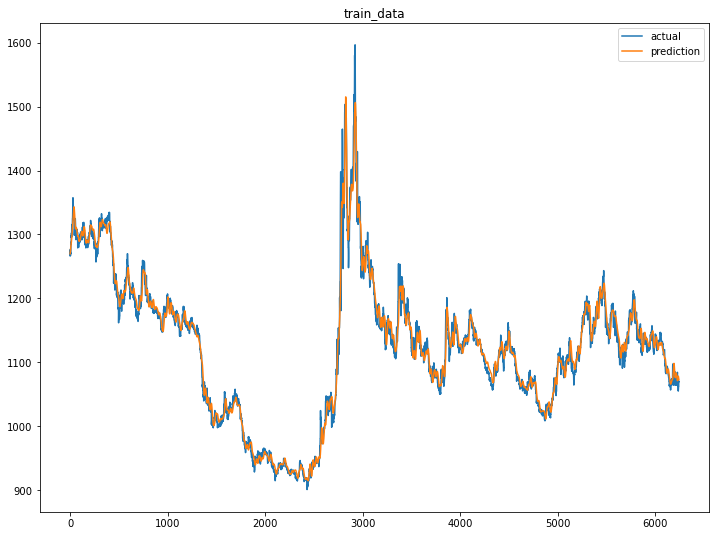

MSE 240.47097578649465
rmse = 15.507126612834973


In [17]:
pred = model.predict(x_train_WINDOW) #예측값(학습)
actual = np.asarray(y_train_WINDOW)

pred = pd.DataFrame(pred,columns = ["예측값"]).apply(lambda x : (x * (MAX_val - MIN_val) + MIN_val)) # 원래 값 복원
actual = pd.DataFrame(actual,columns = ["실제값"]).apply(lambda x : (x * (MAX_val - MIN_val) + MIN_val)) # 예측 값 복원

print(pred.shape, actual.shape)

i = 0
j = len(pred)

plt.figure(figsize=(12, 9))
plt.title('train_data')
plt.plot(actual[i:j], label='actual')
plt.plot(pred[i:j], label='prediction')
plt.legend()
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error
print("MSE",mean_squared_error(actual["실제값"],pred["예측값"]))
rmse = mean_squared_error(actual["실제값"],pred["예측값"], squared=False)
print("rmse = {}".format(rmse))

49/49 [==============================] - 37s 753ms/step
(1560, 1) (1560, 1)


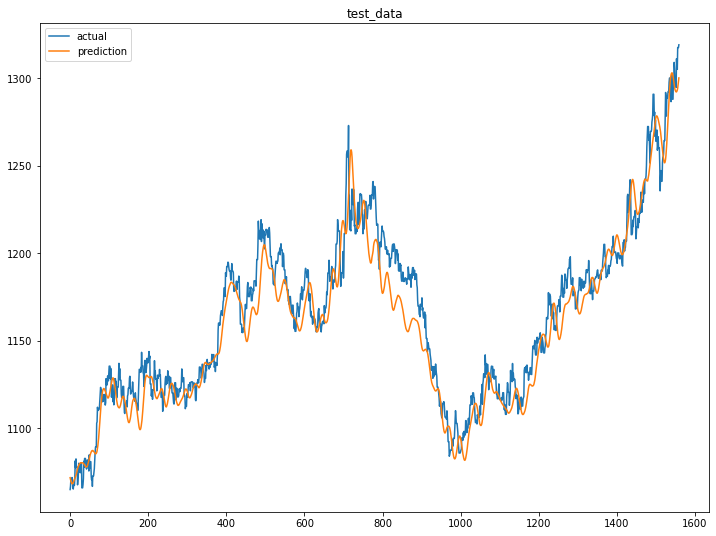

MSE 211.44346765277095
rmse = 14.54109582021833


In [18]:
pred = model.predict(x_test_WINDOW) #예측값(실제)
actual = np.asarray(y_test_WINDOW)

pred = pd.DataFrame(pred,columns = ["예측값"]).apply(lambda x : (x * (MAX_val - MIN_val) + MIN_val)) # 원래 값 복원
actual = pd.DataFrame(actual,columns = ["실제값"]).apply(lambda x : (x * (MAX_val - MIN_val) + MIN_val)) # 예측 값 복원

print(pred.shape, actual.shape)

i = 0
j = len(pred)

plt.figure(figsize=(12, 9))
plt.title('test_data')
plt.plot(actual[i:j], label='actual')
plt.plot(pred[i:j], label='prediction')
plt.legend()
plt.show()

from sklearn.metrics import mean_absolute_error, mean_squared_error
print("MSE",mean_squared_error(actual["실제값"],pred["예측값"]))
rmse = mean_squared_error(actual["실제값"],pred["예측값"], squared=False)
print("rmse = {}".format(rmse))

In [9]:
bin_data = data["bin_data"]
up_data = data["BTC_KRW"]
Usdt_data = data["KRW_USDT"]
####################
up_data = up_data.loc[~(up_data["Open"] == 0)]# 업비트 이상치 제거

data = pd.merge(up_data, Usdt_data, on = "time", how = "left")
data = pd.merge(data, bin_data, on = "time", how = "left") # 업비트 기준으로 맞는 잘짜 데이터끼리만 보여줌.
#################
def set_index(df):
    df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d', errors='raise')
    df = df.set_index('time',drop=True)
    return df

data = set_index(data)

data = pd.DataFrame({"날짜":data.index, 
                    "비트코인한국":data.Open_x.values,
                     "바이낸스USDT(달러)":data.Open.values,
                     "달러환율":data.Open_y.values,
                    })
data

,날짜,비트코인한국,바이낸스USDT(달러),달러환율
0,2017-09-26,4201000.0,3928.00,1134.80
1,2017-09-27,4317000.0,3882.36,1137.62
2,2017-09-28,4322000.0,4192.11,1145.75
3,2017-09-29,4657000.0,4178.98,1146.59
4,2017-09-30,4586000.0,4175.00,NaN
...,...,...,...,...
1755,2022-07-17,27496000.0,21195.60,NaN
1756,2022-07-18,27856000.0,20799.58,1319.15
1757,2022-07-19,27505000.0,22432.58,1319.20
1758,2022-07-20,29322000.0,23398.48,1305.80


In [10]:
#data["day_of_week"] = data["날짜"].dt.day_of_week
data["달러환율"] = data["달러환율"].fillna(method="ffill")
data = data.dropna() # 바이낸스 오늘 날짜 까지 안받아와졋을 경우에(업비트와 데이터 차이)
data.isna().sum()

날짜              0
비트코인한국          0
바이낸스USDT(달러)    0
달러환율            0
dtype: int64

In [11]:
# 9시인것을 다 뺴버려서 다시 맞추어줌.
data["날짜_2"] = [str(data["날짜"][i])[:-8]+"09:00" for i in range(len(data["날짜"]))]
data["날짜_2"] = pd.to_datetime(data['날짜_2'], format='%Y-%m-%d %H:%M', errors='raise')

# 서버 점검일 or 비트코인 전송 불가일
up_sutdown = [("2018-04-16 20:00", "2018-04-17 00:00"),
            ("2018-04-24 07:59", "2018-04-24 08:30"),
            ("2018-06-15 04:00", "2018-06-15 05:00"),
            ("2018-08-22 02:00", "2018-08-22 07:00"),
            ("2018-10-18 02:00", "2018-10-18 03:00"),
            ("2018-12-05 03:00", "2018-12-05 04:00"),
            ("2018-12-12 03:00", "2018-12-12 04:00"),
            ("2019-01-01 01:00", "2019-01-01 03:00"),
            ("2019-03-20 02:00", "2019-03-20 06:00"),
            ("2019-03-24 03:00", "2019-03-24 04:00"),
            ("2020-01-31 02:00", "2020-01-31 05:00"),
            ("2021-01-07 05:00", "2021-01-07 06:00"),
            ("2021-03-03 03:30", "2021-03-03 06:30"),
            ("2021-03-14 03:00", "2021-03-14 06:00"),
            ("2021-03-23 03:00", "2021-03-23 06:00"),
            ("2021-06-30 23:00", "2021-07-01 03:00"),
            ("2019-10-17 21:00", "2019-10-18 13:00"),
            ("2019-04-10 21:50", "2019-04-17 02:00"),
            ("2019-12-12 23:55", "2019-12-13 03:00"),
            ("2019-12-15 00:00", "2019-12-15 01:00"),
            ("2020-12-29 01:30", "2020-12-29 02:25"),
            ("2020-12-30 19:01", "2021-01-01 05:02"),
            ("2021-06-29 21:01", "2021-07-01 04:51"),
#             ("2001-01-02" , "2018-04-10"), # trian 기간 제외
            ("2022-07-19" , "2022-08-02") # LSTM데이터 셋과 타임테이블 맞춤
             ]
# 서버 점검일이 아닌 날짜만 받기
for i in range(len(up_sutdown)):
    data = data.loc[~(data["날짜_2"].between(up_sutdown[i][0],up_sutdown[i][1]))]


In [12]:
# 예측값 컬럼별로 넣기.

ALL_DATA_BY_USE["time"] = ALL_DATA_BY_USE.index
ALL_DATA_BY_USE = ALL_DATA_BY_USE.reset_index(drop = True)


In [13]:
ALL_DATA_BY_USE["time"].values

array(['2001-01-02T00:00:00.000000000', '2001-01-03T00:00:00.000000000',
       '2001-01-04T00:00:00.000000000', ...,
       '2022-07-16T00:00:00.000000000', '2022-07-17T00:00:00.000000000',
       '2022-07-18T00:00:00.000000000'], dtype='datetime64[ns]')

In [15]:
data

,날짜,비트코인한국,바이낸스USDT(달러),달러환율,날짜_2
0,2017-09-26,4201000.0,3928.00,1134.80,2017-09-26 09:00:00
1,2017-09-27,4317000.0,3882.36,1137.62,2017-09-27 09:00:00
2,2017-09-28,4322000.0,4192.11,1145.75,2017-09-28 09:00:00
3,2017-09-29,4657000.0,4178.98,1146.59,2017-09-29 09:00:00
4,2017-09-30,4586000.0,4175.00,1146.59,2017-09-30 09:00:00
...,...,...,...,...,...
1752,2022-07-14,25723000.0,20234.87,1305.10,2022-07-14 09:00:00
1753,2022-07-15,26604000.0,20588.84,1317.57,2022-07-15 09:00:00
1754,2022-07-16,27140000.0,20830.04,1317.57,2022-07-16 09:00:00
1755,2022-07-17,27496000.0,21195.60,1317.57,2022-07-17 09:00:00


In [23]:
# LSTM 웬만함녀 데이터 불러오기
def inverse_transform_(x):
    x = x * (MAX_val - MIN_val) + MIN_val
    return x

from tqdm import tqdm
vals = []

for i in tqdm(range(len(data))):
    # data 셋의 날짜와 LSTM에서 쓸 값의 날짜의 인덱스를 맞추어가져롬. 그리고 해당 날짜에 맞게 데이터 집어넣음.
    idx = list(ALL_DATA_BY_USE["time"].values).index(data["날짜"].iloc[i]) + 1 # +1 은 ALL_DATA_BY_USE의 컬럼이 0부터 시작하기 떄문
    a = model.predict(x_WINDOW[idx-WINDOW_SIZE-1:idx-WINDOW_SIZE]) 
    a = inverse_transform_(a)
    vals.append(float(a))
    
data["LSTM예측값"] = vals # 빠진날도 있어서 이렇게 해야함..



  0%|                                                                                         | 0/1748 [00:00<?, ?it/s]

1/1 [==============================] - 0s 214ms/step


  0%|                                                                                 | 1/1748 [00:00<07:56,  3.67it/s]

1/1 [==============================] - 0s 193ms/step


  0%|                                                                                 | 2/1748 [00:00<08:04,  3.60it/s]

1/1 [==============================] - 0s 245ms/step


  0%|▏                                                                                | 3/1748 [00:00<08:45,  3.32it/s]

1/1 [==============================] - 0s 200ms/step


  0%|▏                                                                                | 4/1748 [00:01<08:35,  3.38it/s]

1/1 [==============================] - 0s 228ms/step


  0%|▏                                                                                | 5/1748 [00:01<08:26,  3.44it/s]

1/1 [==============================] - 0s 230ms/step


  0%|▎                                                                                | 6/1748 [00:01<08:24,  3.45it/s]

1/1 [==============================] - 0s 231ms/step


  0%|▎                                                                                | 7/1748 [00:02<08:55,  3.25it/s]

1/1 [==============================] - 0s 296ms/step


  0%|▎                                                                                | 8/1748 [00:02<09:32,  3.04it/s]

1/1 [==============================] - 0s 237ms/step


  1%|▍                                                                                | 9/1748 [00:02<09:16,  3.12it/s]

1/1 [==============================] - 0s 247ms/step


  1%|▍                                                                               | 10/1748 [00:03<09:31,  3.04it/s]

1/1 [==============================] - 0s 270ms/step


  1%|▌                                                                               | 11/1748 [00:03<09:54,  2.92it/s]

1/1 [==============================] - 0s 311ms/step


  1%|▌                                                                               | 12/1748 [00:03<10:12,  2.83it/s]

1/1 [==============================] - 0s 321ms/step


  1%|▌                                                                               | 13/1748 [00:04<10:48,  2.68it/s]

1/1 [==============================] - 0s 230ms/step


  1%|▋                                                                               | 14/1748 [00:04<10:19,  2.80it/s]

1/1 [==============================] - 0s 177ms/step


  1%|▋                                                                               | 15/1748 [00:04<09:17,  3.11it/s]

1/1 [==============================] - 0s 225ms/step


  1%|▋                                                                               | 16/1748 [00:05<08:55,  3.24it/s]

1/1 [==============================] - 0s 157ms/step


  1%|▊                                                                               | 17/1748 [00:05<08:08,  3.54it/s]

1/1 [==============================] - 0s 159ms/step


  1%|▊                                                                               | 18/1748 [00:05<07:35,  3.80it/s]

1/1 [==============================] - 0s 215ms/step


  1%|▊                                                                               | 19/1748 [00:05<07:39,  3.76it/s]

1/1 [==============================] - 0s 182ms/step


  1%|▉                                                                               | 20/1748 [00:06<07:32,  3.82it/s]

1/1 [==============================] - 0s 185ms/step


  1%|▉                                                                               | 21/1748 [00:06<07:19,  3.93it/s]

1/1 [==============================] - 0s 165ms/step


  1%|█                                                                               | 22/1748 [00:06<07:06,  4.04it/s]

1/1 [==============================] - 0s 156ms/step


  1%|█                                                                               | 23/1748 [00:06<06:45,  4.25it/s]

1/1 [==============================] - 0s 214ms/step


  1%|█                                                                               | 24/1748 [00:07<07:01,  4.09it/s]

1/1 [==============================] - 0s 153ms/step


  1%|█▏                                                                              | 25/1748 [00:07<06:41,  4.29it/s]

1/1 [==============================] - 0s 205ms/step


  1%|█▏                                                                              | 26/1748 [00:07<06:53,  4.17it/s]

1/1 [==============================] - 0s 171ms/step


  2%|█▏                                                                              | 27/1748 [00:07<06:49,  4.21it/s]

1/1 [==============================] - 0s 195ms/step


  2%|█▎                                                                              | 28/1748 [00:07<06:52,  4.17it/s]

1/1 [==============================] - 0s 159ms/step


  2%|█▎                                                                              | 29/1748 [00:08<06:39,  4.30it/s]

1/1 [==============================] - 0s 167ms/step


  2%|█▎                                                                              | 30/1748 [00:08<06:33,  4.37it/s]

1/1 [==============================] - 0s 157ms/step


  2%|█▍                                                                              | 31/1748 [00:08<06:22,  4.49it/s]

1/1 [==============================] - 0s 177ms/step


  2%|█▍                                                                              | 32/1748 [00:08<06:25,  4.45it/s]

1/1 [==============================] - 0s 173ms/step


  2%|█▌                                                                              | 33/1748 [00:09<06:29,  4.40it/s]

1/1 [==============================] - 0s 205ms/step


  2%|█▌                                                                              | 34/1748 [00:09<06:44,  4.24it/s]

1/1 [==============================] - 0s 161ms/step


  2%|█▌                                                                              | 35/1748 [00:09<06:41,  4.27it/s]

1/1 [==============================] - 0s 162ms/step


  2%|█▋                                                                              | 36/1748 [00:09<06:32,  4.37it/s]

1/1 [==============================] - 0s 188ms/step


  2%|█▋                                                                              | 37/1748 [00:10<06:42,  4.26it/s]

1/1 [==============================] - 0s 161ms/step


  2%|█▋                                                                              | 38/1748 [00:10<06:29,  4.39it/s]

1/1 [==============================] - 0s 158ms/step


  2%|█▊                                                                              | 39/1748 [00:10<06:20,  4.50it/s]

1/1 [==============================] - 0s 176ms/step


  2%|█▊                                                                              | 40/1748 [00:10<06:28,  4.40it/s]

1/1 [==============================] - 0s 220ms/step


  2%|█▉                                                                              | 41/1748 [00:10<06:51,  4.15it/s]

1/1 [==============================] - 0s 160ms/step


  2%|█▉                                                                              | 42/1748 [00:11<06:40,  4.26it/s]

1/1 [==============================] - 0s 167ms/step


  2%|█▉                                                                              | 43/1748 [00:11<06:31,  4.35it/s]

1/1 [==============================] - 0s 165ms/step


  3%|██                                                                              | 44/1748 [00:11<06:26,  4.40it/s]

1/1 [==============================] - 0s 154ms/step


  3%|██                                                                              | 45/1748 [00:11<06:16,  4.53it/s]

1/1 [==============================] - 0s 202ms/step


  3%|██                                                                              | 46/1748 [00:12<06:33,  4.32it/s]

1/1 [==============================] - 0s 150ms/step


  3%|██▏                                                                             | 47/1748 [00:12<06:18,  4.50it/s]

1/1 [==============================] - 0s 153ms/step


  3%|██▏                                                                             | 48/1748 [00:12<06:10,  4.59it/s]

1/1 [==============================] - 0s 157ms/step


  3%|██▏                                                                             | 49/1748 [00:12<06:04,  4.66it/s]

1/1 [==============================] - 0s 238ms/step


  3%|██▎                                                                             | 50/1748 [00:12<06:43,  4.21it/s]

1/1 [==============================] - 0s 160ms/step


  3%|██▎                                                                             | 51/1748 [00:13<06:33,  4.31it/s]

1/1 [==============================] - 0s 166ms/step


  3%|██▍                                                                             | 52/1748 [00:13<06:26,  4.39it/s]

1/1 [==============================] - 0s 175ms/step


  3%|██▍                                                                             | 53/1748 [00:13<06:25,  4.39it/s]

1/1 [==============================] - 0s 158ms/step


  3%|██▍                                                                             | 54/1748 [00:13<06:18,  4.48it/s]

1/1 [==============================] - 0s 255ms/step


  3%|██▌                                                                             | 55/1748 [00:14<07:07,  3.96it/s]

1/1 [==============================] - 0s 202ms/step


  3%|██▌                                                                             | 56/1748 [00:14<07:16,  3.87it/s]

1/1 [==============================] - 0s 155ms/step


  3%|██▌                                                                             | 57/1748 [00:14<06:51,  4.11it/s]

1/1 [==============================] - 0s 153ms/step


  3%|██▋                                                                             | 58/1748 [00:14<06:31,  4.31it/s]

1/1 [==============================] - 0s 210ms/step


  3%|██▋                                                                             | 59/1748 [00:15<06:46,  4.16it/s]

1/1 [==============================] - 0s 159ms/step


  3%|██▋                                                                             | 60/1748 [00:15<06:35,  4.26it/s]

1/1 [==============================] - 0s 180ms/step


  3%|██▊                                                                             | 61/1748 [00:15<06:45,  4.16it/s]

1/1 [==============================] - 0s 155ms/step


  4%|██▊                                                                             | 62/1748 [00:15<06:28,  4.34it/s]

1/1 [==============================] - 0s 237ms/step


  4%|██▉                                                                             | 63/1748 [00:16<07:01,  4.00it/s]

1/1 [==============================] - 0s 256ms/step


  4%|██▉                                                                             | 64/1748 [00:16<07:50,  3.58it/s]

1/1 [==============================] - 0s 253ms/step


  4%|██▉                                                                             | 65/1748 [00:16<08:08,  3.45it/s]

1/1 [==============================] - 0s 183ms/step


  4%|███                                                                             | 66/1748 [00:17<07:46,  3.61it/s]

1/1 [==============================] - 0s 185ms/step


  4%|███                                                                             | 67/1748 [00:17<07:28,  3.75it/s]

1/1 [==============================] - 0s 164ms/step


  4%|███                                                                             | 68/1748 [00:17<07:04,  3.96it/s]

1/1 [==============================] - 0s 180ms/step


  4%|███▏                                                                            | 69/1748 [00:17<06:56,  4.04it/s]

1/1 [==============================] - 0s 170ms/step


  4%|███▏                                                                            | 70/1748 [00:17<06:43,  4.16it/s]

1/1 [==============================] - 0s 169ms/step


  4%|███▏                                                                            | 71/1748 [00:18<06:37,  4.22it/s]

1/1 [==============================] - 0s 184ms/step


  4%|███▎                                                                            | 72/1748 [00:18<06:43,  4.15it/s]

1/1 [==============================] - 0s 162ms/step


  4%|███▎                                                                            | 73/1748 [00:18<06:36,  4.22it/s]

1/1 [==============================] - 0s 164ms/step


  4%|███▍                                                                            | 74/1748 [00:18<06:31,  4.27it/s]

1/1 [==============================] - 0s 166ms/step


  4%|███▍                                                                            | 75/1748 [00:19<06:29,  4.30it/s]

1/1 [==============================] - 0s 163ms/step


  4%|███▍                                                                            | 76/1748 [00:19<06:19,  4.41it/s]

1/1 [==============================] - 0s 159ms/step


  4%|███▌                                                                            | 77/1748 [00:19<06:11,  4.50it/s]

1/1 [==============================] - 0s 155ms/step


  4%|███▌                                                                            | 78/1748 [00:19<06:03,  4.59it/s]

1/1 [==============================] - 0s 156ms/step


  5%|███▌                                                                            | 79/1748 [00:19<05:57,  4.67it/s]

1/1 [==============================] - 0s 155ms/step


  5%|███▋                                                                            | 80/1748 [00:20<05:54,  4.71it/s]

1/1 [==============================] - 0s 158ms/step


  5%|███▋                                                                            | 81/1748 [00:20<05:58,  4.64it/s]

1/1 [==============================] - 0s 199ms/step


  5%|███▊                                                                            | 82/1748 [00:20<06:16,  4.42it/s]

1/1 [==============================] - 0s 177ms/step


  5%|███▊                                                                            | 83/1748 [00:20<06:36,  4.20it/s]

1/1 [==============================] - 0s 212ms/step


  5%|███▊                                                                            | 84/1748 [00:21<07:01,  3.95it/s]

1/1 [==============================] - 0s 235ms/step


  5%|███▉                                                                            | 85/1748 [00:21<07:34,  3.66it/s]

1/1 [==============================] - 0s 205ms/step


  5%|███▉                                                                            | 86/1748 [00:21<07:32,  3.68it/s]

1/1 [==============================] - 0s 225ms/step


  5%|███▉                                                                            | 87/1748 [00:22<07:41,  3.60it/s]

1/1 [==============================] - 0s 203ms/step


  5%|████                                                                            | 88/1748 [00:22<07:35,  3.64it/s]

1/1 [==============================] - 0s 239ms/step


  5%|████                                                                            | 89/1748 [00:22<07:59,  3.46it/s]

1/1 [==============================] - 0s 195ms/step


  5%|████                                                                            | 90/1748 [00:22<07:43,  3.57it/s]

1/1 [==============================] - 0s 167ms/step


  5%|████▏                                                                           | 91/1748 [00:23<07:16,  3.80it/s]

1/1 [==============================] - 0s 164ms/step


  5%|████▏                                                                           | 92/1748 [00:23<07:05,  3.89it/s]

1/1 [==============================] - 0s 216ms/step


  5%|████▎                                                                           | 93/1748 [00:23<07:14,  3.81it/s]

1/1 [==============================] - 0s 165ms/step


  5%|████▎                                                                           | 94/1748 [00:23<06:51,  4.02it/s]

1/1 [==============================] - 0s 216ms/step


  5%|████▎                                                                           | 95/1748 [00:24<07:17,  3.77it/s]

1/1 [==============================] - 0s 231ms/step


  5%|████▍                                                                           | 96/1748 [00:24<07:43,  3.57it/s]

1/1 [==============================] - 0s 177ms/step


  6%|████▍                                                                           | 97/1748 [00:24<07:20,  3.75it/s]

1/1 [==============================] - 0s 187ms/step


  6%|████▍                                                                           | 98/1748 [00:24<07:11,  3.82it/s]

1/1 [==============================] - 0s 159ms/step


  6%|████▌                                                                           | 99/1748 [00:25<06:52,  4.00it/s]

1/1 [==============================] - 0s 245ms/step


  6%|████▌                                                                          | 100/1748 [00:25<07:15,  3.78it/s]

1/1 [==============================] - 0s 171ms/step


  6%|████▌                                                                          | 101/1748 [00:25<06:58,  3.94it/s]

1/1 [==============================] - 0s 205ms/step


  6%|████▌                                                                          | 102/1748 [00:25<07:05,  3.87it/s]

1/1 [==============================] - 0s 194ms/step


  6%|████▋                                                                          | 103/1748 [00:26<07:00,  3.91it/s]

1/1 [==============================] - 0s 215ms/step


  6%|████▋                                                                          | 104/1748 [00:26<07:10,  3.82it/s]

1/1 [==============================] - 0s 171ms/step


  6%|████▋                                                                          | 105/1748 [00:26<06:59,  3.92it/s]

1/1 [==============================] - 0s 198ms/step


  6%|████▊                                                                          | 106/1748 [00:26<06:58,  3.93it/s]

1/1 [==============================] - 0s 187ms/step


  6%|████▊                                                                          | 107/1748 [00:27<06:55,  3.95it/s]

1/1 [==============================] - 0s 171ms/step


  6%|████▉                                                                          | 108/1748 [00:27<06:41,  4.09it/s]

1/1 [==============================] - 0s 195ms/step


  6%|████▉                                                                          | 109/1748 [00:27<06:49,  4.00it/s]

1/1 [==============================] - 0s 192ms/step


  6%|████▉                                                                          | 110/1748 [00:27<06:55,  3.94it/s]

1/1 [==============================] - 0s 162ms/step


  6%|█████                                                                          | 111/1748 [00:28<06:36,  4.13it/s]

1/1 [==============================] - 0s 182ms/step


  6%|█████                                                                          | 112/1748 [00:28<06:32,  4.17it/s]

1/1 [==============================] - 0s 179ms/step


  6%|█████                                                                          | 113/1748 [00:28<06:29,  4.20it/s]

1/1 [==============================] - 0s 155ms/step


  7%|█████▏                                                                         | 114/1748 [00:28<06:14,  4.37it/s]

1/1 [==============================] - 0s 194ms/step


  7%|█████▏                                                                         | 115/1748 [00:29<06:26,  4.22it/s]

1/1 [==============================] - 0s 165ms/step


  7%|█████▏                                                                         | 116/1748 [00:29<06:25,  4.24it/s]

1/1 [==============================] - 0s 156ms/step


  7%|█████▎                                                                         | 117/1748 [00:29<06:11,  4.39it/s]

1/1 [==============================] - 0s 219ms/step


  7%|█████▎                                                                         | 118/1748 [00:29<06:38,  4.10it/s]

1/1 [==============================] - 0s 167ms/step


  7%|█████▍                                                                         | 119/1748 [00:30<06:42,  4.04it/s]

1/1 [==============================] - 0s 173ms/step


  7%|█████▍                                                                         | 120/1748 [00:30<06:32,  4.15it/s]

1/1 [==============================] - 0s 165ms/step


  7%|█████▍                                                                         | 121/1748 [00:30<06:20,  4.28it/s]

1/1 [==============================] - 0s 187ms/step


  7%|█████▌                                                                         | 122/1748 [00:30<06:23,  4.24it/s]

1/1 [==============================] - 0s 175ms/step


  7%|█████▌                                                                         | 123/1748 [00:31<06:22,  4.25it/s]

1/1 [==============================] - 0s 159ms/step


  7%|█████▌                                                                         | 124/1748 [00:31<06:10,  4.38it/s]

1/1 [==============================] - 0s 169ms/step


  7%|█████▋                                                                         | 125/1748 [00:31<06:07,  4.42it/s]

1/1 [==============================] - 0s 163ms/step


  7%|█████▋                                                                         | 126/1748 [00:31<06:02,  4.48it/s]

1/1 [==============================] - 0s 165ms/step


  7%|█████▋                                                                         | 127/1748 [00:31<05:58,  4.52it/s]

1/1 [==============================] - 0s 169ms/step


  7%|█████▊                                                                         | 128/1748 [00:32<05:57,  4.53it/s]

1/1 [==============================] - 0s 161ms/step


  7%|█████▊                                                                         | 129/1748 [00:32<05:56,  4.54it/s]

1/1 [==============================] - 0s 155ms/step


  7%|█████▉                                                                         | 130/1748 [00:32<05:49,  4.62it/s]

1/1 [==============================] - 0s 171ms/step


  7%|█████▉                                                                         | 131/1748 [00:32<05:53,  4.57it/s]

1/1 [==============================] - 0s 154ms/step


  8%|█████▉                                                                         | 132/1748 [00:32<05:48,  4.64it/s]

1/1 [==============================] - 0s 156ms/step


  8%|██████                                                                         | 133/1748 [00:33<05:44,  4.69it/s]

1/1 [==============================] - 0s 158ms/step


  8%|██████                                                                         | 134/1748 [00:33<05:45,  4.67it/s]

1/1 [==============================] - 0s 151ms/step


  8%|██████                                                                         | 135/1748 [00:33<05:41,  4.72it/s]

1/1 [==============================] - 0s 201ms/step


  8%|██████▏                                                                        | 136/1748 [00:33<06:06,  4.40it/s]

1/1 [==============================] - 0s 200ms/step


  8%|██████▏                                                                        | 137/1748 [00:34<06:18,  4.26it/s]

1/1 [==============================] - 0s 193ms/step


  8%|██████▏                                                                        | 138/1748 [00:34<06:30,  4.13it/s]

1/1 [==============================] - 0s 165ms/step


  8%|██████▎                                                                        | 139/1748 [00:34<06:20,  4.23it/s]

1/1 [==============================] - 0s 184ms/step


  8%|██████▎                                                                        | 140/1748 [00:34<06:26,  4.16it/s]

1/1 [==============================] - 0s 212ms/step


  8%|██████▎                                                                        | 141/1748 [00:35<06:39,  4.02it/s]

1/1 [==============================] - 0s 222ms/step


  8%|██████▍                                                                        | 142/1748 [00:35<06:53,  3.88it/s]

1/1 [==============================] - 0s 217ms/step


  8%|██████▍                                                                        | 143/1748 [00:35<06:59,  3.83it/s]

1/1 [==============================] - 0s 163ms/step


  8%|██████▌                                                                        | 144/1748 [00:35<06:39,  4.01it/s]

1/1 [==============================] - 0s 241ms/step


  8%|██████▌                                                                        | 145/1748 [00:36<07:04,  3.78it/s]

1/1 [==============================] - 0s 241ms/step


  8%|██████▌                                                                        | 146/1748 [00:36<07:22,  3.62it/s]

1/1 [==============================] - 0s 205ms/step


  8%|██████▋                                                                        | 147/1748 [00:36<07:16,  3.67it/s]

1/1 [==============================] - 0s 152ms/step


  8%|██████▋                                                                        | 148/1748 [00:37<06:58,  3.83it/s]

1/1 [==============================] - 0s 209ms/step


  9%|██████▋                                                                        | 149/1748 [00:37<06:59,  3.81it/s]

1/1 [==============================] - 0s 190ms/step


  9%|██████▊                                                                        | 150/1748 [00:37<06:53,  3.86it/s]

1/1 [==============================] - 0s 238ms/step


  9%|██████▊                                                                        | 151/1748 [00:37<07:09,  3.72it/s]

1/1 [==============================] - 0s 151ms/step


  9%|██████▊                                                                        | 152/1748 [00:38<06:43,  3.96it/s]

1/1 [==============================] - 0s 244ms/step


  9%|██████▉                                                                        | 153/1748 [00:38<07:08,  3.73it/s]

1/1 [==============================] - 0s 154ms/step


  9%|██████▉                                                                        | 154/1748 [00:38<06:38,  4.00it/s]

1/1 [==============================] - 0s 206ms/step


  9%|███████                                                                        | 155/1748 [00:38<06:50,  3.88it/s]

1/1 [==============================] - 0s 154ms/step


  9%|███████                                                                        | 156/1748 [00:39<06:26,  4.12it/s]

1/1 [==============================] - 0s 244ms/step


  9%|███████                                                                        | 157/1748 [00:39<06:56,  3.82it/s]

1/1 [==============================] - 0s 239ms/step


  9%|███████▏                                                                       | 158/1748 [00:39<07:13,  3.67it/s]

1/1 [==============================] - 0s 218ms/step


  9%|███████▏                                                                       | 159/1748 [00:39<07:18,  3.63it/s]

1/1 [==============================] - 0s 203ms/step


  9%|███████▏                                                                       | 160/1748 [00:40<07:08,  3.71it/s]

1/1 [==============================] - 0s 232ms/step


  9%|███████▎                                                                       | 161/1748 [00:40<07:19,  3.61it/s]

1/1 [==============================] - 0s 198ms/step


  9%|███████▎                                                                       | 162/1748 [00:40<09:01,  2.93it/s]

1/1 [==============================] - 0s 202ms/step


  9%|███████▎                                                                       | 163/1748 [00:41<08:23,  3.15it/s]

1/1 [==============================] - 0s 173ms/step


  9%|███████▍                                                                       | 164/1748 [00:41<07:38,  3.45it/s]

1/1 [==============================] - 0s 169ms/step


  9%|███████▍                                                                       | 165/1748 [00:41<07:06,  3.71it/s]

1/1 [==============================] - 0s 230ms/step


  9%|███████▌                                                                       | 166/1748 [00:41<07:12,  3.66it/s]

1/1 [==============================] - 0s 181ms/step


 10%|███████▌                                                                       | 167/1748 [00:42<06:56,  3.79it/s]

1/1 [==============================] - 0s 204ms/step


 10%|███████▌                                                                       | 168/1748 [00:42<06:54,  3.81it/s]

1/1 [==============================] - 0s 187ms/step


 10%|███████▋                                                                       | 169/1748 [00:42<06:51,  3.84it/s]

1/1 [==============================] - 0s 165ms/step


 10%|███████▋                                                                       | 170/1748 [00:42<06:38,  3.96it/s]

1/1 [==============================] - 0s 202ms/step


 10%|███████▋                                                                       | 171/1748 [00:43<06:40,  3.93it/s]

1/1 [==============================] - 0s 165ms/step


 10%|███████▊                                                                       | 172/1748 [00:43<06:26,  4.08it/s]

1/1 [==============================] - 0s 161ms/step


 10%|███████▊                                                                       | 173/1748 [00:43<06:10,  4.25it/s]

1/1 [==============================] - 0s 164ms/step


 10%|███████▊                                                                       | 174/1748 [00:43<06:02,  4.35it/s]

1/1 [==============================] - 0s 189ms/step


 10%|███████▉                                                                       | 175/1748 [00:44<06:10,  4.25it/s]

1/1 [==============================] - 0s 170ms/step


 10%|███████▉                                                                       | 176/1748 [00:44<06:05,  4.31it/s]

1/1 [==============================] - 0s 162ms/step


 10%|███████▉                                                                       | 177/1748 [00:44<05:56,  4.40it/s]

1/1 [==============================] - 0s 194ms/step


 10%|████████                                                                       | 178/1748 [00:44<06:08,  4.27it/s]

1/1 [==============================] - 0s 163ms/step


 10%|████████                                                                       | 179/1748 [00:45<06:00,  4.35it/s]

1/1 [==============================] - 0s 173ms/step


 10%|████████▏                                                                      | 180/1748 [00:45<05:59,  4.37it/s]

1/1 [==============================] - 0s 184ms/step


 10%|████████▏                                                                      | 181/1748 [00:45<06:05,  4.29it/s]

1/1 [==============================] - 0s 155ms/step


 10%|████████▏                                                                      | 182/1748 [00:45<05:53,  4.43it/s]

1/1 [==============================] - 0s 158ms/step


 10%|████████▎                                                                      | 183/1748 [00:45<05:46,  4.52it/s]

1/1 [==============================] - 0s 201ms/step


 11%|████████▎                                                                      | 184/1748 [00:46<06:07,  4.25it/s]

1/1 [==============================] - 0s 170ms/step


 11%|████████▎                                                                      | 185/1748 [00:46<06:01,  4.32it/s]

1/1 [==============================] - 0s 156ms/step


 11%|████████▍                                                                      | 186/1748 [00:46<06:00,  4.33it/s]

1/1 [==============================] - 0s 193ms/step


 11%|████████▍                                                                      | 187/1748 [00:46<06:08,  4.23it/s]

1/1 [==============================] - 0s 228ms/step


 11%|████████▍                                                                      | 188/1748 [00:47<06:33,  3.96it/s]

1/1 [==============================] - 0s 268ms/step


 11%|████████▌                                                                      | 189/1748 [00:47<07:18,  3.56it/s]

1/1 [==============================] - 0s 202ms/step


 11%|████████▌                                                                      | 190/1748 [00:47<07:08,  3.64it/s]

1/1 [==============================] - 0s 345ms/step


 11%|████████▋                                                                      | 191/1748 [00:48<08:11,  3.17it/s]

1/1 [==============================] - 0s 224ms/step


 11%|████████▋                                                                      | 192/1748 [00:48<08:15,  3.14it/s]

1/1 [==============================] - 0s 219ms/step


 11%|████████▋                                                                      | 193/1748 [00:48<07:56,  3.26it/s]

1/1 [==============================] - 0s 184ms/step


 11%|████████▊                                                                      | 194/1748 [00:49<07:31,  3.44it/s]

1/1 [==============================] - 1s 599ms/step


 11%|████████▊                                                                      | 195/1748 [00:49<10:32,  2.46it/s]

1/1 [==============================] - 0s 472ms/step


 11%|████████▊                                                                      | 196/1748 [00:50<12:08,  2.13it/s]

1/1 [==============================] - 0s 254ms/step


 11%|████████▉                                                                      | 197/1748 [00:50<12:53,  2.01it/s]

1/1 [==============================] - 0s 232ms/step


 11%|████████▉                                                                      | 198/1748 [00:51<11:16,  2.29it/s]

1/1 [==============================] - 0s 274ms/step


 11%|████████▉                                                                      | 199/1748 [00:51<10:44,  2.40it/s]

1/1 [==============================] - 1s 555ms/step


 11%|█████████                                                                      | 200/1748 [00:52<14:05,  1.83it/s]

1/1 [==============================] - 1s 511ms/step


 11%|█████████                                                                      | 201/1748 [00:53<15:25,  1.67it/s]

1/1 [==============================] - 0s 298ms/step


 12%|█████████▏                                                                     | 202/1748 [00:53<13:37,  1.89it/s]

1/1 [==============================] - 0s 482ms/step


 12%|█████████▏                                                                     | 203/1748 [00:54<13:43,  1.88it/s]

1/1 [==============================] - 1s 508ms/step


 12%|█████████▏                                                                     | 204/1748 [00:54<16:45,  1.54it/s]

1/1 [==============================] - 0s 397ms/step


 12%|█████████▎                                                                     | 205/1748 [00:55<17:00,  1.51it/s]

1/1 [==============================] - 0s 491ms/step


 12%|█████████▎                                                                     | 206/1748 [00:56<16:08,  1.59it/s]

1/1 [==============================] - 0s 484ms/step


 12%|█████████▎                                                                     | 207/1748 [00:56<17:00,  1.51it/s]

1/1 [==============================] - 0s 364ms/step


 12%|█████████▍                                                                     | 208/1748 [00:57<16:08,  1.59it/s]

1/1 [==============================] - 0s 328ms/step


 12%|█████████▍                                                                     | 209/1748 [00:57<14:30,  1.77it/s]

1/1 [==============================] - 0s 495ms/step


 12%|█████████▍                                                                     | 210/1748 [00:58<15:24,  1.66it/s]

1/1 [==============================] - 0s 436ms/step


 12%|█████████▌                                                                     | 211/1748 [00:59<16:05,  1.59it/s]

1/1 [==============================] - 0s 254ms/step


 12%|█████████▌                                                                     | 212/1748 [00:59<13:55,  1.84it/s]

1/1 [==============================] - 0s 436ms/step


 12%|█████████▋                                                                     | 213/1748 [01:00<13:33,  1.89it/s]

1/1 [==============================] - 0s 423ms/step


 12%|█████████▋                                                                     | 214/1748 [01:00<15:32,  1.64it/s]

1/1 [==============================] - 0s 363ms/step


 12%|█████████▋                                                                     | 215/1748 [01:01<16:06,  1.59it/s]

1/1 [==============================] - 1s 527ms/step


 12%|█████████▊                                                                     | 216/1748 [01:02<16:03,  1.59it/s]

1/1 [==============================] - 1s 946ms/step


 12%|█████████▊                                                                     | 217/1748 [01:03<19:12,  1.33it/s]

1/1 [==============================] - 1s 659ms/step


 12%|█████████▊                                                                     | 218/1748 [01:04<20:46,  1.23it/s]

1/1 [==============================] - 0s 228ms/step


 13%|█████████▉                                                                     | 219/1748 [01:04<17:41,  1.44it/s]

1/1 [==============================] - 0s 407ms/step


 13%|█████████▉                                                                     | 220/1748 [01:05<17:16,  1.47it/s]

1/1 [==============================] - 0s 498ms/step


 13%|█████████▉                                                                     | 221/1748 [01:06<18:06,  1.41it/s]

1/1 [==============================] - 0s 281ms/step


 13%|██████████                                                                     | 222/1748 [01:06<15:29,  1.64it/s]

1/1 [==============================] - 1s 639ms/step


 13%|██████████                                                                     | 223/1748 [01:07<16:20,  1.56it/s]

1/1 [==============================] - 1s 531ms/step


 13%|██████████                                                                     | 224/1748 [01:07<16:51,  1.51it/s]

1/1 [==============================] - 0s 315ms/step


 13%|██████████▏                                                                    | 225/1748 [01:08<15:22,  1.65it/s]

1/1 [==============================] - 0s 415ms/step


 13%|██████████▏                                                                    | 226/1748 [01:08<14:25,  1.76it/s]

1/1 [==============================] - 0s 439ms/step


 13%|██████████▎                                                                    | 227/1748 [01:09<14:08,  1.79it/s]

1/1 [==============================] - 0s 492ms/step


 13%|██████████▎                                                                    | 228/1748 [01:10<15:29,  1.64it/s]

1/1 [==============================] - 0s 264ms/step


 13%|██████████▎                                                                    | 229/1748 [01:10<13:43,  1.84it/s]

1/1 [==============================] - 0s 488ms/step


 13%|██████████▍                                                                    | 230/1748 [01:11<13:51,  1.83it/s]

1/1 [==============================] - 0s 420ms/step


 13%|██████████▍                                                                    | 231/1748 [01:11<14:08,  1.79it/s]

1/1 [==============================] - 0s 277ms/step


 13%|██████████▍                                                                    | 232/1748 [01:12<13:36,  1.86it/s]

1/1 [==============================] - 0s 408ms/step


 13%|██████████▌                                                                    | 233/1748 [01:12<13:10,  1.92it/s]

1/1 [==============================] - 0s 432ms/step


 13%|██████████▌                                                                    | 234/1748 [01:13<13:18,  1.90it/s]

1/1 [==============================] - 0s 429ms/step


 13%|██████████▌                                                                    | 235/1748 [01:13<14:51,  1.70it/s]

1/1 [==============================] - 0s 196ms/step


 14%|██████████▋                                                                    | 236/1748 [01:14<12:27,  2.02it/s]

1/1 [==============================] - 0s 427ms/step


 14%|██████████▋                                                                    | 237/1748 [01:14<12:28,  2.02it/s]

1/1 [==============================] - 0s 374ms/step


 14%|██████████▊                                                                    | 238/1748 [01:15<13:15,  1.90it/s]

1/1 [==============================] - 0s 469ms/step


 14%|██████████▊                                                                    | 239/1748 [01:15<13:13,  1.90it/s]

1/1 [==============================] - 0s 178ms/step


 14%|██████████▊                                                                    | 240/1748 [01:16<11:10,  2.25it/s]

1/1 [==============================] - 0s 481ms/step


 14%|██████████▉                                                                    | 241/1748 [01:16<13:56,  1.80it/s]

1/1 [==============================] - 1s 589ms/step


 14%|██████████▉                                                                    | 242/1748 [01:17<16:47,  1.49it/s]

1/1 [==============================] - 1s 781ms/step


 14%|██████████▉                                                                    | 243/1748 [01:18<19:42,  1.27it/s]

1/1 [==============================] - 1s 508ms/step


 14%|███████████                                                                    | 244/1748 [01:19<18:39,  1.34it/s]

1/1 [==============================] - 1s 659ms/step


 14%|███████████                                                                    | 245/1748 [01:20<20:46,  1.21it/s]

1/1 [==============================] - 1s 545ms/step


 14%|███████████                                                                    | 246/1748 [01:21<20:08,  1.24it/s]

1/1 [==============================] - 0s 370ms/step


 14%|███████████▏                                                                   | 247/1748 [01:21<19:13,  1.30it/s]

1/1 [==============================] - 0s 252ms/step


 14%|███████████▏                                                                   | 248/1748 [01:22<16:13,  1.54it/s]

1/1 [==============================] - 0s 396ms/step


 14%|███████████▎                                                                   | 249/1748 [01:22<16:11,  1.54it/s]

1/1 [==============================] - 0s 480ms/step


 14%|███████████▎                                                                   | 250/1748 [01:23<16:44,  1.49it/s]

1/1 [==============================] - 0s 317ms/step


 14%|███████████▎                                                                   | 251/1748 [01:24<14:36,  1.71it/s]

1/1 [==============================] - 0s 474ms/step


 14%|███████████▍                                                                   | 252/1748 [01:24<14:31,  1.72it/s]

1/1 [==============================] - 1s 565ms/step


 14%|███████████▍                                                                   | 253/1748 [01:25<16:19,  1.53it/s]

1/1 [==============================] - 1s 501ms/step


 15%|███████████▍                                                                   | 254/1748 [01:26<16:22,  1.52it/s]

1/1 [==============================] - 0s 306ms/step


 15%|███████████▌                                                                   | 255/1748 [01:26<15:15,  1.63it/s]

1/1 [==============================] - 0s 476ms/step


 15%|███████████▌                                                                   | 256/1748 [01:27<17:00,  1.46it/s]

1/1 [==============================] - 0s 493ms/step


 15%|███████████▌                                                                   | 257/1748 [01:28<17:49,  1.39it/s]

1/1 [==============================] - 0s 246ms/step


 15%|███████████▋                                                                   | 258/1748 [01:28<14:56,  1.66it/s]

1/1 [==============================] - 0s 496ms/step


 15%|███████████▋                                                                   | 259/1748 [01:29<14:47,  1.68it/s]

1/1 [==============================] - 0s 445ms/step


 15%|███████████▊                                                                   | 260/1748 [01:29<15:03,  1.65it/s]

1/1 [==============================] - 0s 304ms/step


 15%|███████████▊                                                                   | 261/1748 [01:30<15:20,  1.62it/s]

1/1 [==============================] - 0s 460ms/step


 15%|███████████▊                                                                   | 262/1748 [01:30<14:40,  1.69it/s]

1/1 [==============================] - 1s 500ms/step


 15%|███████████▉                                                                   | 263/1748 [01:31<14:36,  1.69it/s]

1/1 [==============================] - 0s 455ms/step


 15%|███████████▉                                                                   | 264/1748 [01:32<15:10,  1.63it/s]

1/1 [==============================] - 0s 284ms/step


 15%|███████████▉                                                                   | 265/1748 [01:32<13:49,  1.79it/s]

1/1 [==============================] - 1s 577ms/step


 15%|████████████                                                                   | 266/1748 [01:33<14:40,  1.68it/s]

1/1 [==============================] - 1s 509ms/step


 15%|████████████                                                                   | 267/1748 [01:34<15:13,  1.62it/s]

1/1 [==============================] - 0s 450ms/step


 15%|████████████                                                                   | 268/1748 [01:34<15:57,  1.55it/s]

1/1 [==============================] - 0s 464ms/step


 15%|████████████▏                                                                  | 269/1748 [01:35<15:14,  1.62it/s]

1/1 [==============================] - 1s 670ms/step


 15%|████████████▏                                                                  | 270/1748 [01:36<17:24,  1.42it/s]

1/1 [==============================] - 1s 643ms/step


 16%|████████████▏                                                                  | 271/1748 [01:37<18:12,  1.35it/s]

1/1 [==============================] - 0s 223ms/step


 16%|████████████▎                                                                  | 272/1748 [01:37<16:06,  1.53it/s]

1/1 [==============================] - 1s 566ms/step


 16%|████████████▎                                                                  | 273/1748 [01:38<18:01,  1.36it/s]

1/1 [==============================] - 1s 632ms/step


 16%|████████████▍                                                                  | 274/1748 [01:39<19:34,  1.26it/s]

1/1 [==============================] - 0s 440ms/step


 16%|████████████▍                                                                  | 275/1748 [01:40<18:33,  1.32it/s]

1/1 [==============================] - 1s 689ms/step


 16%|████████████▍                                                                  | 276/1748 [01:40<19:07,  1.28it/s]

1/1 [==============================] - 1s 599ms/step


 16%|████████████▌                                                                  | 277/1748 [01:41<19:38,  1.25it/s]

1/1 [==============================] - 0s 453ms/step


 16%|████████████▌                                                                  | 278/1748 [01:42<19:50,  1.23it/s]

1/1 [==============================] - 0s 376ms/step


 16%|████████████▌                                                                  | 279/1748 [01:42<17:24,  1.41it/s]

1/1 [==============================] - 1s 816ms/step


 16%|████████████▋                                                                  | 280/1748 [01:44<20:31,  1.19it/s]

1/1 [==============================] - 1s 632ms/step


 16%|████████████▋                                                                  | 281/1748 [01:45<21:29,  1.14it/s]

1/1 [==============================] - 0s 329ms/step


 16%|████████████▋                                                                  | 282/1748 [01:45<18:28,  1.32it/s]

1/1 [==============================] - 0s 475ms/step


 16%|████████████▊                                                                  | 283/1748 [01:46<18:35,  1.31it/s]

1/1 [==============================] - 1s 620ms/step


 16%|████████████▊                                                                  | 284/1748 [01:47<18:30,  1.32it/s]

1/1 [==============================] - 0s 328ms/step


 16%|████████████▉                                                                  | 285/1748 [01:47<16:20,  1.49it/s]

1/1 [==============================] - 0s 436ms/step


 16%|████████████▉                                                                  | 286/1748 [01:48<15:01,  1.62it/s]

1/1 [==============================] - 1s 663ms/step


 16%|████████████▉                                                                  | 287/1748 [01:48<16:15,  1.50it/s]

1/1 [==============================] - 1s 573ms/step


 16%|█████████████                                                                  | 288/1748 [01:49<16:34,  1.47it/s]

1/1 [==============================] - 0s 207ms/step


 17%|█████████████                                                                  | 289/1748 [01:49<13:41,  1.78it/s]

1/1 [==============================] - 1s 606ms/step


 17%|█████████████                                                                  | 290/1748 [01:50<16:34,  1.47it/s]

1/1 [==============================] - 1s 623ms/step


 17%|█████████████▏                                                                 | 291/1748 [01:51<18:40,  1.30it/s]

1/1 [==============================] - 0s 310ms/step


 17%|█████████████▏                                                                 | 292/1748 [01:52<16:56,  1.43it/s]

1/1 [==============================] - 1s 529ms/step


 17%|█████████████▏                                                                 | 293/1748 [01:53<17:39,  1.37it/s]

1/1 [==============================] - 1s 558ms/step


 17%|█████████████▎                                                                 | 294/1748 [01:53<17:45,  1.36it/s]

1/1 [==============================] - 0s 261ms/step


 17%|█████████████▎                                                                 | 295/1748 [01:54<14:58,  1.62it/s]

1/1 [==============================] - 0s 456ms/step


 17%|█████████████▍                                                                 | 296/1748 [01:54<14:25,  1.68it/s]

1/1 [==============================] - 0s 455ms/step


 17%|█████████████▍                                                                 | 297/1748 [01:55<15:15,  1.58it/s]

1/1 [==============================] - 0s 280ms/step


 17%|█████████████▍                                                                 | 298/1748 [01:55<14:33,  1.66it/s]

1/1 [==============================] - 0s 297ms/step


 17%|█████████████▌                                                                 | 299/1748 [01:56<12:56,  1.87it/s]

1/1 [==============================] - 0s 363ms/step


 17%|█████████████▌                                                                 | 300/1748 [01:56<12:32,  1.92it/s]

1/1 [==============================] - 0s 429ms/step


 17%|█████████████▌                                                                 | 301/1748 [01:57<13:50,  1.74it/s]

1/1 [==============================] - 0s 283ms/step


 17%|█████████████▋                                                                 | 302/1748 [01:57<12:29,  1.93it/s]

1/1 [==============================] - 0s 419ms/step


 17%|█████████████▋                                                                 | 303/1748 [01:58<12:16,  1.96it/s]

1/1 [==============================] - 0s 446ms/step


 17%|█████████████▋                                                                 | 304/1748 [01:59<13:40,  1.76it/s]

1/1 [==============================] - 0s 249ms/step


 17%|█████████████▊                                                                 | 305/1748 [01:59<13:44,  1.75it/s]

1/1 [==============================] - 0s 318ms/step


 18%|█████████████▊                                                                 | 306/1748 [02:00<12:29,  1.92it/s]

1/1 [==============================] - 0s 434ms/step


 18%|█████████████▊                                                                 | 307/1748 [02:00<12:43,  1.89it/s]

1/1 [==============================] - 0s 462ms/step


 18%|█████████████▉                                                                 | 308/1748 [02:01<13:58,  1.72it/s]

1/1 [==============================] - 0s 319ms/step


 18%|█████████████▉                                                                 | 309/1748 [02:01<12:55,  1.86it/s]

1/1 [==============================] - 1s 804ms/step


 18%|██████████████                                                                 | 310/1748 [02:02<15:31,  1.54it/s]

1/1 [==============================] - 1s 632ms/step


 18%|██████████████                                                                 | 311/1748 [02:03<16:38,  1.44it/s]

1/1 [==============================] - 0s 266ms/step


 18%|██████████████                                                                 | 312/1748 [02:03<14:08,  1.69it/s]

1/1 [==============================] - 0s 420ms/step


 18%|██████████████▏                                                                | 313/1748 [02:04<13:25,  1.78it/s]

1/1 [==============================] - 0s 499ms/step


 18%|██████████████▏                                                                | 314/1748 [02:04<13:24,  1.78it/s]

1/1 [==============================] - 1s 652ms/step


 18%|██████████████▏                                                                | 315/1748 [02:05<15:56,  1.50it/s]

1/1 [==============================] - 0s 224ms/step


 18%|██████████████▎                                                                | 316/1748 [02:06<13:26,  1.78it/s]

1/1 [==============================] - 0s 469ms/step


 18%|██████████████▎                                                                | 317/1748 [02:07<15:40,  1.52it/s]

1/1 [==============================] - 1s 673ms/step


 18%|██████████████▎                                                                | 318/1748 [02:08<18:26,  1.29it/s]

1/1 [==============================] - 0s 339ms/step


 18%|██████████████▍                                                                | 319/1748 [02:08<16:10,  1.47it/s]

1/1 [==============================] - 1s 553ms/step


 18%|██████████████▍                                                                | 320/1748 [02:09<15:39,  1.52it/s]

1/1 [==============================] - 0s 495ms/step


 18%|██████████████▌                                                                | 321/1748 [02:09<16:54,  1.41it/s]

1/1 [==============================] - 1s 504ms/step


 18%|██████████████▌                                                                | 322/1748 [02:10<15:54,  1.49it/s]

1/1 [==============================] - 0s 309ms/step


 18%|██████████████▌                                                                | 323/1748 [02:10<13:55,  1.70it/s]

1/1 [==============================] - 1s 569ms/step


 19%|██████████████▋                                                                | 324/1748 [02:11<16:05,  1.47it/s]

1/1 [==============================] - 1s 510ms/step


 19%|██████████████▋                                                                | 325/1748 [02:12<17:17,  1.37it/s]

1/1 [==============================] - 0s 254ms/step


 19%|██████████████▋                                                                | 326/1748 [02:13<14:37,  1.62it/s]

1/1 [==============================] - 1s 588ms/step


 19%|██████████████▊                                                                | 327/1748 [02:13<15:09,  1.56it/s]

1/1 [==============================] - 0s 499ms/step


 19%|██████████████▊                                                                | 328/1748 [02:14<15:47,  1.50it/s]

1/1 [==============================] - 0s 434ms/step


 19%|██████████████▊                                                                | 329/1748 [02:15<14:53,  1.59it/s]

1/1 [==============================] - 0s 373ms/step


 19%|██████████████▉                                                                | 330/1748 [02:15<14:00,  1.69it/s]

1/1 [==============================] - 1s 578ms/step


 19%|██████████████▉                                                                | 331/1748 [02:16<16:49,  1.40it/s]

1/1 [==============================] - 0s 480ms/step


 19%|███████████████                                                                | 332/1748 [02:17<17:13,  1.37it/s]

1/1 [==============================] - 0s 207ms/step


 19%|███████████████                                                                | 333/1748 [02:17<14:03,  1.68it/s]

1/1 [==============================] - 1s 639ms/step


 19%|███████████████                                                                | 334/1748 [02:18<14:54,  1.58it/s]

1/1 [==============================] - 0s 448ms/step


 19%|███████████████▏                                                               | 335/1748 [02:19<15:48,  1.49it/s]

1/1 [==============================] - 0s 415ms/step


 19%|███████████████▏                                                               | 336/1748 [02:19<16:45,  1.40it/s]

1/1 [==============================] - 0s 470ms/step


 19%|███████████████▏                                                               | 337/1748 [02:20<15:59,  1.47it/s]

1/1 [==============================] - 1s 663ms/step


 19%|███████████████▎                                                               | 338/1748 [02:21<16:51,  1.39it/s]

1/1 [==============================] - 1s 513ms/step


 19%|███████████████▎                                                               | 339/1748 [02:21<16:22,  1.43it/s]

1/1 [==============================] - 0s 334ms/step


 19%|███████████████▎                                                               | 340/1748 [02:22<14:40,  1.60it/s]

1/1 [==============================] - 1s 606ms/step


 20%|███████████████▍                                                               | 341/1748 [02:23<16:55,  1.39it/s]

1/1 [==============================] - 0s 494ms/step


 20%|███████████████▍                                                               | 342/1748 [02:24<17:27,  1.34it/s]

1/1 [==============================] - 0s 300ms/step


 20%|███████████████▌                                                               | 343/1748 [02:24<15:19,  1.53it/s]

1/1 [==============================] - 0s 495ms/step


 20%|███████████████▌                                                               | 344/1748 [02:25<16:15,  1.44it/s]

1/1 [==============================] - 1s 531ms/step


 20%|███████████████▌                                                               | 345/1748 [02:26<17:14,  1.36it/s]

1/1 [==============================] - 0s 269ms/step


 20%|███████████████▋                                                               | 346/1748 [02:26<14:45,  1.58it/s]

1/1 [==============================] - 1s 569ms/step


 20%|███████████████▋                                                               | 347/1748 [02:27<15:41,  1.49it/s]

1/1 [==============================] - 1s 554ms/step


 20%|███████████████▋                                                               | 348/1748 [02:27<15:26,  1.51it/s]

1/1 [==============================] - 0s 302ms/step


 20%|███████████████▊                                                               | 349/1748 [02:28<14:02,  1.66it/s]

1/1 [==============================] - 0s 417ms/step


 20%|███████████████▊                                                               | 350/1748 [02:28<13:12,  1.76it/s]

1/1 [==============================] - 1s 584ms/step


 20%|███████████████▊                                                               | 351/1748 [02:29<13:53,  1.68it/s]

1/1 [==============================] - 1s 521ms/step


 20%|███████████████▉                                                               | 352/1748 [02:30<14:16,  1.63it/s]

1/1 [==============================] - 0s 220ms/step


 20%|███████████████▉                                                               | 353/1748 [02:30<12:18,  1.89it/s]

1/1 [==============================] - 0s 429ms/step


 20%|███████████████▉                                                               | 354/1748 [02:31<13:16,  1.75it/s]

1/1 [==============================] - 1s 520ms/step


 20%|████████████████                                                               | 355/1748 [02:31<14:30,  1.60it/s]

1/1 [==============================] - 0s 268ms/step


 20%|████████████████                                                               | 356/1748 [02:32<12:40,  1.83it/s]

1/1 [==============================] - 0s 399ms/step


 20%|████████████████▏                                                              | 357/1748 [02:32<12:09,  1.91it/s]

1/1 [==============================] - 0s 435ms/step


 20%|████████████████▏                                                              | 358/1748 [02:33<13:39,  1.70it/s]

1/1 [==============================] - 0s 265ms/step


 21%|████████████████▏                                                              | 359/1748 [02:34<13:19,  1.74it/s]

1/1 [==============================] - 0s 429ms/step


 21%|████████████████▎                                                              | 360/1748 [02:34<12:52,  1.80it/s]

1/1 [==============================] - 1s 662ms/step


 21%|████████████████▎                                                              | 361/1748 [02:35<14:43,  1.57it/s]

1/1 [==============================] - 0s 470ms/step


 21%|████████████████▎                                                              | 362/1748 [02:36<14:37,  1.58it/s]

1/1 [==============================] - 0s 300ms/step


 21%|████████████████▍                                                              | 363/1748 [02:36<13:06,  1.76it/s]

1/1 [==============================] - 0s 472ms/step


 21%|████████████████▍                                                              | 364/1748 [02:37<14:18,  1.61it/s]

1/1 [==============================] - 1s 949ms/step


 21%|████████████████▍                                                              | 365/1748 [02:38<17:16,  1.33it/s]

1/1 [==============================] - 0s 384ms/step


 21%|████████████████▌                                                              | 366/1748 [02:38<15:35,  1.48it/s]

1/1 [==============================] - 1s 594ms/step


 21%|████████████████▌                                                              | 367/1748 [02:39<15:36,  1.47it/s]

1/1 [==============================] - 1s 604ms/step


 21%|████████████████▋                                                              | 368/1748 [02:40<17:10,  1.34it/s]

1/1 [==============================] - 0s 470ms/step


 21%|████████████████▋                                                              | 369/1748 [02:40<16:08,  1.42it/s]

1/1 [==============================] - 0s 284ms/step


 21%|████████████████▋                                                              | 370/1748 [02:41<14:16,  1.61it/s]

1/1 [==============================] - 1s 501ms/step


 21%|████████████████▊                                                              | 371/1748 [02:42<15:16,  1.50it/s]

1/1 [==============================] - 0s 431ms/step


 21%|████████████████▊                                                              | 372/1748 [02:42<16:09,  1.42it/s]

1/1 [==============================] - 0s 318ms/step


 21%|████████████████▊                                                              | 373/1748 [02:43<14:21,  1.60it/s]

1/1 [==============================] - 1s 567ms/step


 21%|████████████████▉                                                              | 374/1748 [02:44<15:37,  1.47it/s]

1/1 [==============================] - 1s 708ms/step


 21%|████████████████▉                                                              | 375/1748 [02:45<16:36,  1.38it/s]

1/1 [==============================] - 0s 305ms/step


 22%|████████████████▉                                                              | 376/1748 [02:45<14:16,  1.60it/s]

1/1 [==============================] - 0s 421ms/step


 22%|█████████████████                                                              | 377/1748 [02:45<13:18,  1.72it/s]

1/1 [==============================] - 1s 531ms/step


 22%|█████████████████                                                              | 378/1748 [02:46<15:11,  1.50it/s]

1/1 [==============================] - 0s 331ms/step


 22%|█████████████████▏                                                             | 379/1748 [02:47<15:00,  1.52it/s]

1/1 [==============================] - 0s 489ms/step


 22%|█████████████████▏                                                             | 380/1748 [02:47<14:23,  1.58it/s]

1/1 [==============================] - 1s 511ms/step


 22%|█████████████████▏                                                             | 381/1748 [02:48<14:15,  1.60it/s]

1/1 [==============================] - 0s 489ms/step


 22%|█████████████████▎                                                             | 382/1748 [02:49<14:49,  1.53it/s]

1/1 [==============================] - 0s 241ms/step


 22%|█████████████████▎                                                             | 383/1748 [02:49<12:47,  1.78it/s]

1/1 [==============================] - 1s 627ms/step


 22%|█████████████████▎                                                             | 384/1748 [02:50<13:45,  1.65it/s]

1/1 [==============================] - 0s 436ms/step


 22%|█████████████████▍                                                             | 385/1748 [02:50<13:32,  1.68it/s]

1/1 [==============================] - 0s 302ms/step


 22%|█████████████████▍                                                             | 386/1748 [02:51<13:05,  1.73it/s]

1/1 [==============================] - 0s 377ms/step


 22%|█████████████████▍                                                             | 387/1748 [02:51<12:12,  1.86it/s]

1/1 [==============================] - 0s 459ms/step


 22%|█████████████████▌                                                             | 388/1748 [02:52<12:21,  1.83it/s]

1/1 [==============================] - 0s 384ms/step


 22%|█████████████████▌                                                             | 389/1748 [02:53<13:07,  1.73it/s]

1/1 [==============================] - 0s 278ms/step


 22%|█████████████████▋                                                             | 390/1748 [02:53<11:40,  1.94it/s]

1/1 [==============================] - 0s 461ms/step


 22%|█████████████████▋                                                             | 391/1748 [02:54<11:58,  1.89it/s]

1/1 [==============================] - 0s 456ms/step


 22%|█████████████████▋                                                             | 392/1748 [02:54<13:00,  1.74it/s]

1/1 [==============================] - 0s 301ms/step


 22%|█████████████████▊                                                             | 393/1748 [02:55<12:36,  1.79it/s]

1/1 [==============================] - 0s 255ms/step


 23%|█████████████████▊                                                             | 394/1748 [02:55<11:21,  1.99it/s]

1/1 [==============================] - 0s 459ms/step


 23%|█████████████████▊                                                             | 395/1748 [02:56<12:30,  1.80it/s]

1/1 [==============================] - 0s 396ms/step


 23%|█████████████████▉                                                             | 396/1748 [02:56<13:12,  1.71it/s]

1/1 [==============================] - 0s 247ms/step


 23%|█████████████████▉                                                             | 397/1748 [02:57<11:27,  1.96it/s]

1/1 [==============================] - 0s 458ms/step


 23%|█████████████████▉                                                             | 398/1748 [02:57<11:48,  1.91it/s]

1/1 [==============================] - 0s 483ms/step


 23%|██████████████████                                                             | 399/1748 [02:58<13:09,  1.71it/s]

1/1 [==============================] - 0s 273ms/step


 23%|██████████████████                                                             | 400/1748 [02:59<12:44,  1.76it/s]

1/1 [==============================] - 0s 393ms/step


 23%|██████████████████                                                             | 401/1748 [02:59<12:09,  1.85it/s]

1/1 [==============================] - 0s 228ms/step


 23%|██████████████████▏                                                            | 402/1748 [03:00<17:24,  1.29it/s]

1/1 [==============================] - 0s 398ms/step


 23%|██████████████████▏                                                            | 403/1748 [03:01<15:23,  1.46it/s]

1/1 [==============================] - 0s 438ms/step


 23%|██████████████████▎                                                            | 404/1748 [03:01<14:28,  1.55it/s]

1/1 [==============================] - 0s 486ms/step


 23%|██████████████████▎                                                            | 405/1748 [03:02<15:42,  1.43it/s]

1/1 [==============================] - 0s 203ms/step


 23%|██████████████████▎                                                            | 406/1748 [03:03<12:51,  1.74it/s]

1/1 [==============================] - 1s 546ms/step


 23%|██████████████████▍                                                            | 407/1748 [03:03<13:56,  1.60it/s]

1/1 [==============================] - 1s 536ms/step


 23%|██████████████████▍                                                            | 408/1748 [03:04<15:04,  1.48it/s]

1/1 [==============================] - 0s 206ms/step


 23%|██████████████████▍                                                            | 409/1748 [03:04<12:31,  1.78it/s]

1/1 [==============================] - 0s 450ms/step


 23%|██████████████████▌                                                            | 410/1748 [03:05<12:12,  1.83it/s]

1/1 [==============================] - 0s 426ms/step


 24%|██████████████████▌                                                            | 411/1748 [03:06<13:27,  1.66it/s]

1/1 [==============================] - 0s 426ms/step


 24%|██████████████████▌                                                            | 412/1748 [03:06<13:16,  1.68it/s]

1/1 [==============================] - 0s 181ms/step


 24%|██████████████████▋                                                            | 413/1748 [03:06<10:57,  2.03it/s]

1/1 [==============================] - 0s 469ms/step


 24%|██████████████████▋                                                            | 414/1748 [03:07<12:38,  1.76it/s]

1/1 [==============================] - 0s 475ms/step


 24%|██████████████████▊                                                            | 415/1748 [03:08<13:58,  1.59it/s]

1/1 [==============================] - 0s 219ms/step


 24%|██████████████████▊                                                            | 416/1748 [03:08<11:47,  1.88it/s]

1/1 [==============================] - 1s 568ms/step


 24%|██████████████████▊                                                            | 417/1748 [03:09<12:41,  1.75it/s]

1/1 [==============================] - 0s 441ms/step


 24%|██████████████████▉                                                            | 418/1748 [03:10<13:04,  1.69it/s]

1/1 [==============================] - 0s 269ms/step


 24%|██████████████████▉                                                            | 419/1748 [03:10<13:03,  1.70it/s]

1/1 [==============================] - 0s 334ms/step


 24%|██████████████████▉                                                            | 420/1748 [03:11<11:48,  1.87it/s]

1/1 [==============================] - 0s 473ms/step


 24%|███████████████████                                                            | 421/1748 [03:11<12:23,  1.79it/s]

1/1 [==============================] - 0s 474ms/step


 24%|███████████████████                                                            | 422/1748 [03:12<13:34,  1.63it/s]

1/1 [==============================] - 0s 218ms/step


 24%|███████████████████                                                            | 423/1748 [03:12<11:34,  1.91it/s]

1/1 [==============================] - 1s 545ms/step


 24%|███████████████████▏                                                           | 424/1748 [03:13<12:14,  1.80it/s]

1/1 [==============================] - 0s 413ms/step


 24%|███████████████████▏                                                           | 425/1748 [03:13<12:29,  1.77it/s]

1/1 [==============================] - 0s 296ms/step


 24%|███████████████████▎                                                           | 426/1748 [03:14<12:41,  1.74it/s]

1/1 [==============================] - 0s 331ms/step


 24%|███████████████████▎                                                           | 427/1748 [03:15<11:33,  1.90it/s]

1/1 [==============================] - 1s 623ms/step


 24%|███████████████████▎                                                           | 428/1748 [03:15<12:56,  1.70it/s]

1/1 [==============================] - 0s 419ms/step


 25%|███████████████████▍                                                           | 429/1748 [03:16<12:43,  1.73it/s]

1/1 [==============================] - 0s 251ms/step


 25%|███████████████████▍                                                           | 430/1748 [03:16<11:18,  1.94it/s]

1/1 [==============================] - 0s 474ms/step


 25%|███████████████████▍                                                           | 431/1748 [03:17<12:31,  1.75it/s]

1/1 [==============================] - 0s 434ms/step


 25%|███████████████████▌                                                           | 432/1748 [03:17<12:22,  1.77it/s]

1/1 [==============================] - 0s 288ms/step


 25%|███████████████████▌                                                           | 433/1748 [03:18<12:09,  1.80it/s]

1/1 [==============================] - 0s 394ms/step


 25%|███████████████████▌                                                           | 434/1748 [03:18<11:37,  1.88it/s]

1/1 [==============================] - 1s 512ms/step


 25%|███████████████████▋                                                           | 435/1748 [03:19<12:04,  1.81it/s]

1/1 [==============================] - 0s 439ms/step


 25%|███████████████████▋                                                           | 436/1748 [03:20<12:49,  1.71it/s]

1/1 [==============================] - 0s 271ms/step


 25%|███████████████████▊                                                           | 437/1748 [03:20<11:28,  1.90it/s]

1/1 [==============================] - 1s 550ms/step


 25%|███████████████████▊                                                           | 438/1748 [03:21<12:42,  1.72it/s]

1/1 [==============================] - 0s 416ms/step


 25%|███████████████████▊                                                           | 439/1748 [03:21<12:23,  1.76it/s]

1/1 [==============================] - 0s 302ms/step


 25%|███████████████████▉                                                           | 440/1748 [03:22<12:27,  1.75it/s]

1/1 [==============================] - 0s 373ms/step


 25%|███████████████████▉                                                           | 441/1748 [03:22<11:41,  1.86it/s]

1/1 [==============================] - 0s 473ms/step


 25%|███████████████████▉                                                           | 442/1748 [03:23<11:44,  1.85it/s]

1/1 [==============================] - 0s 458ms/step


 25%|████████████████████                                                           | 443/1748 [03:24<13:22,  1.63it/s]

1/1 [==============================] - 0s 270ms/step


 25%|████████████████████                                                           | 444/1748 [03:24<11:46,  1.85it/s]

1/1 [==============================] - 1s 538ms/step


 25%|████████████████████                                                           | 445/1748 [03:25<12:29,  1.74it/s]

1/1 [==============================] - 0s 478ms/step


 26%|████████████████████▏                                                          | 446/1748 [03:25<12:45,  1.70it/s]

1/1 [==============================] - 0s 288ms/step


 26%|████████████████████▏                                                          | 447/1748 [03:26<12:18,  1.76it/s]

1/1 [==============================] - 0s 396ms/step


 26%|████████████████████▏                                                          | 448/1748 [03:26<11:39,  1.86it/s]

1/1 [==============================] - 0s 463ms/step


 26%|████████████████████▎                                                          | 449/1748 [03:27<11:45,  1.84it/s]

1/1 [==============================] - 0s 442ms/step


 26%|████████████████████▎                                                          | 450/1748 [03:28<12:54,  1.68it/s]

1/1 [==============================] - 0s 267ms/step


 26%|████████████████████▍                                                          | 451/1748 [03:28<11:22,  1.90it/s]

1/1 [==============================] - 0s 441ms/step


 26%|████████████████████▍                                                          | 452/1748 [03:28<11:26,  1.89it/s]

1/1 [==============================] - 0s 489ms/step


 26%|████████████████████▍                                                          | 453/1748 [03:29<12:43,  1.70it/s]

1/1 [==============================] - 0s 276ms/step


 26%|████████████████████▌                                                          | 454/1748 [03:30<12:22,  1.74it/s]

1/1 [==============================] - 0s 369ms/step


 26%|████████████████████▌                                                          | 455/1748 [03:30<11:36,  1.86it/s]

1/1 [==============================] - 0s 443ms/step


 26%|████████████████████▌                                                          | 456/1748 [03:31<11:34,  1.86it/s]

1/1 [==============================] - 0s 446ms/step


 26%|████████████████████▋                                                          | 457/1748 [03:32<13:02,  1.65it/s]

1/1 [==============================] - 0s 279ms/step


 26%|████████████████████▋                                                          | 458/1748 [03:32<11:26,  1.88it/s]

1/1 [==============================] - 0s 392ms/step


 26%|████████████████████▋                                                          | 459/1748 [03:32<10:57,  1.96it/s]

1/1 [==============================] - 0s 500ms/step


 26%|████████████████████▊                                                          | 460/1748 [03:33<12:25,  1.73it/s]

1/1 [==============================] - 0s 292ms/step


 26%|████████████████████▊                                                          | 461/1748 [03:34<12:07,  1.77it/s]

1/1 [==============================] - 0s 331ms/step


 26%|████████████████████▉                                                          | 462/1748 [03:34<11:12,  1.91it/s]

1/1 [==============================] - 0s 475ms/step


 26%|████████████████████▉                                                          | 463/1748 [03:35<12:03,  1.78it/s]

1/1 [==============================] - 0s 467ms/step


 27%|████████████████████▉                                                          | 464/1748 [03:35<13:07,  1.63it/s]

1/1 [==============================] - 0s 247ms/step


 27%|█████████████████████                                                          | 465/1748 [03:36<11:21,  1.88it/s]

1/1 [==============================] - 1s 577ms/step


 27%|█████████████████████                                                          | 466/1748 [03:36<12:07,  1.76it/s]

1/1 [==============================] - 0s 470ms/step


 27%|█████████████████████                                                          | 467/1748 [03:37<12:06,  1.76it/s]

1/1 [==============================] - 0s 261ms/step


 27%|█████████████████████▏                                                         | 468/1748 [03:38<11:53,  1.79it/s]

1/1 [==============================] - 0s 354ms/step


 27%|█████████████████████▏                                                         | 469/1748 [03:38<11:10,  1.91it/s]

1/1 [==============================] - 0s 414ms/step


 27%|█████████████████████▏                                                         | 470/1748 [03:39<11:49,  1.80it/s]

1/1 [==============================] - 0s 437ms/step


 27%|█████████████████████▎                                                         | 471/1748 [03:39<12:49,  1.66it/s]

1/1 [==============================] - 0s 240ms/step


 27%|█████████████████████▎                                                         | 472/1748 [03:40<11:03,  1.92it/s]

1/1 [==============================] - 1s 630ms/step


 27%|█████████████████████▍                                                         | 473/1748 [03:40<12:12,  1.74it/s]

1/1 [==============================] - 0s 476ms/step


 27%|█████████████████████▍                                                         | 474/1748 [03:41<12:07,  1.75it/s]

1/1 [==============================] - 0s 346ms/step


 27%|█████████████████████▍                                                         | 475/1748 [03:42<12:41,  1.67it/s]

1/1 [==============================] - 0s 457ms/step


 27%|█████████████████████▌                                                         | 476/1748 [03:42<12:12,  1.74it/s]

1/1 [==============================] - 0s 456ms/step


 27%|█████████████████████▌                                                         | 477/1748 [03:43<12:39,  1.67it/s]

1/1 [==============================] - 0s 469ms/step


 27%|█████████████████████▌                                                         | 478/1748 [03:43<12:31,  1.69it/s]

1/1 [==============================] - 0s 226ms/step


 27%|█████████████████████▋                                                         | 479/1748 [03:44<10:43,  1.97it/s]

1/1 [==============================] - 1s 504ms/step


 27%|█████████████████████▋                                                         | 480/1748 [03:44<12:04,  1.75it/s]

1/1 [==============================] - 0s 436ms/step


 28%|█████████████████████▋                                                         | 481/1748 [03:45<11:33,  1.83it/s]

1/1 [==============================] - 0s 280ms/step


 28%|█████████████████████▊                                                         | 482/1748 [03:45<11:44,  1.80it/s]

1/1 [==============================] - 0s 444ms/step


 28%|█████████████████████▊                                                         | 483/1748 [03:46<11:30,  1.83it/s]

1/1 [==============================] - 0s 385ms/step


 28%|█████████████████████▊                                                         | 484/1748 [03:46<11:00,  1.92it/s]

1/1 [==============================] - 0s 448ms/step


 28%|█████████████████████▉                                                         | 485/1748 [03:47<12:22,  1.70it/s]

1/1 [==============================] - 0s 235ms/step


 28%|█████████████████████▉                                                         | 486/1748 [03:47<10:39,  1.97it/s]

1/1 [==============================] - 1s 710ms/step


 28%|██████████████████████                                                         | 487/1748 [03:48<12:24,  1.69it/s]

1/1 [==============================] - 1s 625ms/step


 28%|██████████████████████                                                         | 488/1748 [03:49<13:14,  1.59it/s]

1/1 [==============================] - 0s 274ms/step


 28%|██████████████████████                                                         | 489/1748 [03:49<11:47,  1.78it/s]

1/1 [==============================] - 1s 513ms/step


 28%|██████████████████████▏                                                        | 490/1748 [03:50<11:53,  1.76it/s]

1/1 [==============================] - 0s 453ms/step


 28%|██████████████████████▏                                                        | 491/1748 [03:51<13:08,  1.59it/s]

1/1 [==============================] - 0s 284ms/step


 28%|██████████████████████▏                                                        | 492/1748 [03:51<12:57,  1.62it/s]

1/1 [==============================] - 0s 416ms/step


 28%|██████████████████████▎                                                        | 493/1748 [03:52<12:08,  1.72it/s]

1/1 [==============================] - 0s 413ms/step


 28%|██████████████████████▎                                                        | 494/1748 [03:52<11:36,  1.80it/s]

1/1 [==============================] - 0s 500ms/step


 28%|██████████████████████▎                                                        | 495/1748 [03:53<12:57,  1.61it/s]

1/1 [==============================] - 0s 235ms/step


 28%|██████████████████████▍                                                        | 496/1748 [03:53<11:03,  1.89it/s]

1/1 [==============================] - 0s 466ms/step


 28%|██████████████████████▍                                                        | 497/1748 [03:54<11:12,  1.86it/s]

1/1 [==============================] - 0s 393ms/step


 28%|██████████████████████▌                                                        | 498/1748 [03:55<11:52,  1.75it/s]

1/1 [==============================] - 1s 519ms/step


 29%|██████████████████████▌                                                        | 499/1748 [03:55<11:56,  1.74it/s]

1/1 [==============================] - 0s 258ms/step


 29%|██████████████████████▌                                                        | 500/1748 [03:56<10:42,  1.94it/s]

1/1 [==============================] - 0s 481ms/step


 29%|██████████████████████▋                                                        | 501/1748 [03:56<11:40,  1.78it/s]

1/1 [==============================] - 1s 550ms/step


 29%|██████████████████████▋                                                        | 502/1748 [03:57<13:02,  1.59it/s]

1/1 [==============================] - 0s 234ms/step


 29%|██████████████████████▋                                                        | 503/1748 [03:57<11:09,  1.86it/s]

1/1 [==============================] - 1s 535ms/step


 29%|██████████████████████▊                                                        | 504/1748 [03:58<11:38,  1.78it/s]

1/1 [==============================] - 1s 543ms/step


 29%|██████████████████████▊                                                        | 505/1748 [03:59<12:46,  1.62it/s]

1/1 [==============================] - 0s 280ms/step


 29%|██████████████████████▊                                                        | 506/1748 [03:59<11:41,  1.77it/s]

1/1 [==============================] - 0s 474ms/step


 29%|██████████████████████▉                                                        | 507/1748 [04:00<11:37,  1.78it/s]

1/1 [==============================] - 0s 433ms/step


 29%|██████████████████████▉                                                        | 508/1748 [04:00<12:00,  1.72it/s]

1/1 [==============================] - 0s 341ms/step


 29%|███████████████████████                                                        | 509/1748 [04:01<11:57,  1.73it/s]

1/1 [==============================] - 0s 377ms/step


 29%|███████████████████████                                                        | 510/1748 [04:01<11:15,  1.83it/s]

1/1 [==============================] - 1s 503ms/step


 29%|███████████████████████                                                        | 511/1748 [04:02<11:38,  1.77it/s]

1/1 [==============================] - 0s 370ms/step


 29%|███████████████████████▏                                                       | 512/1748 [04:03<11:53,  1.73it/s]

1/1 [==============================] - 0s 288ms/step


 29%|███████████████████████▏                                                       | 513/1748 [04:03<10:39,  1.93it/s]

1/1 [==============================] - 0s 449ms/step


 29%|███████████████████████▏                                                       | 514/1748 [04:03<10:43,  1.92it/s]

1/1 [==============================] - 0s 482ms/step


 29%|███████████████████████▎                                                       | 515/1748 [04:04<12:07,  1.69it/s]

1/1 [==============================] - 0s 266ms/step


 30%|███████████████████████▎                                                       | 516/1748 [04:05<11:33,  1.78it/s]

1/1 [==============================] - 0s 449ms/step


 30%|███████████████████████▎                                                       | 517/1748 [04:05<11:23,  1.80it/s]

1/1 [==============================] - 1s 516ms/step


 30%|███████████████████████▍                                                       | 518/1748 [04:06<12:46,  1.60it/s]

1/1 [==============================] - 0s 238ms/step


 30%|███████████████████████▍                                                       | 519/1748 [04:07<11:55,  1.72it/s]

1/1 [==============================] - 0s 313ms/step


 30%|███████████████████████▌                                                       | 520/1748 [04:07<10:55,  1.87it/s]

1/1 [==============================] - 0s 456ms/step


 30%|███████████████████████▌                                                       | 521/1748 [04:08<11:54,  1.72it/s]

1/1 [==============================] - 0s 420ms/step


 30%|███████████████████████▌                                                       | 522/1748 [04:08<12:30,  1.63it/s]

1/1 [==============================] - 0s 229ms/step


 30%|███████████████████████▋                                                       | 523/1748 [04:09<10:36,  1.92it/s]

1/1 [==============================] - 1s 608ms/step


 30%|███████████████████████▋                                                       | 524/1748 [04:09<11:35,  1.76it/s]

1/1 [==============================] - 0s 464ms/step


 30%|███████████████████████▋                                                       | 525/1748 [04:10<11:52,  1.72it/s]

1/1 [==============================] - 0s 236ms/step


 30%|███████████████████████▊                                                       | 526/1748 [04:10<11:25,  1.78it/s]

1/1 [==============================] - 0s 365ms/step


 30%|███████████████████████▊                                                       | 527/1748 [04:11<10:40,  1.91it/s]

1/1 [==============================] - 0s 440ms/step


 30%|███████████████████████▊                                                       | 528/1748 [04:11<11:02,  1.84it/s]

1/1 [==============================] - 0s 453ms/step


 30%|███████████████████████▉                                                       | 529/1748 [04:12<12:16,  1.66it/s]

1/1 [==============================] - 0s 209ms/step


 30%|███████████████████████▉                                                       | 530/1748 [04:13<10:23,  1.95it/s]

1/1 [==============================] - 1s 512ms/step


 30%|███████████████████████▉                                                       | 531/1748 [04:13<10:54,  1.86it/s]

1/1 [==============================] - 0s 442ms/step


 30%|████████████████████████                                                       | 532/1748 [04:14<11:36,  1.74it/s]

1/1 [==============================] - 0s 246ms/step


 30%|████████████████████████                                                       | 533/1748 [04:14<11:31,  1.76it/s]

1/1 [==============================] - 0s 383ms/step


 31%|████████████████████████▏                                                      | 534/1748 [04:15<10:48,  1.87it/s]

1/1 [==============================] - 0s 443ms/step


 31%|████████████████████████▏                                                      | 535/1748 [04:15<11:04,  1.83it/s]

1/1 [==============================] - 0s 481ms/step


 31%|████████████████████████▏                                                      | 536/1748 [04:16<12:22,  1.63it/s]

1/1 [==============================] - 0s 243ms/step


 31%|████████████████████████▎                                                      | 537/1748 [04:16<10:42,  1.88it/s]

1/1 [==============================] - 0s 267ms/step


 31%|████████████████████████▎                                                      | 538/1748 [04:17<09:56,  2.03it/s]

1/1 [==============================] - 0s 247ms/step


 31%|████████████████████████▎                                                      | 539/1748 [04:17<09:07,  2.21it/s]

1/1 [==============================] - 0s 276ms/step


 31%|████████████████████████▍                                                      | 540/1748 [04:18<08:26,  2.39it/s]

1/1 [==============================] - 0s 270ms/step


 31%|████████████████████████▍                                                      | 541/1748 [04:18<08:07,  2.48it/s]

1/1 [==============================] - 0s 274ms/step


 31%|████████████████████████▍                                                      | 542/1748 [04:18<07:48,  2.58it/s]

1/1 [==============================] - 0s 245ms/step


 31%|████████████████████████▌                                                      | 543/1748 [04:19<07:20,  2.73it/s]

1/1 [==============================] - 0s 277ms/step


 31%|████████████████████████▌                                                      | 544/1748 [04:19<07:26,  2.70it/s]

1/1 [==============================] - 0s 249ms/step


 31%|████████████████████████▋                                                      | 545/1748 [04:19<07:19,  2.74it/s]

1/1 [==============================] - 0s 260ms/step


 31%|████████████████████████▋                                                      | 546/1748 [04:20<07:06,  2.82it/s]

1/1 [==============================] - 0s 272ms/step


 31%|████████████████████████▋                                                      | 547/1748 [04:20<07:19,  2.73it/s]

1/1 [==============================] - 0s 218ms/step


 31%|████████████████████████▊                                                      | 548/1748 [04:20<07:04,  2.82it/s]

1/1 [==============================] - 0s 252ms/step


 31%|████████████████████████▊                                                      | 549/1748 [04:21<06:52,  2.91it/s]

1/1 [==============================] - 0s 256ms/step


 31%|████████████████████████▊                                                      | 550/1748 [04:21<07:01,  2.84it/s]

1/1 [==============================] - 0s 266ms/step


 32%|████████████████████████▉                                                      | 551/1748 [04:21<07:00,  2.85it/s]

1/1 [==============================] - 0s 261ms/step


 32%|████████████████████████▉                                                      | 552/1748 [04:22<06:49,  2.92it/s]

1/1 [==============================] - 0s 257ms/step


 32%|████████████████████████▉                                                      | 553/1748 [04:22<07:04,  2.81it/s]

1/1 [==============================] - 0s 223ms/step


 32%|█████████████████████████                                                      | 554/1748 [04:22<06:45,  2.94it/s]

1/1 [==============================] - 0s 297ms/step


 32%|█████████████████████████                                                      | 555/1748 [04:23<07:00,  2.84it/s]

1/1 [==============================] - 0s 244ms/step


 32%|█████████████████████████▏                                                     | 556/1748 [04:23<07:04,  2.81it/s]

1/1 [==============================] - 0s 285ms/step


 32%|█████████████████████████▏                                                     | 557/1748 [04:24<07:05,  2.80it/s]

1/1 [==============================] - 0s 274ms/step


 32%|█████████████████████████▏                                                     | 558/1748 [04:24<07:00,  2.83it/s]

1/1 [==============================] - 0s 249ms/step


 32%|█████████████████████████▎                                                     | 559/1748 [04:24<07:00,  2.83it/s]

1/1 [==============================] - 0s 206ms/step


 32%|█████████████████████████▎                                                     | 560/1748 [04:25<06:27,  3.07it/s]

1/1 [==============================] - 0s 315ms/step


 32%|█████████████████████████▎                                                     | 561/1748 [04:25<07:02,  2.81it/s]

1/1 [==============================] - 0s 267ms/step


 32%|█████████████████████████▍                                                     | 562/1748 [04:25<07:14,  2.73it/s]

1/1 [==============================] - 0s 240ms/step


 32%|█████████████████████████▍                                                     | 563/1748 [04:26<06:53,  2.87it/s]

1/1 [==============================] - 0s 284ms/step


 32%|█████████████████████████▍                                                     | 564/1748 [04:26<07:05,  2.78it/s]

1/1 [==============================] - 0s 228ms/step


 32%|█████████████████████████▌                                                     | 565/1748 [04:26<06:58,  2.83it/s]

1/1 [==============================] - 0s 223ms/step


 32%|█████████████████████████▌                                                     | 566/1748 [04:27<06:31,  3.02it/s]

1/1 [==============================] - 0s 273ms/step


 32%|█████████████████████████▋                                                     | 567/1748 [04:27<06:49,  2.89it/s]

1/1 [==============================] - 0s 280ms/step


 32%|█████████████████████████▋                                                     | 568/1748 [04:27<06:50,  2.87it/s]

1/1 [==============================] - 0s 245ms/step


 33%|█████████████████████████▋                                                     | 569/1748 [04:28<06:37,  2.97it/s]

1/1 [==============================] - 0s 261ms/step


 33%|█████████████████████████▊                                                     | 570/1748 [04:28<06:53,  2.85it/s]

1/1 [==============================] - 0s 221ms/step


 33%|█████████████████████████▊                                                     | 571/1748 [04:28<06:29,  3.02it/s]

1/1 [==============================] - 0s 254ms/step


 33%|█████████████████████████▊                                                     | 572/1748 [04:29<06:40,  2.94it/s]

1/1 [==============================] - 0s 309ms/step


 33%|█████████████████████████▉                                                     | 573/1748 [04:29<06:52,  2.85it/s]

1/1 [==============================] - 0s 242ms/step


 33%|█████████████████████████▉                                                     | 574/1748 [04:29<06:36,  2.96it/s]

1/1 [==============================] - 0s 253ms/step


 33%|█████████████████████████▉                                                     | 575/1748 [04:30<06:45,  2.89it/s]

1/1 [==============================] - 0s 305ms/step


 33%|██████████████████████████                                                     | 576/1748 [04:30<06:58,  2.80it/s]

1/1 [==============================] - 0s 206ms/step


 33%|██████████████████████████                                                     | 577/1748 [04:30<06:26,  3.03it/s]

1/1 [==============================] - 0s 282ms/step


 33%|██████████████████████████                                                     | 578/1748 [04:31<06:37,  2.94it/s]

1/1 [==============================] - 0s 241ms/step


 33%|██████████████████████████▏                                                    | 579/1748 [04:31<06:28,  3.01it/s]

1/1 [==============================] - 0s 240ms/step


 33%|██████████████████████████▏                                                    | 580/1748 [04:31<06:33,  2.97it/s]

1/1 [==============================] - 0s 291ms/step


 33%|██████████████████████████▎                                                    | 581/1748 [04:32<06:46,  2.87it/s]

1/1 [==============================] - 0s 254ms/step


 33%|██████████████████████████▎                                                    | 582/1748 [04:32<06:43,  2.89it/s]

1/1 [==============================] - 0s 213ms/step


 33%|██████████████████████████▎                                                    | 583/1748 [04:32<06:32,  2.97it/s]

1/1 [==============================] - 0s 302ms/step


 33%|██████████████████████████▍                                                    | 584/1748 [04:33<06:44,  2.88it/s]

1/1 [==============================] - 0s 243ms/step


 33%|██████████████████████████▍                                                    | 585/1748 [04:33<06:35,  2.94it/s]

1/1 [==============================] - 0s 239ms/step


 34%|██████████████████████████▍                                                    | 586/1748 [04:34<06:39,  2.91it/s]

1/1 [==============================] - 0s 305ms/step


 34%|██████████████████████████▌                                                    | 587/1748 [04:34<06:48,  2.84it/s]

1/1 [==============================] - 0s 242ms/step


 34%|██████████████████████████▌                                                    | 588/1748 [04:34<06:35,  2.93it/s]

1/1 [==============================] - 0s 230ms/step


 34%|██████████████████████████▌                                                    | 589/1748 [04:34<06:20,  3.05it/s]

1/1 [==============================] - 0s 255ms/step


 34%|██████████████████████████▋                                                    | 590/1748 [04:35<06:19,  3.05it/s]

1/1 [==============================] - 0s 253ms/step


 34%|██████████████████████████▋                                                    | 591/1748 [04:35<06:34,  2.93it/s]

1/1 [==============================] - 0s 322ms/step


 34%|██████████████████████████▊                                                    | 592/1748 [04:36<06:52,  2.80it/s]

1/1 [==============================] - 0s 306ms/step


 34%|██████████████████████████▊                                                    | 593/1748 [04:36<07:05,  2.72it/s]

1/1 [==============================] - 0s 225ms/step


 34%|██████████████████████████▊                                                    | 594/1748 [04:36<06:40,  2.88it/s]

1/1 [==============================] - 0s 227ms/step


 34%|██████████████████████████▉                                                    | 595/1748 [04:37<06:33,  2.93it/s]

1/1 [==============================] - 0s 274ms/step


 34%|██████████████████████████▉                                                    | 596/1748 [04:37<06:32,  2.94it/s]

1/1 [==============================] - 0s 245ms/step


 34%|██████████████████████████▉                                                    | 597/1748 [04:37<06:35,  2.91it/s]

1/1 [==============================] - 0s 261ms/step


 34%|███████████████████████████                                                    | 598/1748 [04:38<06:42,  2.86it/s]

1/1 [==============================] - 0s 281ms/step


 34%|███████████████████████████                                                    | 599/1748 [04:38<06:41,  2.86it/s]

1/1 [==============================] - 0s 217ms/step


 34%|███████████████████████████                                                    | 600/1748 [04:38<06:30,  2.94it/s]

1/1 [==============================] - 0s 311ms/step


 34%|███████████████████████████▏                                                   | 601/1748 [04:39<06:44,  2.83it/s]

1/1 [==============================] - 0s 281ms/step


 34%|███████████████████████████▏                                                   | 602/1748 [04:39<06:44,  2.83it/s]

1/1 [==============================] - 0s 238ms/step


 34%|███████████████████████████▎                                                   | 603/1748 [04:39<06:43,  2.84it/s]

1/1 [==============================] - 0s 296ms/step


 35%|███████████████████████████▎                                                   | 604/1748 [04:40<06:45,  2.82it/s]

1/1 [==============================] - 0s 244ms/step


 35%|███████████████████████████▎                                                   | 605/1748 [04:40<06:32,  2.91it/s]

1/1 [==============================] - 0s 218ms/step


 35%|███████████████████████████▍                                                   | 606/1748 [04:40<06:27,  2.94it/s]

1/1 [==============================] - 0s 247ms/step


 35%|███████████████████████████▍                                                   | 607/1748 [04:41<06:15,  3.04it/s]

1/1 [==============================] - 0s 253ms/step


 35%|███████████████████████████▍                                                   | 608/1748 [04:41<06:23,  2.98it/s]

1/1 [==============================] - 0s 284ms/step


 35%|███████████████████████████▌                                                   | 609/1748 [04:41<06:27,  2.94it/s]

1/1 [==============================] - 0s 261ms/step


 35%|███████████████████████████▌                                                   | 610/1748 [04:42<06:21,  2.98it/s]

1/1 [==============================] - 0s 270ms/step


 35%|███████████████████████████▌                                                   | 611/1748 [04:42<06:40,  2.84it/s]

1/1 [==============================] - 0s 241ms/step


 35%|███████████████████████████▋                                                   | 612/1748 [04:42<06:28,  2.92it/s]

1/1 [==============================] - 0s 255ms/step


 35%|███████████████████████████▋                                                   | 613/1748 [04:43<06:22,  2.97it/s]

1/1 [==============================] - 0s 252ms/step


 35%|███████████████████████████▋                                                   | 614/1748 [04:43<06:35,  2.87it/s]

1/1 [==============================] - 0s 288ms/step


 35%|███████████████████████████▊                                                   | 615/1748 [04:44<06:37,  2.85it/s]

1/1 [==============================] - 0s 256ms/step


 35%|███████████████████████████▊                                                   | 616/1748 [04:44<06:26,  2.93it/s]

1/1 [==============================] - 0s 256ms/step


 35%|███████████████████████████▉                                                   | 617/1748 [04:44<06:34,  2.86it/s]

1/1 [==============================] - 0s 255ms/step


 35%|███████████████████████████▉                                                   | 618/1748 [04:45<08:05,  2.33it/s]

1/1 [==============================] - 0s 241ms/step


 35%|███████████████████████████▉                                                   | 619/1748 [04:45<07:38,  2.46it/s]

1/1 [==============================] - 0s 313ms/step


 35%|████████████████████████████                                                   | 620/1748 [04:46<07:32,  2.49it/s]

1/1 [==============================] - 0s 275ms/step


 36%|████████████████████████████                                                   | 621/1748 [04:46<07:12,  2.61it/s]

1/1 [==============================] - 0s 240ms/step


 36%|████████████████████████████                                                   | 622/1748 [04:46<06:59,  2.69it/s]

1/1 [==============================] - 0s 238ms/step


 36%|████████████████████████████▏                                                  | 623/1748 [04:47<06:33,  2.86it/s]

1/1 [==============================] - 0s 276ms/step


 36%|████████████████████████████▏                                                  | 624/1748 [04:47<06:33,  2.86it/s]

1/1 [==============================] - 0s 251ms/step


 36%|████████████████████████████▏                                                  | 625/1748 [04:47<06:36,  2.83it/s]

1/1 [==============================] - 0s 276ms/step


 36%|████████████████████████████▎                                                  | 626/1748 [04:48<06:33,  2.85it/s]

1/1 [==============================] - 0s 273ms/step


 36%|████████████████████████████▎                                                  | 627/1748 [04:48<06:30,  2.87it/s]

1/1 [==============================] - 0s 244ms/step


 36%|████████████████████████████▍                                                  | 628/1748 [04:48<06:32,  2.85it/s]

1/1 [==============================] - 0s 229ms/step


 36%|████████████████████████████▍                                                  | 629/1748 [04:49<06:11,  3.01it/s]

1/1 [==============================] - 0s 287ms/step


 36%|████████████████████████████▍                                                  | 630/1748 [04:49<06:38,  2.80it/s]

1/1 [==============================] - 0s 242ms/step


 36%|████████████████████████████▌                                                  | 631/1748 [04:49<06:21,  2.93it/s]

1/1 [==============================] - 0s 240ms/step


 36%|████████████████████████████▌                                                  | 632/1748 [04:50<06:20,  2.93it/s]

1/1 [==============================] - 0s 300ms/step


 36%|████████████████████████████▌                                                  | 633/1748 [04:50<06:30,  2.85it/s]

1/1 [==============================] - 0s 224ms/step


 36%|████████████████████████████▋                                                  | 634/1748 [04:50<06:12,  2.99it/s]

1/1 [==============================] - 0s 234ms/step


 36%|████████████████████████████▋                                                  | 635/1748 [04:51<06:11,  3.00it/s]

1/1 [==============================] - 0s 271ms/step


 36%|████████████████████████████▋                                                  | 636/1748 [04:51<06:11,  2.99it/s]

1/1 [==============================] - 0s 242ms/step


 36%|████████████████████████████▊                                                  | 637/1748 [04:51<06:17,  2.94it/s]

1/1 [==============================] - 0s 296ms/step


 36%|████████████████████████████▊                                                  | 638/1748 [04:52<06:24,  2.89it/s]

1/1 [==============================] - 0s 312ms/step


 37%|████████████████████████████▉                                                  | 639/1748 [04:52<06:35,  2.80it/s]

1/1 [==============================] - 0s 345ms/step


 37%|████████████████████████████▉                                                  | 640/1748 [04:53<07:17,  2.53it/s]

1/1 [==============================] - 0s 313ms/step


 37%|████████████████████████████▉                                                  | 641/1748 [04:53<07:24,  2.49it/s]

1/1 [==============================] - 0s 293ms/step


 37%|█████████████████████████████                                                  | 642/1748 [04:53<07:19,  2.51it/s]

1/1 [==============================] - 0s 294ms/step


 37%|█████████████████████████████                                                  | 643/1748 [04:54<07:17,  2.53it/s]

1/1 [==============================] - 0s 326ms/step


 37%|█████████████████████████████                                                  | 644/1748 [04:54<07:35,  2.43it/s]

1/1 [==============================] - 0s 279ms/step


 37%|█████████████████████████████▏                                                 | 645/1748 [04:55<07:17,  2.52it/s]

1/1 [==============================] - 0s 317ms/step


 37%|█████████████████████████████▏                                                 | 646/1748 [04:55<07:23,  2.49it/s]

1/1 [==============================] - 0s 296ms/step


 37%|█████████████████████████████▏                                                 | 647/1748 [04:55<07:18,  2.51it/s]

1/1 [==============================] - 0s 358ms/step


 37%|█████████████████████████████▎                                                 | 648/1748 [04:56<07:42,  2.38it/s]

1/1 [==============================] - 0s 286ms/step


 37%|█████████████████████████████▎                                                 | 649/1748 [04:56<07:37,  2.40it/s]

1/1 [==============================] - 0s 316ms/step


 37%|█████████████████████████████▍                                                 | 650/1748 [04:57<07:32,  2.42it/s]

1/1 [==============================] - 0s 306ms/step


 37%|█████████████████████████████▍                                                 | 651/1748 [04:57<07:32,  2.42it/s]

1/1 [==============================] - 0s 299ms/step


 37%|█████████████████████████████▍                                                 | 652/1748 [04:57<07:26,  2.45it/s]

1/1 [==============================] - 0s 312ms/step


 37%|█████████████████████████████▌                                                 | 653/1748 [04:58<07:23,  2.47it/s]

1/1 [==============================] - 0s 297ms/step


 37%|█████████████████████████████▌                                                 | 654/1748 [04:58<07:34,  2.41it/s]

1/1 [==============================] - 0s 305ms/step


 37%|█████████████████████████████▌                                                 | 655/1748 [04:59<07:27,  2.44it/s]

1/1 [==============================] - 0s 346ms/step


 38%|█████████████████████████████▋                                                 | 656/1748 [04:59<07:37,  2.39it/s]

1/1 [==============================] - 0s 296ms/step


 38%|█████████████████████████████▋                                                 | 657/1748 [05:00<07:32,  2.41it/s]

1/1 [==============================] - 0s 328ms/step


 38%|█████████████████████████████▋                                                 | 658/1748 [05:00<07:39,  2.37it/s]

1/1 [==============================] - 0s 255ms/step


 38%|█████████████████████████████▊                                                 | 659/1748 [05:00<07:16,  2.49it/s]

1/1 [==============================] - 0s 280ms/step


 38%|█████████████████████████████▊                                                 | 660/1748 [05:01<07:05,  2.56it/s]

1/1 [==============================] - 0s 334ms/step


 38%|█████████████████████████████▊                                                 | 661/1748 [05:01<07:16,  2.49it/s]

1/1 [==============================] - 0s 290ms/step


 38%|█████████████████████████████▉                                                 | 662/1748 [05:02<07:06,  2.55it/s]

1/1 [==============================] - 0s 338ms/step


 38%|█████████████████████████████▉                                                 | 663/1748 [05:02<07:21,  2.46it/s]

1/1 [==============================] - 0s 268ms/step


 38%|██████████████████████████████                                                 | 664/1748 [05:02<07:12,  2.51it/s]

1/1 [==============================] - 0s 286ms/step


 38%|██████████████████████████████                                                 | 665/1748 [05:03<07:00,  2.57it/s]

1/1 [==============================] - 0s 343ms/step


 38%|██████████████████████████████                                                 | 666/1748 [05:03<07:18,  2.47it/s]

1/1 [==============================] - 0s 325ms/step


 38%|██████████████████████████████▏                                                | 667/1748 [05:04<07:25,  2.42it/s]

1/1 [==============================] - 0s 348ms/step


 38%|██████████████████████████████▏                                                | 668/1748 [05:04<07:33,  2.38it/s]

1/1 [==============================] - 0s 254ms/step


 38%|██████████████████████████████▏                                                | 669/1748 [05:04<07:12,  2.49it/s]

1/1 [==============================] - 0s 284ms/step


 38%|██████████████████████████████▎                                                | 670/1748 [05:05<07:00,  2.56it/s]

1/1 [==============================] - 0s 302ms/step


 38%|██████████████████████████████▎                                                | 671/1748 [05:05<07:05,  2.53it/s]

1/1 [==============================] - 0s 291ms/step


 38%|██████████████████████████████▎                                                | 672/1748 [05:06<07:01,  2.56it/s]

1/1 [==============================] - 0s 325ms/step


 39%|██████████████████████████████▍                                                | 673/1748 [05:06<07:12,  2.48it/s]

1/1 [==============================] - 0s 295ms/step


 39%|██████████████████████████████▍                                                | 674/1748 [05:06<07:10,  2.49it/s]

1/1 [==============================] - 0s 283ms/step


 39%|██████████████████████████████▌                                                | 675/1748 [05:07<07:01,  2.55it/s]

1/1 [==============================] - 0s 296ms/step


 39%|██████████████████████████████▌                                                | 676/1748 [05:07<07:04,  2.53it/s]

1/1 [==============================] - 0s 298ms/step


 39%|██████████████████████████████▌                                                | 677/1748 [05:08<07:00,  2.55it/s]

1/1 [==============================] - 0s 307ms/step


 39%|██████████████████████████████▋                                                | 678/1748 [05:08<07:04,  2.52it/s]

1/1 [==============================] - 0s 283ms/step


 39%|██████████████████████████████▋                                                | 679/1748 [05:08<06:59,  2.55it/s]

1/1 [==============================] - 0s 291ms/step


 39%|██████████████████████████████▋                                                | 680/1748 [05:09<06:59,  2.55it/s]

1/1 [==============================] - 0s 329ms/step


 39%|██████████████████████████████▊                                                | 681/1748 [05:09<07:11,  2.48it/s]

1/1 [==============================] - 0s 310ms/step


 39%|██████████████████████████████▊                                                | 682/1748 [05:10<07:09,  2.48it/s]

1/1 [==============================] - 0s 335ms/step


 39%|██████████████████████████████▊                                                | 683/1748 [05:10<07:28,  2.38it/s]

1/1 [==============================] - 0s 261ms/step


 39%|██████████████████████████████▉                                                | 684/1748 [05:10<07:08,  2.48it/s]

1/1 [==============================] - 0s 289ms/step


 39%|██████████████████████████████▉                                                | 685/1748 [05:11<07:00,  2.53it/s]

1/1 [==============================] - 0s 303ms/step


 39%|███████████████████████████████                                                | 686/1748 [05:11<07:05,  2.50it/s]

1/1 [==============================] - 0s 314ms/step


 39%|███████████████████████████████                                                | 687/1748 [05:12<07:22,  2.40it/s]

1/1 [==============================] - 0s 341ms/step


 39%|███████████████████████████████                                                | 688/1748 [05:12<07:28,  2.36it/s]

1/1 [==============================] - 0s 278ms/step


 39%|███████████████████████████████▏                                               | 689/1748 [05:12<07:25,  2.38it/s]

1/1 [==============================] - 0s 159ms/step


 39%|███████████████████████████████▏                                               | 690/1748 [05:13<06:23,  2.76it/s]

1/1 [==============================] - 0s 163ms/step


 40%|███████████████████████████████▏                                               | 691/1748 [05:13<05:36,  3.14it/s]

1/1 [==============================] - 0s 177ms/step


 40%|███████████████████████████████▎                                               | 692/1748 [05:13<05:13,  3.37it/s]

1/1 [==============================] - 0s 165ms/step


 40%|███████████████████████████████▎                                               | 693/1748 [05:13<04:48,  3.66it/s]

1/1 [==============================] - 0s 158ms/step


 40%|███████████████████████████████▎                                               | 694/1748 [05:14<04:29,  3.91it/s]

1/1 [==============================] - 0s 156ms/step


 40%|███████████████████████████████▍                                               | 695/1748 [05:14<04:14,  4.13it/s]

1/1 [==============================] - 0s 160ms/step


 40%|███████████████████████████████▍                                               | 696/1748 [05:14<04:06,  4.27it/s]

1/1 [==============================] - 0s 159ms/step


 40%|███████████████████████████████▌                                               | 697/1748 [05:14<03:59,  4.38it/s]

1/1 [==============================] - 0s 159ms/step


 40%|███████████████████████████████▌                                               | 698/1748 [05:14<03:55,  4.46it/s]

1/1 [==============================] - 0s 158ms/step


 40%|███████████████████████████████▌                                               | 699/1748 [05:15<03:51,  4.53it/s]

1/1 [==============================] - 0s 161ms/step


 40%|███████████████████████████████▋                                               | 700/1748 [05:15<03:50,  4.55it/s]

1/1 [==============================] - 0s 158ms/step


 40%|███████████████████████████████▋                                               | 701/1748 [05:15<03:48,  4.59it/s]

1/1 [==============================] - 0s 176ms/step


 40%|███████████████████████████████▋                                               | 702/1748 [05:15<03:53,  4.49it/s]

1/1 [==============================] - 0s 165ms/step


 40%|███████████████████████████████▊                                               | 703/1748 [05:16<03:52,  4.50it/s]

1/1 [==============================] - 0s 160ms/step


 40%|███████████████████████████████▊                                               | 704/1748 [05:16<03:49,  4.55it/s]

1/1 [==============================] - 0s 158ms/step


 40%|███████████████████████████████▊                                               | 705/1748 [05:16<03:47,  4.58it/s]

1/1 [==============================] - 0s 177ms/step


 40%|███████████████████████████████▉                                               | 706/1748 [05:16<03:51,  4.50it/s]

1/1 [==============================] - 0s 190ms/step


 40%|███████████████████████████████▉                                               | 707/1748 [05:16<03:59,  4.35it/s]

1/1 [==============================] - 0s 155ms/step


 41%|███████████████████████████████▉                                               | 708/1748 [05:17<03:53,  4.46it/s]

1/1 [==============================] - 0s 155ms/step


 41%|████████████████████████████████                                               | 709/1748 [05:17<03:48,  4.55it/s]

1/1 [==============================] - 0s 159ms/step


 41%|████████████████████████████████                                               | 710/1748 [05:17<03:46,  4.59it/s]

1/1 [==============================] - 0s 161ms/step


 41%|████████████████████████████████▏                                              | 711/1748 [05:17<03:45,  4.60it/s]

1/1 [==============================] - 0s 162ms/step


 41%|████████████████████████████████▏                                              | 712/1748 [05:17<03:45,  4.60it/s]

1/1 [==============================] - 0s 156ms/step


 41%|████████████████████████████████▏                                              | 713/1748 [05:18<03:44,  4.62it/s]

1/1 [==============================] - 0s 156ms/step


 41%|████████████████████████████████▎                                              | 714/1748 [05:18<03:41,  4.66it/s]

1/1 [==============================] - 0s 163ms/step


 41%|████████████████████████████████▎                                              | 715/1748 [05:18<03:43,  4.62it/s]

1/1 [==============================] - 0s 176ms/step


 41%|████████████████████████████████▎                                              | 716/1748 [05:18<03:48,  4.52it/s]

1/1 [==============================] - 0s 163ms/step


 41%|████████████████████████████████▍                                              | 717/1748 [05:19<03:49,  4.49it/s]

1/1 [==============================] - 0s 156ms/step


 41%|████████████████████████████████▍                                              | 718/1748 [05:19<03:45,  4.57it/s]

1/1 [==============================] - 0s 155ms/step


 41%|████████████████████████████████▍                                              | 719/1748 [05:19<03:42,  4.63it/s]

1/1 [==============================] - 0s 162ms/step


 41%|████████████████████████████████▌                                              | 720/1748 [05:19<03:42,  4.63it/s]

1/1 [==============================] - 0s 162ms/step


 41%|████████████████████████████████▌                                              | 721/1748 [05:19<03:42,  4.62it/s]

1/1 [==============================] - 0s 175ms/step


 41%|████████████████████████████████▋                                              | 722/1748 [05:20<03:48,  4.50it/s]

1/1 [==============================] - 0s 160ms/step


 41%|████████████████████████████████▋                                              | 723/1748 [05:20<03:45,  4.55it/s]

1/1 [==============================] - 0s 159ms/step


 41%|████████████████████████████████▋                                              | 724/1748 [05:20<03:43,  4.59it/s]

1/1 [==============================] - 0s 160ms/step


 41%|████████████████████████████████▊                                              | 725/1748 [05:20<03:41,  4.61it/s]

1/1 [==============================] - 0s 169ms/step


 42%|████████████████████████████████▊                                              | 726/1748 [05:21<03:43,  4.57it/s]

1/1 [==============================] - 0s 157ms/step


 42%|████████████████████████████████▊                                              | 727/1748 [05:21<03:41,  4.60it/s]

1/1 [==============================] - 0s 157ms/step


 42%|████████████████████████████████▉                                              | 728/1748 [05:21<03:40,  4.62it/s]

1/1 [==============================] - 0s 156ms/step


 42%|████████████████████████████████▉                                              | 729/1748 [05:21<03:38,  4.65it/s]

1/1 [==============================] - 0s 157ms/step


 42%|████████████████████████████████▉                                              | 730/1748 [05:21<03:37,  4.68it/s]

1/1 [==============================] - 0s 162ms/step


 42%|█████████████████████████████████                                              | 731/1748 [05:22<03:38,  4.66it/s]

1/1 [==============================] - 0s 157ms/step


 42%|█████████████████████████████████                                              | 732/1748 [05:22<03:37,  4.68it/s]

1/1 [==============================] - 0s 160ms/step


 42%|█████████████████████████████████▏                                             | 733/1748 [05:22<03:37,  4.68it/s]

1/1 [==============================] - 0s 161ms/step


 42%|█████████████████████████████████▏                                             | 734/1748 [05:22<03:37,  4.67it/s]

1/1 [==============================] - 0s 169ms/step


 42%|█████████████████████████████████▏                                             | 735/1748 [05:22<03:40,  4.60it/s]

1/1 [==============================] - 0s 159ms/step


 42%|█████████████████████████████████▎                                             | 736/1748 [05:23<03:37,  4.64it/s]

1/1 [==============================] - 0s 179ms/step


 42%|█████████████████████████████████▎                                             | 737/1748 [05:23<03:44,  4.51it/s]

1/1 [==============================] - 0s 162ms/step


 42%|█████████████████████████████████▎                                             | 738/1748 [05:23<03:42,  4.53it/s]

1/1 [==============================] - 0s 160ms/step


 42%|█████████████████████████████████▍                                             | 739/1748 [05:23<03:41,  4.56it/s]

1/1 [==============================] - 0s 156ms/step


 42%|█████████████████████████████████▍                                             | 740/1748 [05:24<03:38,  4.61it/s]

1/1 [==============================] - 0s 158ms/step


 42%|█████████████████████████████████▍                                             | 741/1748 [05:24<03:37,  4.64it/s]

1/1 [==============================] - 0s 161ms/step


 42%|█████████████████████████████████▌                                             | 742/1748 [05:24<03:37,  4.63it/s]

1/1 [==============================] - 0s 159ms/step


 43%|█████████████████████████████████▌                                             | 743/1748 [05:24<03:36,  4.65it/s]

1/1 [==============================] - 0s 155ms/step


 43%|█████████████████████████████████▌                                             | 744/1748 [05:24<03:34,  4.68it/s]

1/1 [==============================] - 0s 162ms/step


 43%|█████████████████████████████████▋                                             | 745/1748 [05:25<03:39,  4.57it/s]

1/1 [==============================] - 0s 156ms/step


 43%|█████████████████████████████████▋                                             | 746/1748 [05:25<03:37,  4.61it/s]

1/1 [==============================] - 0s 154ms/step


 43%|█████████████████████████████████▊                                             | 747/1748 [05:25<03:35,  4.66it/s]

1/1 [==============================] - 0s 156ms/step


 43%|█████████████████████████████████▊                                             | 748/1748 [05:25<03:33,  4.68it/s]

1/1 [==============================] - 0s 157ms/step


 43%|█████████████████████████████████▊                                             | 749/1748 [05:26<03:32,  4.70it/s]

1/1 [==============================] - 0s 162ms/step


 43%|█████████████████████████████████▉                                             | 750/1748 [05:26<03:33,  4.67it/s]

1/1 [==============================] - 0s 158ms/step


 43%|█████████████████████████████████▉                                             | 751/1748 [05:26<03:32,  4.68it/s]

1/1 [==============================] - 0s 180ms/step


 43%|█████████████████████████████████▉                                             | 752/1748 [05:26<03:39,  4.53it/s]

1/1 [==============================] - 0s 159ms/step


 43%|██████████████████████████████████                                             | 753/1748 [05:26<03:38,  4.56it/s]

1/1 [==============================] - 0s 161ms/step


 43%|██████████████████████████████████                                             | 754/1748 [05:27<03:37,  4.57it/s]

1/1 [==============================] - 0s 153ms/step


 43%|██████████████████████████████████                                             | 755/1748 [05:27<03:34,  4.64it/s]

1/1 [==============================] - 0s 156ms/step


 43%|██████████████████████████████████▏                                            | 756/1748 [05:27<03:32,  4.67it/s]

1/1 [==============================] - 0s 171ms/step


 43%|██████████████████████████████████▏                                            | 757/1748 [05:27<03:35,  4.60it/s]

1/1 [==============================] - 0s 158ms/step


 43%|██████████████████████████████████▎                                            | 758/1748 [05:27<03:33,  4.63it/s]

1/1 [==============================] - 0s 158ms/step


 43%|██████████████████████████████████▎                                            | 759/1748 [05:28<03:32,  4.65it/s]

1/1 [==============================] - 0s 159ms/step


 43%|██████████████████████████████████▎                                            | 760/1748 [05:28<03:32,  4.66it/s]

1/1 [==============================] - 0s 157ms/step


 44%|██████████████████████████████████▍                                            | 761/1748 [05:28<03:31,  4.67it/s]

1/1 [==============================] - 0s 162ms/step


 44%|██████████████████████████████████▍                                            | 762/1748 [05:28<03:32,  4.63it/s]

1/1 [==============================] - 0s 170ms/step


 44%|██████████████████████████████████▍                                            | 763/1748 [05:29<03:36,  4.55it/s]

1/1 [==============================] - 0s 160ms/step


 44%|██████████████████████████████████▌                                            | 764/1748 [05:29<03:35,  4.57it/s]

1/1 [==============================] - 0s 157ms/step


 44%|██████████████████████████████████▌                                            | 765/1748 [05:29<03:33,  4.61it/s]

1/1 [==============================] - 0s 158ms/step


 44%|██████████████████████████████████▌                                            | 766/1748 [05:29<03:32,  4.63it/s]

1/1 [==============================] - 0s 175ms/step


 44%|██████████████████████████████████▋                                            | 767/1748 [05:29<03:36,  4.52it/s]

1/1 [==============================] - 0s 159ms/step


 44%|██████████████████████████████████▋                                            | 768/1748 [05:30<03:35,  4.56it/s]

1/1 [==============================] - 0s 159ms/step


 44%|██████████████████████████████████▊                                            | 769/1748 [05:30<03:33,  4.59it/s]

1/1 [==============================] - 0s 155ms/step


 44%|██████████████████████████████████▊                                            | 770/1748 [05:30<03:30,  4.65it/s]

1/1 [==============================] - 0s 155ms/step


 44%|██████████████████████████████████▊                                            | 771/1748 [05:30<03:29,  4.67it/s]

1/1 [==============================] - 0s 156ms/step


 44%|██████████████████████████████████▉                                            | 772/1748 [05:30<03:28,  4.69it/s]

1/1 [==============================] - 0s 160ms/step


 44%|██████████████████████████████████▉                                            | 773/1748 [05:31<03:28,  4.68it/s]

1/1 [==============================] - 0s 159ms/step


 44%|██████████████████████████████████▉                                            | 774/1748 [05:31<03:29,  4.66it/s]

1/1 [==============================] - 0s 157ms/step


 44%|███████████████████████████████████                                            | 775/1748 [05:31<03:27,  4.68it/s]

1/1 [==============================] - 0s 156ms/step


 44%|███████████████████████████████████                                            | 776/1748 [05:31<03:26,  4.71it/s]

1/1 [==============================] - 0s 156ms/step


 44%|███████████████████████████████████                                            | 777/1748 [05:32<03:25,  4.72it/s]

1/1 [==============================] - 0s 165ms/step


 45%|███████████████████████████████████▏                                           | 778/1748 [05:32<03:27,  4.67it/s]

1/1 [==============================] - 0s 157ms/step


 45%|███████████████████████████████████▏                                           | 779/1748 [05:32<03:26,  4.69it/s]

1/1 [==============================] - 0s 158ms/step


 45%|███████████████████████████████████▎                                           | 780/1748 [05:32<03:26,  4.68it/s]

1/1 [==============================] - 0s 156ms/step


 45%|███████████████████████████████████▎                                           | 781/1748 [05:32<03:26,  4.67it/s]

1/1 [==============================] - 0s 185ms/step


 45%|███████████████████████████████████▎                                           | 782/1748 [05:33<03:33,  4.52it/s]

1/1 [==============================] - 0s 161ms/step


 45%|███████████████████████████████████▍                                           | 783/1748 [05:33<03:32,  4.53it/s]

1/1 [==============================] - 0s 156ms/step


 45%|███████████████████████████████████▍                                           | 784/1748 [05:33<03:29,  4.60it/s]

1/1 [==============================] - 0s 156ms/step


 45%|███████████████████████████████████▍                                           | 785/1748 [05:33<03:27,  4.63it/s]

1/1 [==============================] - 0s 156ms/step


 45%|███████████████████████████████████▌                                           | 786/1748 [05:34<03:26,  4.66it/s]

1/1 [==============================] - 0s 164ms/step


 45%|███████████████████████████████████▌                                           | 787/1748 [05:34<03:27,  4.63it/s]

1/1 [==============================] - 0s 179ms/step


 45%|███████████████████████████████████▌                                           | 788/1748 [05:34<03:32,  4.51it/s]

1/1 [==============================] - 0s 154ms/step


 45%|███████████████████████████████████▋                                           | 789/1748 [05:34<03:29,  4.59it/s]

1/1 [==============================] - 0s 154ms/step


 45%|███████████████████████████████████▋                                           | 790/1748 [05:34<03:26,  4.64it/s]

1/1 [==============================] - 0s 165ms/step


 45%|███████████████████████████████████▋                                           | 791/1748 [05:35<03:27,  4.61it/s]

1/1 [==============================] - 0s 156ms/step


 45%|███████████████████████████████████▊                                           | 792/1748 [05:35<03:25,  4.65it/s]

1/1 [==============================] - 0s 158ms/step


 45%|███████████████████████████████████▊                                           | 793/1748 [05:35<03:25,  4.65it/s]

1/1 [==============================] - 0s 160ms/step


 45%|███████████████████████████████████▉                                           | 794/1748 [05:35<03:25,  4.65it/s]

1/1 [==============================] - 0s 158ms/step


 45%|███████████████████████████████████▉                                           | 795/1748 [05:35<03:24,  4.67it/s]

1/1 [==============================] - 0s 158ms/step


 46%|███████████████████████████████████▉                                           | 796/1748 [05:36<03:23,  4.68it/s]

1/1 [==============================] - 0s 196ms/step


 46%|████████████████████████████████████                                           | 797/1748 [05:36<03:33,  4.45it/s]

1/1 [==============================] - 0s 159ms/step


 46%|████████████████████████████████████                                           | 798/1748 [05:36<03:31,  4.50it/s]

1/1 [==============================] - 0s 164ms/step


 46%|████████████████████████████████████                                           | 799/1748 [05:36<03:29,  4.53it/s]

1/1 [==============================] - 0s 157ms/step


 46%|████████████████████████████████████▏                                          | 800/1748 [05:37<03:26,  4.58it/s]

1/1 [==============================] - 0s 157ms/step


 46%|████████████████████████████████████▏                                          | 801/1748 [05:37<03:26,  4.59it/s]

1/1 [==============================] - 0s 157ms/step


 46%|████████████████████████████████████▏                                          | 802/1748 [05:37<03:24,  4.63it/s]

1/1 [==============================] - 0s 157ms/step


 46%|████████████████████████████████████▎                                          | 803/1748 [05:37<03:24,  4.63it/s]

1/1 [==============================] - 0s 155ms/step


 46%|████████████████████████████████████▎                                          | 804/1748 [05:37<03:22,  4.66it/s]

1/1 [==============================] - 0s 154ms/step


 46%|████████████████████████████████████▍                                          | 805/1748 [05:38<03:21,  4.69it/s]

1/1 [==============================] - 0s 160ms/step


 46%|████████████████████████████████████▍                                          | 806/1748 [05:38<03:21,  4.68it/s]

1/1 [==============================] - 0s 155ms/step


 46%|████████████████████████████████████▍                                          | 807/1748 [05:38<03:20,  4.70it/s]

1/1 [==============================] - 0s 160ms/step


 46%|████████████████████████████████████▌                                          | 808/1748 [05:38<03:20,  4.69it/s]

1/1 [==============================] - 0s 156ms/step


 46%|████████████████████████████████████▌                                          | 809/1748 [05:38<03:19,  4.71it/s]

1/1 [==============================] - 0s 163ms/step


 46%|████████████████████████████████████▌                                          | 810/1748 [05:39<03:20,  4.68it/s]

1/1 [==============================] - 0s 169ms/step


 46%|████████████████████████████████████▋                                          | 811/1748 [05:39<03:24,  4.58it/s]

1/1 [==============================] - 0s 180ms/step


 46%|████████████████████████████████████▋                                          | 812/1748 [05:39<03:29,  4.48it/s]

1/1 [==============================] - 0s 161ms/step


 47%|████████████████████████████████████▋                                          | 813/1748 [05:39<03:27,  4.50it/s]

1/1 [==============================] - 0s 157ms/step


 47%|████████████████████████████████████▊                                          | 814/1748 [05:40<03:24,  4.56it/s]

1/1 [==============================] - 0s 159ms/step


 47%|████████████████████████████████████▊                                          | 815/1748 [05:40<03:23,  4.60it/s]

1/1 [==============================] - 0s 164ms/step


 47%|████████████████████████████████████▉                                          | 816/1748 [05:40<03:23,  4.59it/s]

1/1 [==============================] - 0s 160ms/step


 47%|████████████████████████████████████▉                                          | 817/1748 [05:40<03:22,  4.61it/s]

1/1 [==============================] - 0s 157ms/step


 47%|████████████████████████████████████▉                                          | 818/1748 [05:40<03:19,  4.65it/s]

1/1 [==============================] - 0s 166ms/step


 47%|█████████████████████████████████████                                          | 819/1748 [05:41<03:21,  4.60it/s]

1/1 [==============================] - 0s 162ms/step


 47%|█████████████████████████████████████                                          | 820/1748 [05:41<03:21,  4.61it/s]

1/1 [==============================] - 0s 161ms/step


 47%|█████████████████████████████████████                                          | 821/1748 [05:41<03:21,  4.59it/s]

1/1 [==============================] - 0s 157ms/step


 47%|█████████████████████████████████████▏                                         | 822/1748 [05:41<03:20,  4.62it/s]

1/1 [==============================] - 0s 157ms/step


 47%|█████████████████████████████████████▏                                         | 823/1748 [05:42<03:18,  4.66it/s]

1/1 [==============================] - 0s 156ms/step


 47%|█████████████████████████████████████▏                                         | 824/1748 [05:42<03:16,  4.69it/s]

1/1 [==============================] - 0s 159ms/step


 47%|█████████████████████████████████████▎                                         | 825/1748 [05:42<03:18,  4.66it/s]

1/1 [==============================] - 0s 156ms/step


 47%|█████████████████████████████████████▎                                         | 826/1748 [05:42<03:17,  4.67it/s]

1/1 [==============================] - 0s 173ms/step


 47%|█████████████████████████████████████▍                                         | 827/1748 [05:42<03:21,  4.58it/s]

1/1 [==============================] - 0s 163ms/step


 47%|█████████████████████████████████████▍                                         | 828/1748 [05:43<03:21,  4.56it/s]

1/1 [==============================] - 0s 156ms/step


 47%|█████████████████████████████████████▍                                         | 829/1748 [05:43<03:20,  4.58it/s]

1/1 [==============================] - 0s 164ms/step


 47%|█████████████████████████████████████▌                                         | 830/1748 [05:43<03:20,  4.58it/s]

1/1 [==============================] - 0s 157ms/step


 48%|█████████████████████████████████████▌                                         | 831/1748 [05:43<03:18,  4.62it/s]

1/1 [==============================] - 0s 155ms/step


 48%|█████████████████████████████████████▌                                         | 832/1748 [05:43<03:16,  4.67it/s]

1/1 [==============================] - 0s 160ms/step


 48%|█████████████████████████████████████▋                                         | 833/1748 [05:44<03:15,  4.68it/s]

1/1 [==============================] - 0s 157ms/step


 48%|█████████████████████████████████████▋                                         | 834/1748 [05:44<03:16,  4.66it/s]

1/1 [==============================] - 0s 162ms/step


 48%|█████████████████████████████████████▋                                         | 835/1748 [05:44<03:16,  4.64it/s]

1/1 [==============================] - 0s 158ms/step


 48%|█████████████████████████████████████▊                                         | 836/1748 [05:44<03:15,  4.66it/s]

1/1 [==============================] - 0s 154ms/step


 48%|█████████████████████████████████████▊                                         | 837/1748 [05:45<03:14,  4.68it/s]

1/1 [==============================] - 0s 163ms/step


 48%|█████████████████████████████████████▊                                         | 838/1748 [05:45<03:15,  4.66it/s]

1/1 [==============================] - 0s 158ms/step


 48%|█████████████████████████████████████▉                                         | 839/1748 [05:45<03:15,  4.66it/s]

1/1 [==============================] - 0s 161ms/step


 48%|█████████████████████████████████████▉                                         | 840/1748 [05:45<03:15,  4.64it/s]

1/1 [==============================] - 0s 158ms/step


 48%|██████████████████████████████████████                                         | 841/1748 [05:45<03:15,  4.65it/s]

1/1 [==============================] - 0s 170ms/step


 48%|██████████████████████████████████████                                         | 842/1748 [05:46<03:18,  4.57it/s]

1/1 [==============================] - 0s 167ms/step


 48%|██████████████████████████████████████                                         | 843/1748 [05:46<03:19,  4.53it/s]

1/1 [==============================] - 0s 158ms/step


 48%|██████████████████████████████████████▏                                        | 844/1748 [05:46<03:17,  4.58it/s]

1/1 [==============================] - 0s 158ms/step


 48%|██████████████████████████████████████▏                                        | 845/1748 [05:46<03:15,  4.62it/s]

1/1 [==============================] - 0s 154ms/step


 48%|██████████████████████████████████████▏                                        | 846/1748 [05:46<03:14,  4.63it/s]

1/1 [==============================] - 0s 167ms/step


 48%|██████████████████████████████████████▎                                        | 847/1748 [05:47<03:16,  4.58it/s]

1/1 [==============================] - 0s 155ms/step


 49%|██████████████████████████████████████▎                                        | 848/1748 [05:47<03:18,  4.54it/s]

1/1 [==============================] - 0s 161ms/step


 49%|██████████████████████████████████████▎                                        | 849/1748 [05:47<03:16,  4.57it/s]

1/1 [==============================] - 0s 158ms/step


 49%|██████████████████████████████████████▍                                        | 850/1748 [05:47<03:14,  4.61it/s]

1/1 [==============================] - 0s 158ms/step


 49%|██████████████████████████████████████▍                                        | 851/1748 [05:48<03:13,  4.64it/s]

1/1 [==============================] - 0s 154ms/step


 49%|██████████████████████████████████████▌                                        | 852/1748 [05:48<03:11,  4.67it/s]

1/1 [==============================] - 0s 160ms/step


 49%|██████████████████████████████████████▌                                        | 853/1748 [05:48<03:11,  4.68it/s]

1/1 [==============================] - 0s 187ms/step


 49%|██████████████████████████████████████▌                                        | 854/1748 [05:48<03:19,  4.49it/s]

1/1 [==============================] - 0s 174ms/step


 49%|██████████████████████████████████████▋                                        | 855/1748 [05:48<03:24,  4.37it/s]

1/1 [==============================] - 0s 166ms/step


 49%|██████████████████████████████████████▋                                        | 856/1748 [05:49<03:21,  4.42it/s]

1/1 [==============================] - 0s 179ms/step


 49%|██████████████████████████████████████▋                                        | 857/1748 [05:49<03:24,  4.36it/s]

1/1 [==============================] - 0s 165ms/step


 49%|██████████████████████████████████████▊                                        | 858/1748 [05:49<03:22,  4.40it/s]

1/1 [==============================] - 0s 173ms/step


 49%|██████████████████████████████████████▊                                        | 859/1748 [05:49<03:23,  4.37it/s]

1/1 [==============================] - 0s 187ms/step


 49%|██████████████████████████████████████▊                                        | 860/1748 [05:50<03:27,  4.28it/s]

1/1 [==============================] - 0s 173ms/step


 49%|██████████████████████████████████████▉                                        | 861/1748 [05:50<03:27,  4.27it/s]

1/1 [==============================] - 0s 161ms/step


 49%|██████████████████████████████████████▉                                        | 862/1748 [05:50<04:32,  3.26it/s]

1/1 [==============================] - 0s 155ms/step


 49%|███████████████████████████████████████                                        | 863/1748 [05:51<04:05,  3.60it/s]

1/1 [==============================] - 0s 167ms/step


 49%|███████████████████████████████████████                                        | 864/1748 [05:51<03:50,  3.84it/s]

1/1 [==============================] - 0s 160ms/step


 49%|███████████████████████████████████████                                        | 865/1748 [05:51<03:38,  4.03it/s]

1/1 [==============================] - 0s 163ms/step


 50%|███████████████████████████████████████▏                                       | 866/1748 [05:51<03:30,  4.19it/s]

1/1 [==============================] - 0s 159ms/step


 50%|███████████████████████████████████████▏                                       | 867/1748 [05:51<03:23,  4.33it/s]

1/1 [==============================] - 0s 157ms/step


 50%|███████████████████████████████████████▏                                       | 868/1748 [05:52<03:18,  4.43it/s]

1/1 [==============================] - 0s 157ms/step


 50%|███████████████████████████████████████▎                                       | 869/1748 [05:52<03:14,  4.51it/s]

1/1 [==============================] - 0s 160ms/step


 50%|███████████████████████████████████████▎                                       | 870/1748 [05:52<03:13,  4.54it/s]

1/1 [==============================] - 0s 184ms/step


 50%|███████████████████████████████████████▎                                       | 871/1748 [05:52<03:19,  4.40it/s]

1/1 [==============================] - 0s 157ms/step


 50%|███████████████████████████████████████▍                                       | 872/1748 [05:53<03:15,  4.49it/s]

1/1 [==============================] - 0s 166ms/step


 50%|███████████████████████████████████████▍                                       | 873/1748 [05:53<03:14,  4.50it/s]

1/1 [==============================] - 0s 155ms/step


 50%|███████████████████████████████████████▌                                       | 874/1748 [05:53<03:11,  4.57it/s]

1/1 [==============================] - 0s 152ms/step


 50%|███████████████████████████████████████▌                                       | 875/1748 [05:53<03:08,  4.64it/s]

1/1 [==============================] - 0s 162ms/step


 50%|███████████████████████████████████████▌                                       | 876/1748 [05:53<03:08,  4.63it/s]

1/1 [==============================] - 0s 157ms/step


 50%|███████████████████████████████████████▋                                       | 877/1748 [05:54<03:07,  4.64it/s]

1/1 [==============================] - 0s 156ms/step


 50%|███████████████████████████████████████▋                                       | 878/1748 [05:54<03:05,  4.68it/s]

1/1 [==============================] - 0s 158ms/step


 50%|███████████████████████████████████████▋                                       | 879/1748 [05:54<03:05,  4.68it/s]

1/1 [==============================] - 0s 157ms/step


 50%|███████████████████████████████████████▊                                       | 880/1748 [05:54<03:05,  4.69it/s]

1/1 [==============================] - 0s 158ms/step


 50%|███████████████████████████████████████▊                                       | 881/1748 [05:54<03:05,  4.68it/s]

1/1 [==============================] - 0s 153ms/step


 50%|███████████████████████████████████████▊                                       | 882/1748 [05:55<03:03,  4.72it/s]

1/1 [==============================] - 0s 156ms/step


 51%|███████████████████████████████████████▉                                       | 883/1748 [05:55<03:03,  4.71it/s]

1/1 [==============================] - 0s 160ms/step


 51%|███████████████████████████████████████▉                                       | 884/1748 [05:55<03:03,  4.70it/s]

1/1 [==============================] - 0s 158ms/step


 51%|███████████████████████████████████████▉                                       | 885/1748 [05:55<03:03,  4.70it/s]

1/1 [==============================] - 0s 180ms/step


 51%|████████████████████████████████████████                                       | 886/1748 [05:56<03:09,  4.56it/s]

1/1 [==============================] - 0s 156ms/step


 51%|████████████████████████████████████████                                       | 887/1748 [05:56<03:07,  4.59it/s]

1/1 [==============================] - 0s 162ms/step


 51%|████████████████████████████████████████▏                                      | 888/1748 [05:56<03:07,  4.59it/s]

1/1 [==============================] - 0s 155ms/step


 51%|████████████████████████████████████████▏                                      | 889/1748 [05:56<03:05,  4.62it/s]

1/1 [==============================] - 0s 160ms/step


 51%|████████████████████████████████████████▏                                      | 890/1748 [05:56<03:05,  4.63it/s]

1/1 [==============================] - 0s 156ms/step


 51%|████████████████████████████████████████▎                                      | 891/1748 [05:57<03:03,  4.66it/s]

1/1 [==============================] - 0s 175ms/step


 51%|████████████████████████████████████████▎                                      | 892/1748 [05:57<03:07,  4.56it/s]

1/1 [==============================] - 0s 154ms/step


 51%|████████████████████████████████████████▎                                      | 893/1748 [05:57<03:04,  4.63it/s]

1/1 [==============================] - 0s 156ms/step


 51%|████████████████████████████████████████▍                                      | 894/1748 [05:57<03:02,  4.67it/s]

1/1 [==============================] - 0s 160ms/step


 51%|████████████████████████████████████████▍                                      | 895/1748 [05:57<03:03,  4.66it/s]

1/1 [==============================] - 0s 156ms/step


 51%|████████████████████████████████████████▍                                      | 896/1748 [05:58<03:02,  4.66it/s]

1/1 [==============================] - 0s 161ms/step


 51%|████████████████████████████████████████▌                                      | 897/1748 [05:58<03:02,  4.65it/s]

1/1 [==============================] - 0s 157ms/step


 51%|████████████████████████████████████████▌                                      | 898/1748 [05:58<03:01,  4.68it/s]

1/1 [==============================] - 0s 174ms/step


 51%|████████████████████████████████████████▋                                      | 899/1748 [05:58<03:06,  4.56it/s]

1/1 [==============================] - 0s 160ms/step


 51%|████████████████████████████████████████▋                                      | 900/1748 [05:59<03:07,  4.52it/s]

1/1 [==============================] - 0s 180ms/step


 52%|████████████████████████████████████████▋                                      | 901/1748 [05:59<03:10,  4.44it/s]

1/1 [==============================] - 0s 158ms/step


 52%|████████████████████████████████████████▊                                      | 902/1748 [05:59<03:07,  4.51it/s]

1/1 [==============================] - 0s 160ms/step


 52%|████████████████████████████████████████▊                                      | 903/1748 [05:59<03:05,  4.56it/s]

1/1 [==============================] - 0s 160ms/step


 52%|████████████████████████████████████████▊                                      | 904/1748 [05:59<03:04,  4.58it/s]

1/1 [==============================] - 0s 160ms/step


 52%|████████████████████████████████████████▉                                      | 905/1748 [06:00<03:02,  4.61it/s]

1/1 [==============================] - 0s 161ms/step


 52%|████████████████████████████████████████▉                                      | 906/1748 [06:00<03:02,  4.62it/s]

1/1 [==============================] - 0s 160ms/step


 52%|████████████████████████████████████████▉                                      | 907/1748 [06:00<03:02,  4.61it/s]

1/1 [==============================] - 0s 159ms/step


 52%|█████████████████████████████████████████                                      | 908/1748 [06:00<03:00,  4.64it/s]

1/1 [==============================] - 0s 166ms/step


 52%|█████████████████████████████████████████                                      | 909/1748 [06:01<03:02,  4.59it/s]

1/1 [==============================] - 0s 156ms/step


 52%|█████████████████████████████████████████▏                                     | 910/1748 [06:01<03:01,  4.61it/s]

1/1 [==============================] - 0s 160ms/step


 52%|█████████████████████████████████████████▏                                     | 911/1748 [06:01<03:01,  4.60it/s]

1/1 [==============================] - 0s 160ms/step


 52%|█████████████████████████████████████████▏                                     | 912/1748 [06:01<03:00,  4.63it/s]

1/1 [==============================] - 0s 158ms/step


 52%|█████████████████████████████████████████▎                                     | 913/1748 [06:01<02:59,  4.65it/s]

1/1 [==============================] - 0s 153ms/step


 52%|█████████████████████████████████████████▎                                     | 914/1748 [06:02<02:58,  4.68it/s]

1/1 [==============================] - 0s 163ms/step


 52%|█████████████████████████████████████████▎                                     | 915/1748 [06:02<02:59,  4.64it/s]

1/1 [==============================] - 0s 180ms/step


 52%|█████████████████████████████████████████▍                                     | 916/1748 [06:02<03:04,  4.50it/s]

1/1 [==============================] - 0s 159ms/step


 52%|█████████████████████████████████████████▍                                     | 917/1748 [06:02<03:03,  4.52it/s]

1/1 [==============================] - 0s 163ms/step


 53%|█████████████████████████████████████████▍                                     | 918/1748 [06:03<03:02,  4.55it/s]

1/1 [==============================] - 0s 159ms/step


 53%|█████████████████████████████████████████▌                                     | 919/1748 [06:03<03:00,  4.59it/s]

1/1 [==============================] - 0s 166ms/step


 53%|█████████████████████████████████████████▌                                     | 920/1748 [06:03<03:01,  4.55it/s]

1/1 [==============================] - 0s 155ms/step


 53%|█████████████████████████████████████████▌                                     | 921/1748 [06:03<02:59,  4.61it/s]

1/1 [==============================] - 0s 154ms/step


 53%|█████████████████████████████████████████▋                                     | 922/1748 [06:03<02:57,  4.64it/s]

1/1 [==============================] - 0s 157ms/step


 53%|█████████████████████████████████████████▋                                     | 923/1748 [06:04<02:56,  4.66it/s]

1/1 [==============================] - 0s 157ms/step


 53%|█████████████████████████████████████████▊                                     | 924/1748 [06:04<02:55,  4.69it/s]

1/1 [==============================] - 0s 168ms/step


 53%|█████████████████████████████████████████▊                                     | 925/1748 [06:04<02:59,  4.57it/s]

1/1 [==============================] - 0s 161ms/step


 53%|█████████████████████████████████████████▊                                     | 926/1748 [06:04<02:58,  4.60it/s]

1/1 [==============================] - 0s 152ms/step


 53%|█████████████████████████████████████████▉                                     | 927/1748 [06:04<02:55,  4.67it/s]

1/1 [==============================] - 0s 157ms/step


 53%|█████████████████████████████████████████▉                                     | 928/1748 [06:05<02:55,  4.67it/s]

1/1 [==============================] - 0s 167ms/step


 53%|█████████████████████████████████████████▉                                     | 929/1748 [06:05<02:57,  4.61it/s]

1/1 [==============================] - 0s 158ms/step


 53%|██████████████████████████████████████████                                     | 930/1748 [06:05<02:57,  4.62it/s]

1/1 [==============================] - 0s 177ms/step


 53%|██████████████████████████████████████████                                     | 931/1748 [06:05<03:00,  4.51it/s]

1/1 [==============================] - 0s 160ms/step


 53%|██████████████████████████████████████████                                     | 932/1748 [06:06<02:59,  4.55it/s]

1/1 [==============================] - 0s 158ms/step


 53%|██████████████████████████████████████████▏                                    | 933/1748 [06:06<02:57,  4.60it/s]

1/1 [==============================] - 0s 161ms/step


 53%|██████████████████████████████████████████▏                                    | 934/1748 [06:06<02:56,  4.61it/s]

1/1 [==============================] - 0s 156ms/step


 53%|██████████████████████████████████████████▎                                    | 935/1748 [06:06<02:55,  4.64it/s]

1/1 [==============================] - 0s 159ms/step


 54%|██████████████████████████████████████████▎                                    | 936/1748 [06:06<02:55,  4.62it/s]

1/1 [==============================] - 0s 159ms/step


 54%|██████████████████████████████████████████▎                                    | 937/1748 [06:07<02:54,  4.64it/s]

1/1 [==============================] - 0s 166ms/step


 54%|██████████████████████████████████████████▍                                    | 938/1748 [06:07<02:57,  4.56it/s]

1/1 [==============================] - 0s 160ms/step


 54%|██████████████████████████████████████████▍                                    | 939/1748 [06:07<02:56,  4.59it/s]

1/1 [==============================] - 0s 159ms/step


 54%|██████████████████████████████████████████▍                                    | 940/1748 [06:07<02:55,  4.61it/s]

1/1 [==============================] - 0s 153ms/step


 54%|██████████████████████████████████████████▌                                    | 941/1748 [06:07<02:53,  4.66it/s]

1/1 [==============================] - 0s 163ms/step


 54%|██████████████████████████████████████████▌                                    | 942/1748 [06:08<02:53,  4.66it/s]

1/1 [==============================] - 0s 157ms/step


 54%|██████████████████████████████████████████▌                                    | 943/1748 [06:08<02:52,  4.66it/s]

1/1 [==============================] - 0s 157ms/step


 54%|██████████████████████████████████████████▋                                    | 944/1748 [06:08<02:51,  4.68it/s]

1/1 [==============================] - 0s 157ms/step


 54%|██████████████████████████████████████████▋                                    | 945/1748 [06:08<02:50,  4.70it/s]

1/1 [==============================] - 0s 177ms/step


 54%|██████████████████████████████████████████▊                                    | 946/1748 [06:09<02:55,  4.58it/s]

1/1 [==============================] - 0s 153ms/step


 54%|██████████████████████████████████████████▊                                    | 947/1748 [06:09<02:52,  4.63it/s]

1/1 [==============================] - 0s 161ms/step


 54%|██████████████████████████████████████████▊                                    | 948/1748 [06:09<02:52,  4.64it/s]

1/1 [==============================] - 0s 156ms/step


 54%|██████████████████████████████████████████▉                                    | 949/1748 [06:09<02:51,  4.67it/s]

1/1 [==============================] - 0s 157ms/step


 54%|██████████████████████████████████████████▉                                    | 950/1748 [06:09<02:50,  4.69it/s]

1/1 [==============================] - 0s 160ms/step


 54%|██████████████████████████████████████████▉                                    | 951/1748 [06:10<02:50,  4.69it/s]

1/1 [==============================] - 0s 158ms/step


 54%|███████████████████████████████████████████                                    | 952/1748 [06:10<02:49,  4.69it/s]

1/1 [==============================] - 0s 158ms/step


 55%|███████████████████████████████████████████                                    | 953/1748 [06:10<02:49,  4.69it/s]

1/1 [==============================] - 0s 160ms/step


 55%|███████████████████████████████████████████                                    | 954/1748 [06:10<02:49,  4.69it/s]

1/1 [==============================] - 0s 157ms/step


 55%|███████████████████████████████████████████▏                                   | 955/1748 [06:10<02:49,  4.67it/s]

1/1 [==============================] - 0s 159ms/step


 55%|███████████████████████████████████████████▏                                   | 956/1748 [06:11<02:49,  4.67it/s]

1/1 [==============================] - 0s 181ms/step


 55%|███████████████████████████████████████████▎                                   | 957/1748 [06:11<02:54,  4.53it/s]

1/1 [==============================] - 0s 155ms/step


 55%|███████████████████████████████████████████▎                                   | 958/1748 [06:11<02:57,  4.46it/s]

1/1 [==============================] - 0s 162ms/step


 55%|███████████████████████████████████████████▎                                   | 959/1748 [06:11<02:55,  4.49it/s]

1/1 [==============================] - 0s 154ms/step


 55%|███████████████████████████████████████████▍                                   | 960/1748 [06:12<02:52,  4.57it/s]

1/1 [==============================] - 0s 175ms/step


 55%|███████████████████████████████████████████▍                                   | 961/1748 [06:12<02:54,  4.50it/s]

1/1 [==============================] - 0s 159ms/step


 55%|███████████████████████████████████████████▍                                   | 962/1748 [06:12<02:53,  4.53it/s]

1/1 [==============================] - 0s 160ms/step


 55%|███████████████████████████████████████████▌                                   | 963/1748 [06:12<02:52,  4.55it/s]

1/1 [==============================] - 0s 155ms/step


 55%|███████████████████████████████████████████▌                                   | 964/1748 [06:12<02:50,  4.59it/s]

1/1 [==============================] - 0s 158ms/step


 55%|███████████████████████████████████████████▌                                   | 965/1748 [06:13<02:48,  4.63it/s]

1/1 [==============================] - 0s 165ms/step


 55%|███████████████████████████████████████████▋                                   | 966/1748 [06:13<02:49,  4.62it/s]

1/1 [==============================] - 0s 156ms/step


 55%|███████████████████████████████████████████▋                                   | 967/1748 [06:13<02:49,  4.61it/s]

1/1 [==============================] - 0s 155ms/step


 55%|███████████████████████████████████████████▋                                   | 968/1748 [06:13<02:47,  4.66it/s]

1/1 [==============================] - 0s 155ms/step


 55%|███████████████████████████████████████████▊                                   | 969/1748 [06:14<02:45,  4.70it/s]

1/1 [==============================] - 0s 160ms/step


 55%|███████████████████████████████████████████▊                                   | 970/1748 [06:14<02:46,  4.68it/s]

1/1 [==============================] - 0s 157ms/step


 56%|███████████████████████████████████████████▉                                   | 971/1748 [06:14<02:45,  4.70it/s]

1/1 [==============================] - 0s 157ms/step


 56%|███████████████████████████████████████████▉                                   | 972/1748 [06:14<02:44,  4.71it/s]

1/1 [==============================] - 0s 156ms/step


 56%|███████████████████████████████████████████▉                                   | 973/1748 [06:14<02:44,  4.72it/s]

1/1 [==============================] - 0s 155ms/step


 56%|████████████████████████████████████████████                                   | 974/1748 [06:15<02:44,  4.72it/s]

1/1 [==============================] - 0s 159ms/step


 56%|████████████████████████████████████████████                                   | 975/1748 [06:15<02:44,  4.71it/s]

1/1 [==============================] - 0s 188ms/step


 56%|████████████████████████████████████████████                                   | 976/1748 [06:15<02:51,  4.50it/s]

1/1 [==============================] - 0s 164ms/step


 56%|████████████████████████████████████████████▏                                  | 977/1748 [06:15<02:51,  4.51it/s]

1/1 [==============================] - 0s 158ms/step


 56%|████████████████████████████████████████████▏                                  | 978/1748 [06:15<02:49,  4.54it/s]

1/1 [==============================] - 0s 155ms/step


 56%|████████████████████████████████████████████▏                                  | 979/1748 [06:16<02:46,  4.61it/s]

1/1 [==============================] - 0s 157ms/step


 56%|████████████████████████████████████████████▎                                  | 980/1748 [06:16<02:46,  4.61it/s]

1/1 [==============================] - 0s 169ms/step


 56%|████████████████████████████████████████████▎                                  | 981/1748 [06:16<02:47,  4.57it/s]

1/1 [==============================] - 0s 159ms/step


 56%|████████████████████████████████████████████▍                                  | 982/1748 [06:16<02:47,  4.58it/s]

1/1 [==============================] - 0s 153ms/step


 56%|████████████████████████████████████████████▍                                  | 983/1748 [06:17<02:46,  4.59it/s]

1/1 [==============================] - 0s 163ms/step


 56%|████████████████████████████████████████████▍                                  | 984/1748 [06:17<02:46,  4.59it/s]

1/1 [==============================] - 0s 163ms/step


 56%|████████████████████████████████████████████▌                                  | 985/1748 [06:17<02:45,  4.60it/s]

1/1 [==============================] - 0s 163ms/step


 56%|████████████████████████████████████████████▌                                  | 986/1748 [06:17<02:45,  4.59it/s]

1/1 [==============================] - 0s 161ms/step


 56%|████████████████████████████████████████████▌                                  | 987/1748 [06:17<02:45,  4.59it/s]

1/1 [==============================] - 0s 156ms/step


 57%|████████████████████████████████████████████▋                                  | 988/1748 [06:18<02:43,  4.64it/s]

1/1 [==============================] - 0s 160ms/step


 57%|████████████████████████████████████████████▋                                  | 989/1748 [06:18<02:43,  4.63it/s]

1/1 [==============================] - 0s 159ms/step


 57%|████████████████████████████████████████████▋                                  | 990/1748 [06:18<02:43,  4.65it/s]

1/1 [==============================] - 0s 182ms/step


 57%|████████████████████████████████████████████▊                                  | 991/1748 [06:18<02:47,  4.52it/s]

1/1 [==============================] - 0s 161ms/step


 57%|████████████████████████████████████████████▊                                  | 992/1748 [06:19<02:46,  4.54it/s]

1/1 [==============================] - 0s 155ms/step


 57%|████████████████████████████████████████████▉                                  | 993/1748 [06:19<02:44,  4.60it/s]

1/1 [==============================] - 0s 164ms/step


 57%|████████████████████████████████████████████▉                                  | 994/1748 [06:19<02:44,  4.59it/s]

1/1 [==============================] - 0s 159ms/step


 57%|████████████████████████████████████████████▉                                  | 995/1748 [06:19<02:42,  4.62it/s]

1/1 [==============================] - 0s 162ms/step


 57%|█████████████████████████████████████████████                                  | 996/1748 [06:19<02:42,  4.62it/s]

1/1 [==============================] - 0s 157ms/step


 57%|█████████████████████████████████████████████                                  | 997/1748 [06:20<02:41,  4.64it/s]

1/1 [==============================] - 0s 156ms/step


 57%|█████████████████████████████████████████████                                  | 998/1748 [06:20<02:40,  4.67it/s]

1/1 [==============================] - 0s 158ms/step


 57%|█████████████████████████████████████████████▏                                 | 999/1748 [06:20<02:39,  4.68it/s]

1/1 [==============================] - 0s 164ms/step


 57%|████████████████████████████████████████████▌                                 | 1000/1748 [06:20<02:41,  4.64it/s]

1/1 [==============================] - 0s 162ms/step


 57%|████████████████████████████████████████████▋                                 | 1001/1748 [06:20<02:40,  4.64it/s]

1/1 [==============================] - 0s 156ms/step


 57%|████████████████████████████████████████████▋                                 | 1002/1748 [06:21<02:39,  4.67it/s]

1/1 [==============================] - 0s 163ms/step


 57%|████████████████████████████████████████████▊                                 | 1003/1748 [06:21<02:40,  4.64it/s]

1/1 [==============================] - 0s 160ms/step


 57%|████████████████████████████████████████████▊                                 | 1004/1748 [06:21<02:40,  4.63it/s]

1/1 [==============================] - 0s 160ms/step


 57%|████████████████████████████████████████████▊                                 | 1005/1748 [06:21<02:40,  4.63it/s]

1/1 [==============================] - 0s 168ms/step


 58%|████████████████████████████████████████████▉                                 | 1006/1748 [06:22<02:41,  4.58it/s]

1/1 [==============================] - 0s 164ms/step


 58%|████████████████████████████████████████████▉                                 | 1007/1748 [06:22<02:42,  4.57it/s]

1/1 [==============================] - 0s 166ms/step


 58%|████████████████████████████████████████████▉                                 | 1008/1748 [06:22<02:41,  4.57it/s]

1/1 [==============================] - 0s 158ms/step


 58%|█████████████████████████████████████████████                                 | 1009/1748 [06:22<02:40,  4.59it/s]

1/1 [==============================] - 0s 167ms/step


 58%|█████████████████████████████████████████████                                 | 1010/1748 [06:22<02:41,  4.58it/s]

1/1 [==============================] - 0s 156ms/step


 58%|█████████████████████████████████████████████                                 | 1011/1748 [06:23<02:38,  4.64it/s]

1/1 [==============================] - 0s 154ms/step


 58%|█████████████████████████████████████████████▏                                | 1012/1748 [06:23<02:36,  4.70it/s]

1/1 [==============================] - 0s 159ms/step


 58%|█████████████████████████████████████████████▏                                | 1013/1748 [06:23<02:36,  4.71it/s]

1/1 [==============================] - 0s 157ms/step


 58%|█████████████████████████████████████████████▏                                | 1014/1748 [06:23<02:35,  4.71it/s]

1/1 [==============================] - 0s 160ms/step


 58%|█████████████████████████████████████████████▎                                | 1015/1748 [06:23<02:40,  4.58it/s]

1/1 [==============================] - 0s 156ms/step


 58%|█████████████████████████████████████████████▎                                | 1016/1748 [06:24<02:38,  4.62it/s]

1/1 [==============================] - 0s 157ms/step


 58%|█████████████████████████████████████████████▍                                | 1017/1748 [06:24<02:37,  4.65it/s]

1/1 [==============================] - 0s 156ms/step


 58%|█████████████████████████████████████████████▍                                | 1018/1748 [06:24<02:36,  4.65it/s]

1/1 [==============================] - 0s 158ms/step


 58%|█████████████████████████████████████████████▍                                | 1019/1748 [06:24<02:36,  4.67it/s]

1/1 [==============================] - 0s 157ms/step


 58%|█████████████████████████████████████████████▌                                | 1020/1748 [06:25<02:35,  4.68it/s]

1/1 [==============================] - 0s 171ms/step


 58%|█████████████████████████████████████████████▌                                | 1021/1748 [06:25<02:38,  4.59it/s]

1/1 [==============================] - 0s 171ms/step


 58%|█████████████████████████████████████████████▌                                | 1022/1748 [06:25<02:40,  4.53it/s]

1/1 [==============================] - 0s 155ms/step


 59%|█████████████████████████████████████████████▋                                | 1023/1748 [06:25<02:38,  4.58it/s]

1/1 [==============================] - 0s 161ms/step


 59%|█████████████████████████████████████████████▋                                | 1024/1748 [06:25<02:37,  4.59it/s]

1/1 [==============================] - 0s 153ms/step


 59%|█████████████████████████████████████████████▋                                | 1025/1748 [06:26<02:35,  4.65it/s]

1/1 [==============================] - 0s 158ms/step


 59%|█████████████████████████████████████████████▊                                | 1026/1748 [06:26<02:35,  4.65it/s]

1/1 [==============================] - 0s 163ms/step


 59%|█████████████████████████████████████████████▊                                | 1027/1748 [06:26<02:35,  4.62it/s]

1/1 [==============================] - 0s 158ms/step


 59%|█████████████████████████████████████████████▊                                | 1028/1748 [06:26<02:34,  4.65it/s]

1/1 [==============================] - 0s 167ms/step


 59%|█████████████████████████████████████████████▉                                | 1029/1748 [06:27<02:36,  4.60it/s]

1/1 [==============================] - 0s 155ms/step


 59%|█████████████████████████████████████████████▉                                | 1030/1748 [06:27<02:34,  4.64it/s]

1/1 [==============================] - 0s 153ms/step


 59%|██████████████████████████████████████████████                                | 1031/1748 [06:27<02:33,  4.68it/s]

1/1 [==============================] - 0s 156ms/step


 59%|██████████████████████████████████████████████                                | 1032/1748 [06:27<02:32,  4.68it/s]

1/1 [==============================] - 0s 155ms/step


 59%|██████████████████████████████████████████████                                | 1033/1748 [06:27<02:32,  4.70it/s]

1/1 [==============================] - 0s 159ms/step


 59%|██████████████████████████████████████████████▏                               | 1034/1748 [06:28<02:31,  4.71it/s]

1/1 [==============================] - 0s 154ms/step


 59%|██████████████████████████████████████████████▏                               | 1035/1748 [06:28<02:30,  4.74it/s]

1/1 [==============================] - 0s 172ms/step


 59%|██████████████████████████████████████████████▏                               | 1036/1748 [06:28<02:33,  4.63it/s]

1/1 [==============================] - 0s 179ms/step


 59%|██████████████████████████████████████████████▎                               | 1037/1748 [06:28<02:37,  4.51it/s]

1/1 [==============================] - 0s 165ms/step


 59%|██████████████████████████████████████████████▎                               | 1038/1748 [06:28<02:37,  4.52it/s]

1/1 [==============================] - 0s 156ms/step


 59%|██████████████████████████████████████████████▎                               | 1039/1748 [06:29<02:34,  4.58it/s]

1/1 [==============================] - 0s 157ms/step


 59%|██████████████████████████████████████████████▍                               | 1040/1748 [06:29<02:33,  4.62it/s]

1/1 [==============================] - 0s 162ms/step


 60%|██████████████████████████████████████████████▍                               | 1041/1748 [06:29<02:33,  4.62it/s]

1/1 [==============================] - 0s 159ms/step


 60%|██████████████████████████████████████████████▍                               | 1042/1748 [06:29<02:32,  4.63it/s]

1/1 [==============================] - 0s 159ms/step


 60%|██████████████████████████████████████████████▌                               | 1043/1748 [06:30<02:31,  4.65it/s]

1/1 [==============================] - 0s 156ms/step


 60%|██████████████████████████████████████████████▌                               | 1044/1748 [06:30<02:30,  4.67it/s]

1/1 [==============================] - 0s 154ms/step


 60%|██████████████████████████████████████████████▋                               | 1045/1748 [06:30<02:29,  4.70it/s]

1/1 [==============================] - 0s 159ms/step


 60%|██████████████████████████████████████████████▋                               | 1046/1748 [06:30<02:29,  4.70it/s]

1/1 [==============================] - 0s 156ms/step


 60%|██████████████████████████████████████████████▋                               | 1047/1748 [06:30<02:28,  4.71it/s]

1/1 [==============================] - 0s 160ms/step


 60%|██████████████████████████████████████████████▊                               | 1048/1748 [06:31<02:29,  4.68it/s]

1/1 [==============================] - 0s 156ms/step


 60%|██████████████████████████████████████████████▊                               | 1049/1748 [06:31<02:28,  4.70it/s]

1/1 [==============================] - 0s 163ms/step


 60%|██████████████████████████████████████████████▊                               | 1050/1748 [06:31<02:30,  4.63it/s]

1/1 [==============================] - 0s 166ms/step


 60%|██████████████████████████████████████████████▉                               | 1051/1748 [06:31<02:32,  4.57it/s]

1/1 [==============================] - 0s 177ms/step


 60%|██████████████████████████████████████████████▉                               | 1052/1748 [06:31<02:35,  4.48it/s]

1/1 [==============================] - 0s 159ms/step


 60%|██████████████████████████████████████████████▉                               | 1053/1748 [06:32<02:33,  4.54it/s]

1/1 [==============================] - 0s 156ms/step


 60%|███████████████████████████████████████████████                               | 1054/1748 [06:32<02:32,  4.56it/s]

1/1 [==============================] - 0s 160ms/step


 60%|███████████████████████████████████████████████                               | 1055/1748 [06:32<02:30,  4.60it/s]

1/1 [==============================] - 0s 154ms/step


 60%|███████████████████████████████████████████████                               | 1056/1748 [06:32<02:28,  4.65it/s]

1/1 [==============================] - 0s 162ms/step


 60%|███████████████████████████████████████████████▏                              | 1057/1748 [06:33<02:29,  4.63it/s]

1/1 [==============================] - 0s 155ms/step


 61%|███████████████████████████████████████████████▏                              | 1058/1748 [06:33<02:27,  4.67it/s]

1/1 [==============================] - 0s 155ms/step


 61%|███████████████████████████████████████████████▎                              | 1059/1748 [06:33<02:26,  4.72it/s]

1/1 [==============================] - 0s 160ms/step


 61%|███████████████████████████████████████████████▎                              | 1060/1748 [06:33<02:26,  4.69it/s]

1/1 [==============================] - 0s 156ms/step


 61%|███████████████████████████████████████████████▎                              | 1061/1748 [06:33<02:26,  4.70it/s]

1/1 [==============================] - 0s 155ms/step


 61%|███████████████████████████████████████████████▍                              | 1062/1748 [06:34<02:25,  4.72it/s]

1/1 [==============================] - 0s 156ms/step


 61%|███████████████████████████████████████████████▍                              | 1063/1748 [06:34<02:25,  4.71it/s]

1/1 [==============================] - 0s 157ms/step


 61%|███████████████████████████████████████████████▍                              | 1064/1748 [06:34<02:25,  4.71it/s]

1/1 [==============================] - 0s 160ms/step


 61%|███████████████████████████████████████████████▌                              | 1065/1748 [06:34<02:24,  4.71it/s]

1/1 [==============================] - 0s 156ms/step


 61%|███████████████████████████████████████████████▌                              | 1066/1748 [06:34<02:24,  4.71it/s]

1/1 [==============================] - 0s 181ms/step


 61%|███████████████████████████████████████████████▌                              | 1067/1748 [06:35<02:29,  4.56it/s]

1/1 [==============================] - 0s 160ms/step


 61%|███████████████████████████████████████████████▋                              | 1068/1748 [06:35<02:28,  4.57it/s]

1/1 [==============================] - 0s 158ms/step


 61%|███████████████████████████████████████████████▋                              | 1069/1748 [06:35<02:27,  4.59it/s]

1/1 [==============================] - 0s 154ms/step


 61%|███████████████████████████████████████████████▋                              | 1070/1748 [06:35<02:25,  4.65it/s]

1/1 [==============================] - 0s 159ms/step


 61%|███████████████████████████████████████████████▊                              | 1071/1748 [06:36<02:25,  4.66it/s]

1/1 [==============================] - 0s 159ms/step


 61%|███████████████████████████████████████████████▊                              | 1072/1748 [06:36<02:24,  4.66it/s]

1/1 [==============================] - 0s 189ms/step


 61%|███████████████████████████████████████████████▉                              | 1073/1748 [06:36<02:31,  4.47it/s]

1/1 [==============================] - 0s 164ms/step


 61%|███████████████████████████████████████████████▉                              | 1074/1748 [06:36<02:29,  4.50it/s]

1/1 [==============================] - 0s 157ms/step


 61%|███████████████████████████████████████████████▉                              | 1075/1748 [06:36<02:27,  4.55it/s]

1/1 [==============================] - 0s 163ms/step


 62%|████████████████████████████████████████████████                              | 1076/1748 [06:37<02:27,  4.55it/s]

1/1 [==============================] - 0s 157ms/step


 62%|████████████████████████████████████████████████                              | 1077/1748 [06:37<02:25,  4.60it/s]

1/1 [==============================] - 0s 157ms/step


 62%|████████████████████████████████████████████████                              | 1078/1748 [06:37<02:24,  4.63it/s]

1/1 [==============================] - 0s 160ms/step


 62%|████████████████████████████████████████████████▏                             | 1079/1748 [06:37<02:24,  4.64it/s]

1/1 [==============================] - 0s 155ms/step


 62%|████████████████████████████████████████████████▏                             | 1080/1748 [06:38<02:22,  4.68it/s]

1/1 [==============================] - 0s 158ms/step


 62%|████████████████████████████████████████████████▏                             | 1081/1748 [06:38<02:22,  4.68it/s]

1/1 [==============================] - 0s 180ms/step


 62%|████████████████████████████████████████████████▎                             | 1082/1748 [06:38<02:27,  4.53it/s]

1/1 [==============================] - 0s 158ms/step


 62%|████████████████████████████████████████████████▎                             | 1083/1748 [06:38<02:25,  4.58it/s]

1/1 [==============================] - 0s 163ms/step


 62%|████████████████████████████████████████████████▎                             | 1084/1748 [06:38<02:25,  4.56it/s]

1/1 [==============================] - 0s 224ms/step


 62%|████████████████████████████████████████████████▍                             | 1085/1748 [06:39<02:37,  4.21it/s]

1/1 [==============================] - 0s 173ms/step


 62%|████████████████████████████████████████████████▍                             | 1086/1748 [06:39<02:43,  4.06it/s]

1/1 [==============================] - 0s 158ms/step


 62%|████████████████████████████████████████████████▌                             | 1087/1748 [06:39<02:37,  4.21it/s]

1/1 [==============================] - 0s 183ms/step


 62%|████████████████████████████████████████████████▌                             | 1088/1748 [06:39<02:37,  4.20it/s]

1/1 [==============================] - 0s 168ms/step


 62%|████████████████████████████████████████████████▌                             | 1089/1748 [06:40<02:35,  4.24it/s]

1/1 [==============================] - 0s 157ms/step


 62%|████████████████████████████████████████████████▋                             | 1090/1748 [06:40<02:31,  4.35it/s]

1/1 [==============================] - 0s 165ms/step


 62%|████████████████████████████████████████████████▋                             | 1091/1748 [06:40<02:28,  4.42it/s]

1/1 [==============================] - 0s 158ms/step


 62%|████████████████████████████████████████████████▋                             | 1092/1748 [06:40<02:26,  4.48it/s]

1/1 [==============================] - 0s 166ms/step


 63%|████████████████████████████████████████████████▊                             | 1093/1748 [06:41<02:31,  4.32it/s]

1/1 [==============================] - 0s 182ms/step


 63%|████████████████████████████████████████████████▊                             | 1094/1748 [06:41<02:32,  4.27it/s]

1/1 [==============================] - 0s 165ms/step


 63%|████████████████████████████████████████████████▊                             | 1095/1748 [06:41<02:30,  4.34it/s]

1/1 [==============================] - 0s 179ms/step


 63%|████████████████████████████████████████████████▉                             | 1096/1748 [06:41<02:32,  4.29it/s]

1/1 [==============================] - 0s 162ms/step


 63%|████████████████████████████████████████████████▉                             | 1097/1748 [06:41<02:28,  4.37it/s]

1/1 [==============================] - 0s 164ms/step


 63%|████████████████████████████████████████████████▉                             | 1098/1748 [06:42<02:26,  4.43it/s]

1/1 [==============================] - 0s 174ms/step


 63%|█████████████████████████████████████████████████                             | 1099/1748 [06:42<02:28,  4.37it/s]

1/1 [==============================] - 0s 162ms/step


 63%|█████████████████████████████████████████████████                             | 1100/1748 [06:42<02:25,  4.45it/s]

1/1 [==============================] - 0s 158ms/step


 63%|█████████████████████████████████████████████████▏                            | 1101/1748 [06:42<02:23,  4.51it/s]

1/1 [==============================] - 0s 157ms/step


 63%|█████████████████████████████████████████████████▏                            | 1102/1748 [06:43<02:23,  4.52it/s]

1/1 [==============================] - 0s 156ms/step


 63%|█████████████████████████████████████████████████▏                            | 1103/1748 [06:43<02:21,  4.57it/s]

1/1 [==============================] - 0s 156ms/step


 63%|█████████████████████████████████████████████████▎                            | 1104/1748 [06:43<02:19,  4.63it/s]

1/1 [==============================] - 0s 162ms/step


 63%|█████████████████████████████████████████████████▎                            | 1105/1748 [06:43<03:00,  3.56it/s]

1/1 [==============================] - 0s 156ms/step


 63%|█████████████████████████████████████████████████▎                            | 1106/1748 [06:44<02:46,  3.86it/s]

1/1 [==============================] - 0s 156ms/step


 63%|█████████████████████████████████████████████████▍                            | 1107/1748 [06:44<02:36,  4.09it/s]

1/1 [==============================] - 0s 155ms/step


 63%|█████████████████████████████████████████████████▍                            | 1108/1748 [06:44<02:30,  4.27it/s]

1/1 [==============================] - 0s 158ms/step


 63%|█████████████████████████████████████████████████▍                            | 1109/1748 [06:44<02:25,  4.40it/s]

1/1 [==============================] - 0s 180ms/step


 64%|█████████████████████████████████████████████████▌                            | 1110/1748 [06:44<02:27,  4.34it/s]

1/1 [==============================] - 0s 167ms/step


 64%|█████████████████████████████████████████████████▌                            | 1111/1748 [06:45<02:25,  4.38it/s]

1/1 [==============================] - 0s 173ms/step


 64%|█████████████████████████████████████████████████▌                            | 1112/1748 [06:45<02:25,  4.38it/s]

1/1 [==============================] - 0s 162ms/step


 64%|█████████████████████████████████████████████████▋                            | 1113/1748 [06:45<02:22,  4.46it/s]

1/1 [==============================] - 0s 156ms/step


 64%|█████████████████████████████████████████████████▋                            | 1114/1748 [06:45<02:20,  4.52it/s]

1/1 [==============================] - 0s 155ms/step


 64%|█████████████████████████████████████████████████▊                            | 1115/1748 [06:46<02:18,  4.58it/s]

1/1 [==============================] - 0s 151ms/step


 64%|█████████████████████████████████████████████████▊                            | 1116/1748 [06:46<02:15,  4.66it/s]

1/1 [==============================] - 0s 157ms/step


 64%|█████████████████████████████████████████████████▊                            | 1117/1748 [06:46<02:15,  4.66it/s]

1/1 [==============================] - 0s 163ms/step


 64%|█████████████████████████████████████████████████▉                            | 1118/1748 [06:46<02:16,  4.61it/s]

1/1 [==============================] - 0s 160ms/step


 64%|█████████████████████████████████████████████████▉                            | 1119/1748 [06:46<02:16,  4.61it/s]

1/1 [==============================] - 0s 158ms/step


 64%|█████████████████████████████████████████████████▉                            | 1120/1748 [06:47<02:15,  4.63it/s]

1/1 [==============================] - 0s 153ms/step


 64%|██████████████████████████████████████████████████                            | 1121/1748 [06:47<02:14,  4.68it/s]

1/1 [==============================] - 0s 155ms/step


 64%|██████████████████████████████████████████████████                            | 1122/1748 [06:47<02:13,  4.70it/s]

1/1 [==============================] - 0s 159ms/step


 64%|██████████████████████████████████████████████████                            | 1123/1748 [06:47<02:13,  4.68it/s]

1/1 [==============================] - 0s 162ms/step


 64%|██████████████████████████████████████████████████▏                           | 1124/1748 [06:48<02:14,  4.65it/s]

1/1 [==============================] - 0s 178ms/step


 64%|██████████████████████████████████████████████████▏                           | 1125/1748 [06:48<02:17,  4.54it/s]

1/1 [==============================] - 0s 159ms/step


 64%|██████████████████████████████████████████████████▏                           | 1126/1748 [06:48<02:16,  4.56it/s]

1/1 [==============================] - 0s 159ms/step


 64%|██████████████████████████████████████████████████▎                           | 1127/1748 [06:48<02:15,  4.59it/s]

1/1 [==============================] - 0s 158ms/step


 65%|██████████████████████████████████████████████████▎                           | 1128/1748 [06:48<02:17,  4.52it/s]

1/1 [==============================] - 0s 162ms/step


 65%|██████████████████████████████████████████████████▍                           | 1129/1748 [06:49<02:16,  4.54it/s]

1/1 [==============================] - 0s 156ms/step


 65%|██████████████████████████████████████████████████▍                           | 1130/1748 [06:49<02:14,  4.58it/s]

1/1 [==============================] - 0s 155ms/step


 65%|██████████████████████████████████████████████████▍                           | 1131/1748 [06:49<02:13,  4.63it/s]

1/1 [==============================] - 0s 161ms/step


 65%|██████████████████████████████████████████████████▌                           | 1132/1748 [06:49<02:13,  4.60it/s]

1/1 [==============================] - 0s 158ms/step


 65%|██████████████████████████████████████████████████▌                           | 1133/1748 [06:49<02:12,  4.63it/s]

1/1 [==============================] - 0s 155ms/step


 65%|██████████████████████████████████████████████████▌                           | 1134/1748 [06:50<02:11,  4.66it/s]

1/1 [==============================] - 0s 156ms/step


 65%|██████████████████████████████████████████████████▋                           | 1135/1748 [06:50<02:11,  4.65it/s]

1/1 [==============================] - 0s 158ms/step


 65%|██████████████████████████████████████████████████▋                           | 1136/1748 [06:50<02:11,  4.67it/s]

1/1 [==============================] - 0s 164ms/step


 65%|██████████████████████████████████████████████████▋                           | 1137/1748 [06:50<02:11,  4.65it/s]

1/1 [==============================] - 0s 156ms/step


 65%|██████████████████████████████████████████████████▊                           | 1138/1748 [06:51<02:10,  4.67it/s]

1/1 [==============================] - 0s 162ms/step


 65%|██████████████████████████████████████████████████▊                           | 1139/1748 [06:51<02:11,  4.65it/s]

1/1 [==============================] - 0s 250ms/step


 65%|██████████████████████████████████████████████████▊                           | 1140/1748 [06:51<02:27,  4.11it/s]

1/1 [==============================] - 0s 263ms/step


 65%|██████████████████████████████████████████████████▉                           | 1141/1748 [06:51<02:55,  3.47it/s]

1/1 [==============================] - 0s 217ms/step


 65%|██████████████████████████████████████████████████▉                           | 1142/1748 [06:52<02:57,  3.41it/s]

1/1 [==============================] - 0s 191ms/step


 65%|███████████████████████████████████████████████████                           | 1143/1748 [06:52<02:52,  3.50it/s]

1/1 [==============================] - 0s 189ms/step


 65%|███████████████████████████████████████████████████                           | 1144/1748 [06:52<02:46,  3.63it/s]

1/1 [==============================] - 0s 211ms/step


 66%|███████████████████████████████████████████████████                           | 1145/1748 [06:53<02:46,  3.62it/s]

1/1 [==============================] - 0s 201ms/step


 66%|███████████████████████████████████████████████████▏                          | 1146/1748 [06:53<02:43,  3.67it/s]

1/1 [==============================] - 0s 184ms/step


 66%|███████████████████████████████████████████████████▏                          | 1147/1748 [06:53<02:39,  3.76it/s]

1/1 [==============================] - 0s 176ms/step


 66%|███████████████████████████████████████████████████▏                          | 1148/1748 [06:53<02:33,  3.91it/s]

1/1 [==============================] - 0s 175ms/step


 66%|███████████████████████████████████████████████████▎                          | 1149/1748 [06:54<02:28,  4.02it/s]

1/1 [==============================] - 0s 199ms/step


 66%|███████████████████████████████████████████████████▎                          | 1150/1748 [06:54<02:30,  3.97it/s]

1/1 [==============================] - 0s 190ms/step


 66%|███████████████████████████████████████████████████▎                          | 1151/1748 [06:54<02:32,  3.92it/s]

1/1 [==============================] - 0s 241ms/step


 66%|███████████████████████████████████████████████████▍                          | 1152/1748 [06:54<02:45,  3.60it/s]

1/1 [==============================] - 0s 212ms/step


 66%|███████████████████████████████████████████████████▍                          | 1153/1748 [06:55<02:46,  3.57it/s]

1/1 [==============================] - 0s 213ms/step


 66%|███████████████████████████████████████████████████▍                          | 1154/1748 [06:55<02:46,  3.56it/s]

1/1 [==============================] - 0s 191ms/step


 66%|███████████████████████████████████████████████████▌                          | 1155/1748 [06:55<02:43,  3.63it/s]

1/1 [==============================] - 0s 207ms/step


 66%|███████████████████████████████████████████████████▌                          | 1156/1748 [06:56<02:42,  3.65it/s]

1/1 [==============================] - 0s 165ms/step


 66%|███████████████████████████████████████████████████▋                          | 1157/1748 [06:56<02:32,  3.88it/s]

1/1 [==============================] - 0s 174ms/step


 66%|███████████████████████████████████████████████████▋                          | 1158/1748 [06:56<02:27,  3.99it/s]

1/1 [==============================] - 0s 185ms/step


 66%|███████████████████████████████████████████████████▋                          | 1159/1748 [06:56<02:27,  4.00it/s]

1/1 [==============================] - 0s 187ms/step


 66%|███████████████████████████████████████████████████▊                          | 1160/1748 [06:56<02:26,  4.02it/s]

1/1 [==============================] - 0s 184ms/step


 66%|███████████████████████████████████████████████████▊                          | 1161/1748 [06:57<02:24,  4.06it/s]

1/1 [==============================] - 0s 162ms/step


 66%|███████████████████████████████████████████████████▊                          | 1162/1748 [06:57<02:21,  4.15it/s]

1/1 [==============================] - 0s 158ms/step


 67%|███████████████████████████████████████████████████▉                          | 1163/1748 [06:57<02:16,  4.29it/s]

1/1 [==============================] - 0s 180ms/step


 67%|███████████████████████████████████████████████████▉                          | 1164/1748 [06:57<02:16,  4.29it/s]

1/1 [==============================] - 0s 183ms/step


 67%|███████████████████████████████████████████████████▉                          | 1165/1748 [06:58<02:17,  4.23it/s]

1/1 [==============================] - 0s 161ms/step


 67%|████████████████████████████████████████████████████                          | 1166/1748 [06:58<02:15,  4.31it/s]

1/1 [==============================] - 0s 162ms/step


 67%|████████████████████████████████████████████████████                          | 1167/1748 [06:58<02:12,  4.38it/s]

1/1 [==============================] - 0s 182ms/step


 67%|████████████████████████████████████████████████████                          | 1168/1748 [06:58<02:14,  4.32it/s]

1/1 [==============================] - 0s 182ms/step


 67%|████████████████████████████████████████████████████▏                         | 1169/1748 [06:59<02:15,  4.28it/s]

1/1 [==============================] - 0s 156ms/step


 67%|████████████████████████████████████████████████████▏                         | 1170/1748 [06:59<02:11,  4.40it/s]

1/1 [==============================] - 0s 174ms/step


 67%|████████████████████████████████████████████████████▎                         | 1171/1748 [06:59<02:12,  4.37it/s]

1/1 [==============================] - 0s 162ms/step


 67%|████████████████████████████████████████████████████▎                         | 1172/1748 [06:59<02:10,  4.42it/s]

1/1 [==============================] - 0s 155ms/step


 67%|████████████████████████████████████████████████████▎                         | 1173/1748 [06:59<02:07,  4.52it/s]

1/1 [==============================] - 0s 160ms/step


 67%|████████████████████████████████████████████████████▍                         | 1174/1748 [07:00<02:05,  4.56it/s]

1/1 [==============================] - 0s 160ms/step


 67%|████████████████████████████████████████████████████▍                         | 1175/1748 [07:00<02:04,  4.59it/s]

1/1 [==============================] - 0s 161ms/step


 67%|████████████████████████████████████████████████████▍                         | 1176/1748 [07:00<02:04,  4.60it/s]

1/1 [==============================] - 0s 159ms/step


 67%|████████████████████████████████████████████████████▌                         | 1177/1748 [07:00<02:03,  4.61it/s]

1/1 [==============================] - 0s 155ms/step


 67%|████████████████████████████████████████████████████▌                         | 1178/1748 [07:00<02:02,  4.64it/s]

1/1 [==============================] - 0s 159ms/step


 67%|████████████████████████████████████████████████████▌                         | 1179/1748 [07:01<02:02,  4.65it/s]

1/1 [==============================] - 0s 189ms/step


 68%|████████████████████████████████████████████████████▋                         | 1180/1748 [07:01<02:08,  4.42it/s]

1/1 [==============================] - 0s 164ms/step


 68%|████████████████████████████████████████████████████▋                         | 1181/1748 [07:01<02:07,  4.44it/s]

1/1 [==============================] - 0s 156ms/step


 68%|████████████████████████████████████████████████████▋                         | 1182/1748 [07:01<02:06,  4.47it/s]

1/1 [==============================] - 0s 157ms/step


 68%|████████████████████████████████████████████████████▊                         | 1183/1748 [07:02<02:04,  4.54it/s]

1/1 [==============================] - 0s 165ms/step


 68%|████████████████████████████████████████████████████▊                         | 1184/1748 [07:02<02:04,  4.52it/s]

1/1 [==============================] - 0s 155ms/step


 68%|████████████████████████████████████████████████████▉                         | 1185/1748 [07:02<02:02,  4.58it/s]

1/1 [==============================] - 0s 158ms/step


 68%|████████████████████████████████████████████████████▉                         | 1186/1748 [07:02<02:01,  4.61it/s]

1/1 [==============================] - 0s 157ms/step


 68%|████████████████████████████████████████████████████▉                         | 1187/1748 [07:02<02:01,  4.60it/s]

1/1 [==============================] - 0s 159ms/step


 68%|█████████████████████████████████████████████████████                         | 1188/1748 [07:03<02:01,  4.63it/s]

1/1 [==============================] - 0s 173ms/step


 68%|█████████████████████████████████████████████████████                         | 1189/1748 [07:03<02:03,  4.54it/s]

1/1 [==============================] - 0s 154ms/step


 68%|█████████████████████████████████████████████████████                         | 1190/1748 [07:03<02:00,  4.61it/s]

1/1 [==============================] - 0s 156ms/step


 68%|█████████████████████████████████████████████████████▏                        | 1191/1748 [07:03<01:59,  4.65it/s]

1/1 [==============================] - 0s 161ms/step


 68%|█████████████████████████████████████████████████████▏                        | 1192/1748 [07:04<02:00,  4.63it/s]

1/1 [==============================] - 0s 158ms/step


 68%|█████████████████████████████████████████████████████▏                        | 1193/1748 [07:04<01:59,  4.65it/s]

1/1 [==============================] - 0s 161ms/step


 68%|█████████████████████████████████████████████████████▎                        | 1194/1748 [07:04<01:59,  4.65it/s]

1/1 [==============================] - 0s 182ms/step


 68%|█████████████████████████████████████████████████████▎                        | 1195/1748 [07:04<02:03,  4.48it/s]

1/1 [==============================] - 0s 158ms/step


 68%|█████████████████████████████████████████████████████▎                        | 1196/1748 [07:04<02:01,  4.54it/s]

1/1 [==============================] - 0s 154ms/step


 68%|█████████████████████████████████████████████████████▍                        | 1197/1748 [07:05<01:59,  4.61it/s]

1/1 [==============================] - 0s 165ms/step


 69%|█████████████████████████████████████████████████████▍                        | 1198/1748 [07:05<01:59,  4.60it/s]

1/1 [==============================] - 0s 175ms/step


 69%|█████████████████████████████████████████████████████▌                        | 1199/1748 [07:05<02:01,  4.53it/s]

1/1 [==============================] - 0s 163ms/step


 69%|█████████████████████████████████████████████████████▌                        | 1200/1748 [07:05<02:00,  4.56it/s]

1/1 [==============================] - 0s 153ms/step


 69%|█████████████████████████████████████████████████████▌                        | 1201/1748 [07:06<01:58,  4.61it/s]

1/1 [==============================] - 0s 161ms/step


 69%|█████████████████████████████████████████████████████▋                        | 1202/1748 [07:06<01:58,  4.60it/s]

1/1 [==============================] - 0s 159ms/step


 69%|█████████████████████████████████████████████████████▋                        | 1203/1748 [07:06<01:58,  4.62it/s]

1/1 [==============================] - 0s 158ms/step


 69%|█████████████████████████████████████████████████████▋                        | 1204/1748 [07:06<01:58,  4.58it/s]

1/1 [==============================] - 0s 157ms/step


 69%|█████████████████████████████████████████████████████▊                        | 1205/1748 [07:06<01:57,  4.61it/s]

1/1 [==============================] - 0s 164ms/step


 69%|█████████████████████████████████████████████████████▊                        | 1206/1748 [07:07<01:57,  4.61it/s]

1/1 [==============================] - 0s 156ms/step


 69%|█████████████████████████████████████████████████████▊                        | 1207/1748 [07:07<01:57,  4.62it/s]

1/1 [==============================] - 0s 162ms/step


 69%|█████████████████████████████████████████████████████▉                        | 1208/1748 [07:07<01:57,  4.58it/s]

1/1 [==============================] - 0s 160ms/step


 69%|█████████████████████████████████████████████████████▉                        | 1209/1748 [07:07<01:57,  4.60it/s]

1/1 [==============================] - 0s 181ms/step


 69%|█████████████████████████████████████████████████████▉                        | 1210/1748 [07:07<02:00,  4.47it/s]

1/1 [==============================] - 0s 158ms/step


 69%|██████████████████████████████████████████████████████                        | 1211/1748 [07:08<02:00,  4.46it/s]

1/1 [==============================] - 0s 159ms/step


 69%|██████████████████████████████████████████████████████                        | 1212/1748 [07:08<01:58,  4.52it/s]

1/1 [==============================] - 0s 161ms/step


 69%|██████████████████████████████████████████████████████▏                       | 1213/1748 [07:08<01:57,  4.54it/s]

1/1 [==============================] - 0s 178ms/step


 69%|██████████████████████████████████████████████████████▏                       | 1214/1748 [07:08<01:59,  4.46it/s]

1/1 [==============================] - 0s 166ms/step


 70%|██████████████████████████████████████████████████████▏                       | 1215/1748 [07:09<02:01,  4.39it/s]

1/1 [==============================] - 0s 158ms/step


 70%|██████████████████████████████████████████████████████▎                       | 1216/1748 [07:09<01:59,  4.45it/s]

1/1 [==============================] - 0s 168ms/step


 70%|██████████████████████████████████████████████████████▎                       | 1217/1748 [07:09<01:59,  4.45it/s]

1/1 [==============================] - 0s 159ms/step


 70%|██████████████████████████████████████████████████████▎                       | 1218/1748 [07:09<01:57,  4.51it/s]

1/1 [==============================] - 0s 171ms/step


 70%|██████████████████████████████████████████████████████▍                       | 1219/1748 [07:10<01:59,  4.44it/s]

1/1 [==============================] - 0s 157ms/step


 70%|██████████████████████████████████████████████████████▍                       | 1220/1748 [07:10<01:58,  4.47it/s]

1/1 [==============================] - 0s 161ms/step


 70%|██████████████████████████████████████████████████████▍                       | 1221/1748 [07:10<01:57,  4.50it/s]

1/1 [==============================] - 0s 161ms/step


 70%|██████████████████████████████████████████████████████▌                       | 1222/1748 [07:10<01:56,  4.50it/s]

1/1 [==============================] - 0s 161ms/step


 70%|██████████████████████████████████████████████████████▌                       | 1223/1748 [07:10<01:56,  4.52it/s]

1/1 [==============================] - 0s 187ms/step


 70%|██████████████████████████████████████████████████████▌                       | 1224/1748 [07:11<02:00,  4.35it/s]

1/1 [==============================] - 0s 167ms/step


 70%|██████████████████████████████████████████████████████▋                       | 1225/1748 [07:11<01:59,  4.37it/s]

1/1 [==============================] - 0s 159ms/step


 70%|██████████████████████████████████████████████████████▋                       | 1226/1748 [07:11<01:57,  4.45it/s]

1/1 [==============================] - 0s 176ms/step


 70%|██████████████████████████████████████████████████████▊                       | 1227/1748 [07:11<01:58,  4.41it/s]

1/1 [==============================] - 0s 156ms/step


 70%|██████████████████████████████████████████████████████▊                       | 1228/1748 [07:12<01:56,  4.46it/s]

1/1 [==============================] - 0s 159ms/step


 70%|██████████████████████████████████████████████████████▊                       | 1229/1748 [07:12<01:55,  4.50it/s]

1/1 [==============================] - 0s 158ms/step


 70%|██████████████████████████████████████████████████████▉                       | 1230/1748 [07:12<01:53,  4.57it/s]

1/1 [==============================] - 0s 167ms/step


 70%|██████████████████████████████████████████████████████▉                       | 1231/1748 [07:12<01:54,  4.53it/s]

1/1 [==============================] - 0s 159ms/step


 70%|██████████████████████████████████████████████████████▉                       | 1232/1748 [07:12<01:53,  4.55it/s]

1/1 [==============================] - 0s 157ms/step


 71%|███████████████████████████████████████████████████████                       | 1233/1748 [07:13<01:52,  4.60it/s]

1/1 [==============================] - 0s 154ms/step


 71%|███████████████████████████████████████████████████████                       | 1234/1748 [07:13<01:50,  4.63it/s]

1/1 [==============================] - 0s 167ms/step


 71%|███████████████████████████████████████████████████████                       | 1235/1748 [07:13<01:51,  4.60it/s]

1/1 [==============================] - 0s 160ms/step


 71%|███████████████████████████████████████████████████████▏                      | 1236/1748 [07:13<01:50,  4.62it/s]

1/1 [==============================] - 0s 156ms/step


 71%|███████████████████████████████████████████████████████▏                      | 1237/1748 [07:13<01:50,  4.63it/s]

1/1 [==============================] - 0s 168ms/step


 71%|███████████████████████████████████████████████████████▏                      | 1238/1748 [07:14<01:51,  4.58it/s]

1/1 [==============================] - 0s 210ms/step


 71%|███████████████████████████████████████████████████████▎                      | 1239/1748 [07:14<01:58,  4.28it/s]

1/1 [==============================] - 0s 164ms/step


 71%|███████████████████████████████████████████████████████▎                      | 1240/1748 [07:14<01:56,  4.35it/s]

1/1 [==============================] - 0s 159ms/step


 71%|███████████████████████████████████████████████████████▍                      | 1241/1748 [07:14<01:54,  4.44it/s]

1/1 [==============================] - 0s 158ms/step


 71%|███████████████████████████████████████████████████████▍                      | 1242/1748 [07:15<01:53,  4.46it/s]

1/1 [==============================] - 0s 159ms/step


 71%|███████████████████████████████████████████████████████▍                      | 1243/1748 [07:15<01:51,  4.51it/s]

1/1 [==============================] - 0s 159ms/step


 71%|███████████████████████████████████████████████████████▌                      | 1244/1748 [07:15<01:50,  4.55it/s]

1/1 [==============================] - 0s 163ms/step


 71%|███████████████████████████████████████████████████████▌                      | 1245/1748 [07:15<01:50,  4.54it/s]

1/1 [==============================] - 0s 159ms/step


 71%|███████████████████████████████████████████████████████▌                      | 1246/1748 [07:16<01:51,  4.51it/s]

1/1 [==============================] - 0s 154ms/step


 71%|███████████████████████████████████████████████████████▋                      | 1247/1748 [07:16<01:49,  4.58it/s]

1/1 [==============================] - 0s 195ms/step


 71%|███████████████████████████████████████████████████████▋                      | 1248/1748 [07:16<01:53,  4.40it/s]

1/1 [==============================] - 0s 168ms/step


 71%|███████████████████████████████████████████████████████▋                      | 1249/1748 [07:16<01:53,  4.41it/s]

1/1 [==============================] - 0s 166ms/step


 72%|███████████████████████████████████████████████████████▊                      | 1250/1748 [07:16<01:52,  4.42it/s]

1/1 [==============================] - 0s 157ms/step


 72%|███████████████████████████████████████████████████████▊                      | 1251/1748 [07:17<01:52,  4.43it/s]

1/1 [==============================] - 0s 160ms/step


 72%|███████████████████████████████████████████████████████▊                      | 1252/1748 [07:17<01:50,  4.49it/s]

1/1 [==============================] - 0s 160ms/step


 72%|███████████████████████████████████████████████████████▉                      | 1253/1748 [07:17<01:49,  4.53it/s]

1/1 [==============================] - 0s 183ms/step


 72%|███████████████████████████████████████████████████████▉                      | 1254/1748 [07:17<01:52,  4.41it/s]

1/1 [==============================] - 0s 162ms/step


 72%|████████████████████████████████████████████████████████                      | 1255/1748 [07:18<01:53,  4.35it/s]

1/1 [==============================] - 0s 160ms/step


 72%|████████████████████████████████████████████████████████                      | 1256/1748 [07:18<01:50,  4.44it/s]

1/1 [==============================] - 0s 157ms/step


 72%|████████████████████████████████████████████████████████                      | 1257/1748 [07:18<01:48,  4.52it/s]

1/1 [==============================] - 0s 158ms/step


 72%|████████████████████████████████████████████████████████▏                     | 1258/1748 [07:18<01:47,  4.55it/s]

1/1 [==============================] - 0s 169ms/step


 72%|████████████████████████████████████████████████████████▏                     | 1259/1748 [07:18<01:49,  4.47it/s]

1/1 [==============================] - 0s 154ms/step


 72%|████████████████████████████████████████████████████████▏                     | 1260/1748 [07:19<01:47,  4.55it/s]

1/1 [==============================] - 0s 154ms/step


 72%|████████████████████████████████████████████████████████▎                     | 1261/1748 [07:19<01:45,  4.62it/s]

1/1 [==============================] - 0s 157ms/step


 72%|████████████████████████████████████████████████████████▎                     | 1262/1748 [07:19<01:44,  4.65it/s]

1/1 [==============================] - 0s 166ms/step


 72%|████████████████████████████████████████████████████████▎                     | 1263/1748 [07:19<01:45,  4.60it/s]

1/1 [==============================] - 0s 159ms/step


 72%|████████████████████████████████████████████████████████▍                     | 1264/1748 [07:19<01:44,  4.62it/s]

1/1 [==============================] - 0s 157ms/step


 72%|████████████████████████████████████████████████████████▍                     | 1265/1748 [07:20<01:44,  4.64it/s]

1/1 [==============================] - 0s 159ms/step


 72%|████████████████████████████████████████████████████████▍                     | 1266/1748 [07:20<01:43,  4.65it/s]

1/1 [==============================] - 0s 157ms/step


 72%|████████████████████████████████████████████████████████▌                     | 1267/1748 [07:20<01:43,  4.66it/s]

1/1 [==============================] - 0s 161ms/step


 73%|████████████████████████████████████████████████████████▌                     | 1268/1748 [07:20<01:43,  4.64it/s]

1/1 [==============================] - 0s 174ms/step


 73%|████████████████████████████████████████████████████████▋                     | 1269/1748 [07:21<01:46,  4.52it/s]

1/1 [==============================] - 0s 158ms/step


 73%|████████████████████████████████████████████████████████▋                     | 1270/1748 [07:21<01:45,  4.54it/s]

1/1 [==============================] - 0s 156ms/step


 73%|████████████████████████████████████████████████████████▋                     | 1271/1748 [07:21<01:43,  4.60it/s]

1/1 [==============================] - 0s 157ms/step


 73%|████████████████████████████████████████████████████████▊                     | 1272/1748 [07:21<01:42,  4.63it/s]

1/1 [==============================] - 0s 162ms/step


 73%|████████████████████████████████████████████████████████▊                     | 1273/1748 [07:21<01:42,  4.61it/s]

1/1 [==============================] - 0s 157ms/step


 73%|████████████████████████████████████████████████████████▊                     | 1274/1748 [07:22<01:42,  4.62it/s]

1/1 [==============================] - 0s 156ms/step


 73%|████████████████████████████████████████████████████████▉                     | 1275/1748 [07:22<01:41,  4.66it/s]

1/1 [==============================] - 0s 156ms/step


 73%|████████████████████████████████████████████████████████▉                     | 1276/1748 [07:22<01:41,  4.67it/s]

1/1 [==============================] - 0s 160ms/step


 73%|████████████████████████████████████████████████████████▉                     | 1277/1748 [07:22<01:41,  4.65it/s]

1/1 [==============================] - 0s 160ms/step


 73%|█████████████████████████████████████████████████████████                     | 1278/1748 [07:23<01:41,  4.64it/s]

1/1 [==============================] - 0s 156ms/step


 73%|█████████████████████████████████████████████████████████                     | 1279/1748 [07:23<01:40,  4.66it/s]

1/1 [==============================] - 0s 156ms/step


 73%|█████████████████████████████████████████████████████████                     | 1280/1748 [07:23<01:39,  4.69it/s]

1/1 [==============================] - 0s 156ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 1281/1748 [07:23<01:39,  4.71it/s]

1/1 [==============================] - 0s 208ms/step


 73%|█████████████████████████████████████████████████████████▏                    | 1282/1748 [07:23<01:46,  4.37it/s]

1/1 [==============================] - 0s 206ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 1283/1748 [07:24<01:52,  4.12it/s]

1/1 [==============================] - 0s 188ms/step


 73%|█████████████████████████████████████████████████████████▎                    | 1284/1748 [07:24<01:54,  4.06it/s]

1/1 [==============================] - 0s 196ms/step


 74%|█████████████████████████████████████████████████████████▎                    | 1285/1748 [07:24<01:57,  3.94it/s]

1/1 [==============================] - 0s 199ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 1286/1748 [07:24<01:57,  3.92it/s]

1/1 [==============================] - 0s 189ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 1287/1748 [07:25<01:56,  3.95it/s]

1/1 [==============================] - 0s 189ms/step


 74%|█████████████████████████████████████████████████████████▍                    | 1288/1748 [07:25<01:56,  3.95it/s]

1/1 [==============================] - 0s 194ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 1289/1748 [07:25<01:56,  3.94it/s]

1/1 [==============================] - 0s 189ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 1290/1748 [07:25<01:55,  3.97it/s]

1/1 [==============================] - 0s 175ms/step


 74%|█████████████████████████████████████████████████████████▌                    | 1291/1748 [07:26<01:53,  4.02it/s]

1/1 [==============================] - 0s 169ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 1292/1748 [07:26<01:50,  4.14it/s]

1/1 [==============================] - 0s 187ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 1293/1748 [07:26<01:50,  4.13it/s]

1/1 [==============================] - 0s 185ms/step


 74%|█████████████████████████████████████████████████████████▋                    | 1294/1748 [07:26<01:52,  4.03it/s]

1/1 [==============================] - 0s 192ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 1295/1748 [07:27<01:53,  3.98it/s]

1/1 [==============================] - 0s 195ms/step


 74%|█████████████████████████████████████████████████████████▊                    | 1296/1748 [07:27<01:57,  3.84it/s]

1/1 [==============================] - 0s 191ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 1297/1748 [07:27<01:56,  3.88it/s]

1/1 [==============================] - 0s 160ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 1298/1748 [07:27<01:50,  4.07it/s]

1/1 [==============================] - 0s 159ms/step


 74%|█████████████████████████████████████████████████████████▉                    | 1299/1748 [07:28<01:46,  4.22it/s]

1/1 [==============================] - 0s 156ms/step


 74%|██████████████████████████████████████████████████████████                    | 1300/1748 [07:28<01:42,  4.35it/s]

1/1 [==============================] - 0s 157ms/step


 74%|██████████████████████████████████████████████████████████                    | 1301/1748 [07:28<01:40,  4.44it/s]

1/1 [==============================] - 0s 162ms/step


 74%|██████████████████████████████████████████████████████████                    | 1302/1748 [07:28<01:39,  4.50it/s]

1/1 [==============================] - 0s 166ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 1303/1748 [07:29<01:39,  4.49it/s]

1/1 [==============================] - 0s 156ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 1304/1748 [07:29<01:37,  4.56it/s]

1/1 [==============================] - 0s 158ms/step


 75%|██████████████████████████████████████████████████████████▏                   | 1305/1748 [07:29<01:36,  4.60it/s]

1/1 [==============================] - 0s 158ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 1306/1748 [07:29<01:35,  4.62it/s]

1/1 [==============================] - 0s 161ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 1307/1748 [07:29<01:35,  4.62it/s]

1/1 [==============================] - 0s 163ms/step


 75%|██████████████████████████████████████████████████████████▎                   | 1308/1748 [07:30<01:35,  4.60it/s]

1/1 [==============================] - 0s 158ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 1309/1748 [07:30<01:35,  4.62it/s]

1/1 [==============================] - 0s 156ms/step


 75%|██████████████████████████████████████████████████████████▍                   | 1310/1748 [07:30<01:34,  4.65it/s]

1/1 [==============================] - 0s 182ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 1311/1748 [07:30<01:36,  4.51it/s]

1/1 [==============================] - 0s 173ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 1312/1748 [07:31<01:37,  4.45it/s]

1/1 [==============================] - 0s 159ms/step


 75%|██████████████████████████████████████████████████████████▌                   | 1313/1748 [07:31<01:37,  4.47it/s]

1/1 [==============================] - 0s 159ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 1314/1748 [07:31<01:35,  4.53it/s]

1/1 [==============================] - 0s 156ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 1315/1748 [07:31<01:34,  4.57it/s]

1/1 [==============================] - 0s 161ms/step


 75%|██████████████████████████████████████████████████████████▋                   | 1316/1748 [07:31<01:34,  4.57it/s]

1/1 [==============================] - 0s 160ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 1317/1748 [07:32<01:33,  4.60it/s]

1/1 [==============================] - 0s 168ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 1318/1748 [07:32<01:34,  4.55it/s]

1/1 [==============================] - 0s 157ms/step


 75%|██████████████████████████████████████████████████████████▊                   | 1319/1748 [07:32<01:33,  4.59it/s]

1/1 [==============================] - 0s 160ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 1320/1748 [07:32<01:33,  4.59it/s]

1/1 [==============================] - 0s 155ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 1321/1748 [07:32<01:32,  4.63it/s]

1/1 [==============================] - 0s 159ms/step


 76%|██████████████████████████████████████████████████████████▉                   | 1322/1748 [07:33<01:32,  4.59it/s]

1/1 [==============================] - 0s 156ms/step


 76%|███████████████████████████████████████████████████████████                   | 1323/1748 [07:33<01:31,  4.64it/s]

1/1 [==============================] - 0s 157ms/step


 76%|███████████████████████████████████████████████████████████                   | 1324/1748 [07:33<01:31,  4.66it/s]

1/1 [==============================] - 0s 171ms/step


 76%|███████████████████████████████████████████████████████████                   | 1325/1748 [07:33<01:32,  4.58it/s]

1/1 [==============================] - 0s 179ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 1326/1748 [07:34<01:34,  4.48it/s]

1/1 [==============================] - 0s 158ms/step


 76%|███████████████████████████████████████████████████████████▏                  | 1327/1748 [07:34<01:33,  4.49it/s]

1/1 [==============================] - 0s 158ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 1328/1748 [07:34<01:33,  4.50it/s]

1/1 [==============================] - 0s 158ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 1329/1748 [07:34<01:33,  4.50it/s]

1/1 [==============================] - 0s 156ms/step


 76%|███████████████████████████████████████████████████████████▎                  | 1330/1748 [07:34<01:31,  4.56it/s]

1/1 [==============================] - 0s 161ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 1331/1748 [07:35<01:31,  4.57it/s]

1/1 [==============================] - 0s 161ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 1332/1748 [07:35<01:30,  4.59it/s]

1/1 [==============================] - 0s 160ms/step


 76%|███████████████████████████████████████████████████████████▍                  | 1333/1748 [07:35<01:30,  4.61it/s]

1/1 [==============================] - 0s 162ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 1334/1748 [07:35<01:29,  4.60it/s]

1/1 [==============================] - 0s 161ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 1335/1748 [07:36<01:29,  4.63it/s]

1/1 [==============================] - 0s 160ms/step


 76%|███████████████████████████████████████████████████████████▌                  | 1336/1748 [07:36<01:29,  4.61it/s]

1/1 [==============================] - 0s 168ms/step


 76%|███████████████████████████████████████████████████████████▋                  | 1337/1748 [07:36<01:29,  4.57it/s]

1/1 [==============================] - 0s 171ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 1338/1748 [07:36<01:31,  4.47it/s]

1/1 [==============================] - 0s 158ms/step


 77%|███████████████████████████████████████████████████████████▋                  | 1339/1748 [07:36<01:30,  4.52it/s]

1/1 [==============================] - 0s 161ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 1340/1748 [07:37<01:29,  4.55it/s]

1/1 [==============================] - 0s 179ms/step


 77%|███████████████████████████████████████████████████████████▊                  | 1341/1748 [07:37<01:31,  4.45it/s]

1/1 [==============================] - 0s 158ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 1342/1748 [07:37<01:30,  4.50it/s]

1/1 [==============================] - 0s 157ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 1343/1748 [07:37<01:28,  4.56it/s]

1/1 [==============================] - 0s 158ms/step


 77%|███████████████████████████████████████████████████████████▉                  | 1344/1748 [07:38<01:28,  4.59it/s]

1/1 [==============================] - 0s 159ms/step


 77%|████████████████████████████████████████████████████████████                  | 1345/1748 [07:38<01:53,  3.55it/s]

1/1 [==============================] - 0s 158ms/step


 77%|████████████████████████████████████████████████████████████                  | 1346/1748 [07:38<01:44,  3.83it/s]

1/1 [==============================] - 0s 157ms/step


 77%|████████████████████████████████████████████████████████████                  | 1347/1748 [07:38<01:38,  4.06it/s]

1/1 [==============================] - 0s 158ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 1348/1748 [07:39<01:34,  4.22it/s]

1/1 [==============================] - 0s 159ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 1349/1748 [07:39<01:32,  4.34it/s]

1/1 [==============================] - 0s 162ms/step


 77%|████████████████████████████████████████████████████████████▏                 | 1350/1748 [07:39<01:30,  4.40it/s]

1/1 [==============================] - 0s 158ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 1351/1748 [07:39<01:30,  4.40it/s]

1/1 [==============================] - 0s 155ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 1352/1748 [07:39<01:28,  4.48it/s]

1/1 [==============================] - 0s 158ms/step


 77%|████████████████████████████████████████████████████████████▎                 | 1353/1748 [07:40<01:26,  4.55it/s]

1/1 [==============================] - 0s 158ms/step


 77%|████████████████████████████████████████████████████████████▍                 | 1354/1748 [07:40<01:26,  4.58it/s]

1/1 [==============================] - 0s 184ms/step


 78%|████████████████████████████████████████████████████████████▍                 | 1355/1748 [07:40<01:28,  4.45it/s]

1/1 [==============================] - 0s 161ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 1356/1748 [07:40<01:27,  4.48it/s]

1/1 [==============================] - 0s 160ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 1357/1748 [07:41<01:26,  4.50it/s]

1/1 [==============================] - 0s 161ms/step


 78%|████████████████████████████████████████████████████████████▌                 | 1358/1748 [07:41<01:25,  4.54it/s]

1/1 [==============================] - 0s 160ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 1359/1748 [07:41<01:25,  4.56it/s]

1/1 [==============================] - 0s 159ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 1360/1748 [07:41<01:24,  4.58it/s]

1/1 [==============================] - 0s 160ms/step


 78%|████████████████████████████████████████████████████████████▋                 | 1361/1748 [07:41<01:24,  4.57it/s]

1/1 [==============================] - 0s 158ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 1362/1748 [07:42<01:23,  4.61it/s]

1/1 [==============================] - 0s 164ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 1363/1748 [07:42<01:24,  4.56it/s]

1/1 [==============================] - 0s 168ms/step


 78%|████████████████████████████████████████████████████████████▊                 | 1364/1748 [07:42<01:24,  4.54it/s]

1/1 [==============================] - 0s 156ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 1365/1748 [07:42<01:24,  4.55it/s]

1/1 [==============================] - 0s 158ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 1366/1748 [07:43<01:23,  4.57it/s]

1/1 [==============================] - 0s 153ms/step


 78%|████████████████████████████████████████████████████████████▉                 | 1367/1748 [07:43<01:22,  4.62it/s]

1/1 [==============================] - 0s 155ms/step


 78%|█████████████████████████████████████████████████████████████                 | 1368/1748 [07:43<01:21,  4.65it/s]

1/1 [==============================] - 0s 158ms/step


 78%|█████████████████████████████████████████████████████████████                 | 1369/1748 [07:43<01:21,  4.66it/s]

1/1 [==============================] - 0s 180ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 1370/1748 [07:43<01:23,  4.53it/s]

1/1 [==============================] - 0s 161ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 1371/1748 [07:44<01:23,  4.53it/s]

1/1 [==============================] - 0s 159ms/step


 78%|█████████████████████████████████████████████████████████████▏                | 1372/1748 [07:44<01:22,  4.55it/s]

1/1 [==============================] - 0s 156ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 1373/1748 [07:44<01:21,  4.60it/s]

1/1 [==============================] - 0s 158ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 1374/1748 [07:44<01:21,  4.61it/s]

1/1 [==============================] - 0s 158ms/step


 79%|█████████████████████████████████████████████████████████████▎                | 1375/1748 [07:44<01:20,  4.61it/s]

1/1 [==============================] - 0s 157ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 1376/1748 [07:45<01:21,  4.55it/s]

1/1 [==============================] - 0s 163ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 1377/1748 [07:45<01:21,  4.55it/s]

1/1 [==============================] - 0s 160ms/step


 79%|█████████████████████████████████████████████████████████████▍                | 1378/1748 [07:45<01:21,  4.57it/s]

1/1 [==============================] - 0s 158ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 1379/1748 [07:45<01:20,  4.58it/s]

1/1 [==============================] - 0s 156ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 1380/1748 [07:46<01:19,  4.63it/s]

1/1 [==============================] - 0s 156ms/step


 79%|█████████████████████████████████████████████████████████████▌                | 1381/1748 [07:46<01:19,  4.64it/s]

1/1 [==============================] - 0s 159ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 1382/1748 [07:46<01:18,  4.65it/s]

1/1 [==============================] - 0s 159ms/step


 79%|█████████████████████████████████████████████████████████████▋                | 1383/1748 [07:46<01:18,  4.63it/s]

1/1 [==============================] - 0s 157ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 1384/1748 [07:46<01:18,  4.65it/s]

1/1 [==============================] - 0s 186ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 1385/1748 [07:47<01:21,  4.46it/s]

1/1 [==============================] - 0s 154ms/step


 79%|█████████████████████████████████████████████████████████████▊                | 1386/1748 [07:47<01:19,  4.53it/s]

1/1 [==============================] - 0s 157ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 1387/1748 [07:47<01:18,  4.57it/s]

1/1 [==============================] - 0s 157ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 1388/1748 [07:47<01:18,  4.61it/s]

1/1 [==============================] - 0s 156ms/step


 79%|█████████████████████████████████████████████████████████████▉                | 1389/1748 [07:48<01:17,  4.65it/s]

1/1 [==============================] - 0s 156ms/step


 80%|██████████████████████████████████████████████████████████████                | 1390/1748 [07:48<01:16,  4.66it/s]

1/1 [==============================] - 0s 164ms/step


 80%|██████████████████████████████████████████████████████████████                | 1391/1748 [07:48<01:17,  4.63it/s]

1/1 [==============================] - 0s 155ms/step


 80%|██████████████████████████████████████████████████████████████                | 1392/1748 [07:48<01:16,  4.65it/s]

1/1 [==============================] - 0s 187ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 1393/1748 [07:48<01:21,  4.34it/s]

1/1 [==============================] - 0s 159ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 1394/1748 [07:49<01:19,  4.43it/s]

1/1 [==============================] - 0s 157ms/step


 80%|██████████████████████████████████████████████████████████████▏               | 1395/1748 [07:49<01:18,  4.51it/s]

1/1 [==============================] - 0s 159ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 1396/1748 [07:49<01:18,  4.51it/s]

1/1 [==============================] - 0s 190ms/step


 80%|██████████████████████████████████████████████████████████████▎               | 1397/1748 [07:49<01:20,  4.34it/s]

1/1 [==============================] - 0s 183ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 1398/1748 [07:50<01:22,  4.23it/s]

1/1 [==============================] - 0s 190ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 1399/1748 [07:50<01:24,  4.14it/s]

1/1 [==============================] - 0s 198ms/step


 80%|██████████████████████████████████████████████████████████████▍               | 1400/1748 [07:50<01:27,  3.98it/s]

1/1 [==============================] - 0s 169ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 1401/1748 [07:50<01:24,  4.09it/s]

1/1 [==============================] - 0s 156ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 1402/1748 [07:51<01:21,  4.25it/s]

1/1 [==============================] - 0s 157ms/step


 80%|██████████████████████████████████████████████████████████████▌               | 1403/1748 [07:51<01:18,  4.37it/s]

1/1 [==============================] - 0s 163ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 1404/1748 [07:51<01:17,  4.42it/s]

1/1 [==============================] - 0s 159ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 1405/1748 [07:51<01:16,  4.48it/s]

1/1 [==============================] - 0s 161ms/step


 80%|██████████████████████████████████████████████████████████████▋               | 1406/1748 [07:51<01:15,  4.50it/s]

1/1 [==============================] - 0s 157ms/step


 80%|██████████████████████████████████████████████████████████████▊               | 1407/1748 [07:52<01:15,  4.51it/s]

1/1 [==============================] - 0s 162ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 1408/1748 [07:52<01:15,  4.53it/s]

1/1 [==============================] - 0s 160ms/step


 81%|██████████████████████████████████████████████████████████████▊               | 1409/1748 [07:52<01:14,  4.56it/s]

1/1 [==============================] - 0s 157ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 1410/1748 [07:52<01:13,  4.59it/s]

1/1 [==============================] - 0s 165ms/step


 81%|██████████████████████████████████████████████████████████████▉               | 1411/1748 [07:53<01:14,  4.55it/s]

1/1 [==============================] - 0s 156ms/step


 81%|███████████████████████████████████████████████████████████████               | 1412/1748 [07:53<01:13,  4.60it/s]

1/1 [==============================] - 0s 155ms/step


 81%|███████████████████████████████████████████████████████████████               | 1413/1748 [07:53<01:12,  4.64it/s]

1/1 [==============================] - 0s 183ms/step


 81%|███████████████████████████████████████████████████████████████               | 1414/1748 [07:53<01:15,  4.45it/s]

1/1 [==============================] - 0s 158ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 1415/1748 [07:53<01:14,  4.49it/s]

1/1 [==============================] - 0s 156ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 1416/1748 [07:54<01:12,  4.56it/s]

1/1 [==============================] - 0s 160ms/step


 81%|███████████████████████████████████████████████████████████████▏              | 1417/1748 [07:54<01:12,  4.55it/s]

1/1 [==============================] - 0s 158ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 1418/1748 [07:54<01:11,  4.58it/s]

1/1 [==============================] - 0s 158ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 1419/1748 [07:54<01:11,  4.60it/s]

1/1 [==============================] - 0s 159ms/step


 81%|███████████████████████████████████████████████████████████████▎              | 1420/1748 [07:54<01:11,  4.61it/s]

1/1 [==============================] - 0s 163ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 1421/1748 [07:55<01:10,  4.61it/s]

1/1 [==============================] - 0s 161ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 1422/1748 [07:55<01:10,  4.62it/s]

1/1 [==============================] - 0s 164ms/step


 81%|███████████████████████████████████████████████████████████████▍              | 1423/1748 [07:55<01:10,  4.60it/s]

1/1 [==============================] - 0s 168ms/step


 81%|███████████████████████████████████████████████████████████████▌              | 1424/1748 [07:55<01:11,  4.55it/s]

1/1 [==============================] - 0s 158ms/step


 82%|███████████████████████████████████████████████████████████████▌              | 1425/1748 [07:56<01:11,  4.53it/s]

1/1 [==============================] - 0s 156ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 1426/1748 [07:56<01:10,  4.59it/s]

1/1 [==============================] - 0s 170ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 1427/1748 [07:56<01:10,  4.53it/s]

1/1 [==============================] - 0s 165ms/step


 82%|███████████████████████████████████████████████████████████████▋              | 1428/1748 [07:56<01:11,  4.49it/s]

1/1 [==============================] - 0s 176ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 1429/1748 [07:57<01:12,  4.42it/s]

1/1 [==============================] - 0s 163ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 1430/1748 [07:57<01:11,  4.43it/s]

1/1 [==============================] - 0s 159ms/step


 82%|███████████████████████████████████████████████████████████████▊              | 1431/1748 [07:57<01:10,  4.48it/s]

1/1 [==============================] - 0s 156ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 1432/1748 [07:57<01:09,  4.54it/s]

1/1 [==============================] - 0s 162ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 1433/1748 [07:57<01:09,  4.54it/s]

1/1 [==============================] - 0s 160ms/step


 82%|███████████████████████████████████████████████████████████████▉              | 1434/1748 [07:58<01:08,  4.57it/s]

1/1 [==============================] - 0s 161ms/step


 82%|████████████████████████████████████████████████████████████████              | 1435/1748 [07:58<01:08,  4.58it/s]

1/1 [==============================] - 0s 157ms/step


 82%|████████████████████████████████████████████████████████████████              | 1436/1748 [07:58<01:07,  4.60it/s]

1/1 [==============================] - 0s 175ms/step


 82%|████████████████████████████████████████████████████████████████              | 1437/1748 [07:58<01:08,  4.51it/s]

1/1 [==============================] - 0s 165ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 1438/1748 [07:58<01:08,  4.50it/s]

1/1 [==============================] - 0s 164ms/step


 82%|████████████████████████████████████████████████████████████████▏             | 1439/1748 [07:59<01:08,  4.52it/s]

1/1 [==============================] - 0s 157ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 1440/1748 [07:59<01:07,  4.58it/s]

1/1 [==============================] - 0s 160ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 1441/1748 [07:59<01:06,  4.59it/s]

1/1 [==============================] - 0s 164ms/step


 82%|████████████████████████████████████████████████████████████████▎             | 1442/1748 [07:59<01:06,  4.58it/s]

1/1 [==============================] - 0s 160ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 1443/1748 [08:00<01:06,  4.60it/s]

1/1 [==============================] - 0s 184ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 1444/1748 [08:00<01:08,  4.44it/s]

1/1 [==============================] - 0s 163ms/step


 83%|████████████████████████████████████████████████████████████████▍             | 1445/1748 [08:00<01:08,  4.45it/s]

1/1 [==============================] - 0s 158ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 1446/1748 [08:00<01:06,  4.51it/s]

1/1 [==============================] - 0s 159ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 1447/1748 [08:00<01:06,  4.54it/s]

1/1 [==============================] - 0s 156ms/step


 83%|████████████████████████████████████████████████████████████████▌             | 1448/1748 [08:01<01:05,  4.59it/s]

1/1 [==============================] - 0s 158ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 1449/1748 [08:01<01:04,  4.62it/s]

1/1 [==============================] - 0s 159ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 1450/1748 [08:01<01:04,  4.63it/s]

1/1 [==============================] - 0s 164ms/step


 83%|████████████████████████████████████████████████████████████████▋             | 1451/1748 [08:01<01:04,  4.61it/s]

1/1 [==============================] - 0s 161ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 1452/1748 [08:02<01:04,  4.62it/s]

1/1 [==============================] - 0s 162ms/step


 83%|████████████████████████████████████████████████████████████████▊             | 1453/1748 [08:02<01:04,  4.59it/s]

1/1 [==============================] - 0s 156ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 1454/1748 [08:02<01:03,  4.60it/s]

1/1 [==============================] - 0s 160ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 1455/1748 [08:02<01:03,  4.62it/s]

1/1 [==============================] - 0s 161ms/step


 83%|████████████████████████████████████████████████████████████████▉             | 1456/1748 [08:02<01:03,  4.58it/s]

1/1 [==============================] - 0s 155ms/step


 83%|█████████████████████████████████████████████████████████████████             | 1457/1748 [08:03<01:02,  4.62it/s]

1/1 [==============================] - 0s 164ms/step


 83%|█████████████████████████████████████████████████████████████████             | 1458/1748 [08:03<01:02,  4.60it/s]

1/1 [==============================] - 0s 178ms/step


 83%|█████████████████████████████████████████████████████████████████             | 1459/1748 [08:03<01:04,  4.47it/s]

1/1 [==============================] - 0s 154ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 1460/1748 [08:03<01:03,  4.53it/s]

1/1 [==============================] - 0s 157ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 1461/1748 [08:04<01:03,  4.54it/s]

1/1 [==============================] - 0s 157ms/step


 84%|█████████████████████████████████████████████████████████████████▏            | 1462/1748 [08:04<01:02,  4.57it/s]

1/1 [==============================] - 0s 159ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 1463/1748 [08:04<01:02,  4.60it/s]

1/1 [==============================] - 0s 157ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 1464/1748 [08:04<01:01,  4.63it/s]

1/1 [==============================] - 0s 157ms/step


 84%|█████████████████████████████████████████████████████████████████▎            | 1465/1748 [08:04<01:01,  4.63it/s]

1/1 [==============================] - 0s 156ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 1466/1748 [08:05<01:00,  4.66it/s]

1/1 [==============================] - 0s 159ms/step


 84%|█████████████████████████████████████████████████████████████████▍            | 1467/1748 [08:05<01:00,  4.67it/s]

1/1 [==============================] - 0s 155ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 1468/1748 [08:05<00:59,  4.68it/s]

1/1 [==============================] - 0s 157ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 1469/1748 [08:05<00:59,  4.69it/s]

1/1 [==============================] - 0s 162ms/step


 84%|█████████████████████████████████████████████████████████████████▌            | 1470/1748 [08:05<00:59,  4.67it/s]

1/1 [==============================] - 0s 154ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 1471/1748 [08:06<00:59,  4.68it/s]

1/1 [==============================] - 0s 162ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 1472/1748 [08:06<00:59,  4.65it/s]

1/1 [==============================] - 0s 160ms/step


 84%|█████████████████████████████████████████████████████████████████▋            | 1473/1748 [08:06<00:59,  4.63it/s]

1/1 [==============================] - 0s 175ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 1474/1748 [08:06<01:00,  4.51it/s]

1/1 [==============================] - 0s 163ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 1475/1748 [08:07<01:00,  4.53it/s]

1/1 [==============================] - 0s 164ms/step


 84%|█████████████████████████████████████████████████████████████████▊            | 1476/1748 [08:07<00:59,  4.54it/s]

1/1 [==============================] - 0s 161ms/step


 84%|█████████████████████████████████████████████████████████████████▉            | 1477/1748 [08:07<00:59,  4.56it/s]

1/1 [==============================] - 0s 157ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 1478/1748 [08:07<00:58,  4.61it/s]

1/1 [==============================] - 0s 156ms/step


 85%|█████████████████████████████████████████████████████████████████▉            | 1479/1748 [08:07<00:57,  4.65it/s]

1/1 [==============================] - 0s 159ms/step


 85%|██████████████████████████████████████████████████████████████████            | 1480/1748 [08:08<00:57,  4.63it/s]

1/1 [==============================] - 0s 158ms/step


 85%|██████████████████████████████████████████████████████████████████            | 1481/1748 [08:08<00:57,  4.65it/s]

1/1 [==============================] - 0s 158ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 1482/1748 [08:08<00:57,  4.65it/s]

1/1 [==============================] - 0s 156ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 1483/1748 [08:08<00:56,  4.67it/s]

1/1 [==============================] - 0s 160ms/step


 85%|██████████████████████████████████████████████████████████████████▏           | 1484/1748 [08:08<00:56,  4.64it/s]

1/1 [==============================] - 0s 157ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 1485/1748 [08:09<00:56,  4.66it/s]

1/1 [==============================] - 0s 161ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 1486/1748 [08:09<00:56,  4.62it/s]

1/1 [==============================] - 0s 161ms/step


 85%|██████████████████████████████████████████████████████████████████▎           | 1487/1748 [08:09<00:56,  4.61it/s]

1/1 [==============================] - 0s 157ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 1488/1748 [08:09<00:56,  4.63it/s]

1/1 [==============================] - 0s 182ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 1489/1748 [08:10<00:57,  4.48it/s]

1/1 [==============================] - 0s 160ms/step


 85%|██████████████████████████████████████████████████████████████████▍           | 1490/1748 [08:10<00:57,  4.51it/s]

1/1 [==============================] - 0s 161ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 1491/1748 [08:10<00:56,  4.53it/s]

1/1 [==============================] - 0s 155ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 1492/1748 [08:10<00:55,  4.57it/s]

1/1 [==============================] - 0s 156ms/step


 85%|██████████████████████████████████████████████████████████████████▌           | 1493/1748 [08:10<00:55,  4.60it/s]

1/1 [==============================] - 0s 161ms/step


 85%|██████████████████████████████████████████████████████████████████▋           | 1494/1748 [08:11<00:55,  4.58it/s]

1/1 [==============================] - 0s 158ms/step


 86%|██████████████████████████████████████████████████████████████████▋           | 1495/1748 [08:11<00:55,  4.60it/s]

1/1 [==============================] - 0s 158ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 1496/1748 [08:11<00:54,  4.62it/s]

1/1 [==============================] - 0s 156ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 1497/1748 [08:11<00:54,  4.64it/s]

1/1 [==============================] - 0s 155ms/step


 86%|██████████████████████████████████████████████████████████████████▊           | 1498/1748 [08:12<00:53,  4.66it/s]

1/1 [==============================] - 0s 158ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 1499/1748 [08:12<00:53,  4.66it/s]

1/1 [==============================] - 0s 159ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 1500/1748 [08:12<00:53,  4.67it/s]

1/1 [==============================] - 0s 159ms/step


 86%|██████████████████████████████████████████████████████████████████▉           | 1501/1748 [08:12<00:53,  4.64it/s]

1/1 [==============================] - 0s 156ms/step


 86%|███████████████████████████████████████████████████████████████████           | 1502/1748 [08:12<00:52,  4.67it/s]

1/1 [==============================] - 0s 162ms/step


 86%|███████████████████████████████████████████████████████████████████           | 1503/1748 [08:13<00:52,  4.65it/s]

1/1 [==============================] - 0s 186ms/step


 86%|███████████████████████████████████████████████████████████████████           | 1504/1748 [08:13<00:54,  4.46it/s]

1/1 [==============================] - 0s 157ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 1505/1748 [08:13<00:53,  4.51it/s]

1/1 [==============================] - 0s 157ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 1506/1748 [08:13<00:53,  4.57it/s]

1/1 [==============================] - 0s 157ms/step


 86%|███████████████████████████████████████████████████████████████████▏          | 1507/1748 [08:13<00:52,  4.60it/s]

1/1 [==============================] - 0s 162ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 1508/1748 [08:14<00:52,  4.61it/s]

1/1 [==============================] - 0s 161ms/step


 86%|███████████████████████████████████████████████████████████████████▎          | 1509/1748 [08:14<00:51,  4.61it/s]

1/1 [==============================] - 0s 161ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 1510/1748 [08:14<00:51,  4.61it/s]

1/1 [==============================] - 0s 153ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 1511/1748 [08:14<00:50,  4.66it/s]

1/1 [==============================] - 0s 156ms/step


 86%|███████████████████████████████████████████████████████████████████▍          | 1512/1748 [08:15<00:50,  4.68it/s]

1/1 [==============================] - 0s 157ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 1513/1748 [08:15<00:50,  4.68it/s]

1/1 [==============================] - 0s 155ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 1514/1748 [08:15<00:49,  4.69it/s]

1/1 [==============================] - 0s 161ms/step


 87%|███████████████████████████████████████████████████████████████████▌          | 1515/1748 [08:15<00:50,  4.66it/s]

1/1 [==============================] - 0s 158ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 1516/1748 [08:15<00:49,  4.66it/s]

1/1 [==============================] - 0s 161ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 1517/1748 [08:16<00:49,  4.65it/s]

1/1 [==============================] - 0s 161ms/step


 87%|███████████████████████████████████████████████████████████████████▋          | 1518/1748 [08:16<00:49,  4.62it/s]

1/1 [==============================] - 0s 190ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 1519/1748 [08:16<00:51,  4.42it/s]

1/1 [==============================] - 0s 157ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 1520/1748 [08:16<00:50,  4.49it/s]

1/1 [==============================] - 0s 159ms/step


 87%|███████████████████████████████████████████████████████████████████▊          | 1521/1748 [08:17<00:50,  4.54it/s]

1/1 [==============================] - 0s 161ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 1522/1748 [08:17<00:49,  4.54it/s]

1/1 [==============================] - 0s 159ms/step


 87%|███████████████████████████████████████████████████████████████████▉          | 1523/1748 [08:17<00:49,  4.54it/s]

1/1 [==============================] - 0s 159ms/step


 87%|████████████████████████████████████████████████████████████████████          | 1524/1748 [08:17<00:48,  4.58it/s]

1/1 [==============================] - 0s 157ms/step


 87%|████████████████████████████████████████████████████████████████████          | 1525/1748 [08:17<00:48,  4.56it/s]

1/1 [==============================] - 0s 155ms/step


 87%|████████████████████████████████████████████████████████████████████          | 1526/1748 [08:18<00:48,  4.62it/s]

1/1 [==============================] - 0s 160ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 1527/1748 [08:18<00:47,  4.62it/s]

1/1 [==============================] - 0s 163ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 1528/1748 [08:18<00:47,  4.61it/s]

1/1 [==============================] - 0s 172ms/step


 87%|████████████████████████████████████████████████████████████████████▏         | 1529/1748 [08:18<00:48,  4.53it/s]

1/1 [==============================] - 0s 163ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 1530/1748 [08:18<00:48,  4.54it/s]

1/1 [==============================] - 0s 160ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 1531/1748 [08:19<00:47,  4.55it/s]

1/1 [==============================] - 0s 158ms/step


 88%|████████████████████████████████████████████████████████████████████▎         | 1532/1748 [08:19<00:47,  4.59it/s]

1/1 [==============================] - 0s 162ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 1533/1748 [08:19<00:46,  4.60it/s]

1/1 [==============================] - 0s 176ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 1534/1748 [08:19<00:47,  4.49it/s]

1/1 [==============================] - 0s 159ms/step


 88%|████████████████████████████████████████████████████████████████████▍         | 1535/1748 [08:20<00:46,  4.54it/s]

1/1 [==============================] - 0s 161ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 1536/1748 [08:20<00:46,  4.56it/s]

1/1 [==============================] - 0s 155ms/step


 88%|████████████████████████████████████████████████████████████████████▌         | 1537/1748 [08:20<00:46,  4.58it/s]

1/1 [==============================] - 0s 158ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 1538/1748 [08:20<00:45,  4.59it/s]

1/1 [==============================] - 0s 164ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 1539/1748 [08:20<00:45,  4.57it/s]

1/1 [==============================] - 0s 156ms/step


 88%|████████████████████████████████████████████████████████████████████▋         | 1540/1748 [08:21<00:45,  4.62it/s]

1/1 [==============================] - 0s 156ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 1541/1748 [08:21<00:44,  4.65it/s]

1/1 [==============================] - 0s 159ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 1542/1748 [08:21<00:44,  4.64it/s]

1/1 [==============================] - 0s 156ms/step


 88%|████████████████████████████████████████████████████████████████████▊         | 1543/1748 [08:21<00:44,  4.65it/s]

1/1 [==============================] - 0s 155ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 1544/1748 [08:22<00:43,  4.67it/s]

1/1 [==============================] - 0s 155ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 1545/1748 [08:22<00:43,  4.70it/s]

1/1 [==============================] - 0s 162ms/step


 88%|████████████████████████████████████████████████████████████████████▉         | 1546/1748 [08:22<00:43,  4.67it/s]

1/1 [==============================] - 0s 157ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 1547/1748 [08:22<00:42,  4.68it/s]

1/1 [==============================] - 0s 158ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 1548/1748 [08:22<00:42,  4.68it/s]

1/1 [==============================] - 0s 183ms/step


 89%|█████████████████████████████████████████████████████████████████████         | 1549/1748 [08:23<00:44,  4.51it/s]

1/1 [==============================] - 0s 160ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 1550/1748 [08:23<00:43,  4.53it/s]

1/1 [==============================] - 0s 154ms/step


 89%|█████████████████████████████████████████████████████████████████████▏        | 1551/1748 [08:23<00:42,  4.60it/s]

1/1 [==============================] - 0s 156ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 1552/1748 [08:23<00:42,  4.63it/s]

1/1 [==============================] - 0s 158ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 1553/1748 [08:23<00:42,  4.57it/s]

1/1 [==============================] - 0s 156ms/step


 89%|█████████████████████████████████████████████████████████████████████▎        | 1554/1748 [08:24<00:41,  4.62it/s]

1/1 [==============================] - 0s 161ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 1555/1748 [08:24<00:42,  4.59it/s]

1/1 [==============================] - 0s 157ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 1556/1748 [08:24<00:41,  4.63it/s]

1/1 [==============================] - 0s 156ms/step


 89%|█████████████████████████████████████████████████████████████████████▍        | 1557/1748 [08:24<00:41,  4.66it/s]

1/1 [==============================] - 0s 161ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 1558/1748 [08:25<00:41,  4.63it/s]

1/1 [==============================] - 0s 157ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 1559/1748 [08:25<00:40,  4.65it/s]

1/1 [==============================] - 0s 156ms/step


 89%|█████████████████████████████████████████████████████████████████████▌        | 1560/1748 [08:25<00:40,  4.65it/s]

1/1 [==============================] - 0s 158ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 1561/1748 [08:25<00:51,  3.63it/s]

1/1 [==============================] - 0s 160ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 1562/1748 [08:26<00:48,  3.87it/s]

1/1 [==============================] - 0s 181ms/step


 89%|█████████████████████████████████████████████████████████████████████▋        | 1563/1748 [08:26<00:46,  3.97it/s]

1/1 [==============================] - 0s 159ms/step


 89%|█████████████████████████████████████████████████████████████████████▊        | 1564/1748 [08:26<00:44,  4.13it/s]

1/1 [==============================] - 0s 159ms/step


 90%|█████████████████████████████████████████████████████████████████████▊        | 1565/1748 [08:26<00:42,  4.27it/s]

1/1 [==============================] - 0s 158ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 1566/1748 [08:27<00:41,  4.38it/s]

1/1 [==============================] - 0s 155ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 1567/1748 [08:27<00:40,  4.47it/s]

1/1 [==============================] - 0s 158ms/step


 90%|█████████████████████████████████████████████████████████████████████▉        | 1568/1748 [08:27<00:39,  4.52it/s]

1/1 [==============================] - 0s 156ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 1569/1748 [08:27<00:39,  4.57it/s]

1/1 [==============================] - 0s 157ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 1570/1748 [08:27<00:38,  4.59it/s]

1/1 [==============================] - 0s 160ms/step


 90%|██████████████████████████████████████████████████████████████████████        | 1571/1748 [08:28<00:38,  4.60it/s]

1/1 [==============================] - 0s 154ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 1572/1748 [08:28<00:37,  4.64it/s]

1/1 [==============================] - 0s 162ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 1573/1748 [08:28<00:37,  4.61it/s]

1/1 [==============================] - 0s 158ms/step


 90%|██████████████████████████████████████████████████████████████████████▏       | 1574/1748 [08:28<00:37,  4.64it/s]

1/1 [==============================] - 0s 158ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 1575/1748 [08:28<00:37,  4.65it/s]

1/1 [==============================] - 0s 162ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 1576/1748 [08:29<00:37,  4.60it/s]

1/1 [==============================] - 0s 152ms/step


 90%|██████████████████████████████████████████████████████████████████████▎       | 1577/1748 [08:29<00:36,  4.66it/s]

1/1 [==============================] - 0s 175ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 1578/1748 [08:29<00:37,  4.55it/s]

1/1 [==============================] - 0s 161ms/step


 90%|██████████████████████████████████████████████████████████████████████▍       | 1579/1748 [08:29<00:37,  4.54it/s]

1/1 [==============================] - 0s 156ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 1580/1748 [08:30<00:36,  4.59it/s]

1/1 [==============================] - 0s 161ms/step


 90%|██████████████████████████████████████████████████████████████████████▌       | 1581/1748 [08:30<00:36,  4.59it/s]

1/1 [==============================] - 0s 163ms/step


 91%|██████████████████████████████████████████████████████████████████████▌       | 1582/1748 [08:30<00:36,  4.57it/s]

1/1 [==============================] - 0s 161ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 1583/1748 [08:30<00:36,  4.57it/s]

1/1 [==============================] - 0s 161ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 1584/1748 [08:30<00:35,  4.58it/s]

1/1 [==============================] - 0s 157ms/step


 91%|██████████████████████████████████████████████████████████████████████▋       | 1585/1748 [08:31<00:35,  4.61it/s]

1/1 [==============================] - 0s 156ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 1586/1748 [08:31<00:35,  4.61it/s]

1/1 [==============================] - 0s 164ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 1587/1748 [08:31<00:35,  4.58it/s]

1/1 [==============================] - 0s 159ms/step


 91%|██████████████████████████████████████████████████████████████████████▊       | 1588/1748 [08:31<00:34,  4.59it/s]

1/1 [==============================] - 0s 155ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 1589/1748 [08:31<00:34,  4.63it/s]

1/1 [==============================] - 0s 160ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 1590/1748 [08:32<00:34,  4.63it/s]

1/1 [==============================] - 0s 168ms/step


 91%|██████████████████████████████████████████████████████████████████████▉       | 1591/1748 [08:32<00:34,  4.56it/s]

1/1 [==============================] - 0s 159ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 1592/1748 [08:32<00:34,  4.57it/s]

1/1 [==============================] - 0s 178ms/step


 91%|███████████████████████████████████████████████████████████████████████       | 1593/1748 [08:32<00:34,  4.47it/s]

1/1 [==============================] - 0s 164ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 1594/1748 [08:33<00:34,  4.48it/s]

1/1 [==============================] - 0s 157ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 1595/1748 [08:33<00:33,  4.55it/s]

1/1 [==============================] - 0s 161ms/step


 91%|███████████████████████████████████████████████████████████████████████▏      | 1596/1748 [08:33<00:33,  4.56it/s]

1/1 [==============================] - 0s 160ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 1597/1748 [08:33<00:33,  4.57it/s]

1/1 [==============================] - 0s 161ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 1598/1748 [08:33<00:32,  4.59it/s]

1/1 [==============================] - 0s 155ms/step


 91%|███████████████████████████████████████████████████████████████████████▎      | 1599/1748 [08:34<00:32,  4.63it/s]

1/1 [==============================] - 0s 160ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 1600/1748 [08:34<00:31,  4.63it/s]

1/1 [==============================] - 0s 158ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 1601/1748 [08:34<00:31,  4.64it/s]

1/1 [==============================] - 0s 154ms/step


 92%|███████████████████████████████████████████████████████████████████████▍      | 1602/1748 [08:34<00:31,  4.67it/s]

1/1 [==============================] - 0s 153ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 1603/1748 [08:35<00:30,  4.69it/s]

1/1 [==============================] - 0s 157ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 1604/1748 [08:35<00:30,  4.69it/s]

1/1 [==============================] - 0s 158ms/step


 92%|███████████████████████████████████████████████████████████████████████▌      | 1605/1748 [08:35<00:30,  4.69it/s]

1/1 [==============================] - 0s 159ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 1606/1748 [08:35<00:30,  4.66it/s]

1/1 [==============================] - 0s 157ms/step


 92%|███████████████████████████████████████████████████████████████████████▋      | 1607/1748 [08:35<00:30,  4.66it/s]

1/1 [==============================] - 0s 176ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 1608/1748 [08:36<00:30,  4.54it/s]

1/1 [==============================] - 0s 163ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 1609/1748 [08:36<00:30,  4.51it/s]

1/1 [==============================] - 0s 159ms/step


 92%|███████████████████████████████████████████████████████████████████████▊      | 1610/1748 [08:36<00:30,  4.54it/s]

1/1 [==============================] - 0s 179ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 1611/1748 [08:36<00:31,  4.38it/s]

1/1 [==============================] - 0s 157ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 1612/1748 [08:37<00:30,  4.47it/s]

1/1 [==============================] - 0s 158ms/step


 92%|███████████████████████████████████████████████████████████████████████▉      | 1613/1748 [08:37<00:29,  4.51it/s]

1/1 [==============================] - 0s 159ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 1614/1748 [08:37<00:29,  4.55it/s]

1/1 [==============================] - 0s 160ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 1615/1748 [08:37<00:29,  4.56it/s]

1/1 [==============================] - 0s 157ms/step


 92%|████████████████████████████████████████████████████████████████████████      | 1616/1748 [08:37<00:28,  4.58it/s]

1/1 [==============================] - 0s 156ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 1617/1748 [08:38<00:28,  4.63it/s]

1/1 [==============================] - 0s 157ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 1618/1748 [08:38<00:28,  4.64it/s]

1/1 [==============================] - 0s 160ms/step


 93%|████████████████████████████████████████████████████████████████████████▏     | 1619/1748 [08:38<00:27,  4.63it/s]

1/1 [==============================] - 0s 162ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 1620/1748 [08:38<00:27,  4.62it/s]

1/1 [==============================] - 0s 155ms/step


 93%|████████████████████████████████████████████████████████████████████████▎     | 1621/1748 [08:38<00:27,  4.64it/s]

1/1 [==============================] - 0s 163ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 1622/1748 [08:39<00:27,  4.62it/s]

1/1 [==============================] - 0s 176ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 1623/1748 [08:39<00:27,  4.53it/s]

1/1 [==============================] - 0s 158ms/step


 93%|████████████████████████████████████████████████████████████████████████▍     | 1624/1748 [08:39<00:27,  4.55it/s]

1/1 [==============================] - 0s 164ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 1625/1748 [08:39<00:27,  4.49it/s]

1/1 [==============================] - 0s 157ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 1626/1748 [08:40<00:26,  4.55it/s]

1/1 [==============================] - 0s 154ms/step


 93%|████████████████████████████████████████████████████████████████████████▌     | 1627/1748 [08:40<00:26,  4.59it/s]

1/1 [==============================] - 0s 160ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 1628/1748 [08:40<00:26,  4.60it/s]

1/1 [==============================] - 0s 162ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 1629/1748 [08:40<00:25,  4.59it/s]

1/1 [==============================] - 0s 160ms/step


 93%|████████████████████████████████████████████████████████████████████████▋     | 1630/1748 [08:40<00:25,  4.59it/s]

1/1 [==============================] - 0s 164ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 1631/1748 [08:41<00:25,  4.57it/s]

1/1 [==============================] - 0s 157ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 1632/1748 [08:41<00:25,  4.60it/s]

1/1 [==============================] - 0s 162ms/step


 93%|████████████████████████████████████████████████████████████████████████▊     | 1633/1748 [08:41<00:25,  4.58it/s]

1/1 [==============================] - 0s 164ms/step


 93%|████████████████████████████████████████████████████████████████████████▉     | 1634/1748 [08:41<00:24,  4.57it/s]

1/1 [==============================] - 0s 158ms/step


 94%|████████████████████████████████████████████████████████████████████████▉     | 1635/1748 [08:42<00:24,  4.60it/s]

1/1 [==============================] - 0s 158ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 1636/1748 [08:42<00:24,  4.62it/s]

1/1 [==============================] - 0s 158ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 1637/1748 [08:42<00:23,  4.63it/s]

1/1 [==============================] - 0s 189ms/step


 94%|█████████████████████████████████████████████████████████████████████████     | 1638/1748 [08:42<00:24,  4.44it/s]

1/1 [==============================] - 0s 154ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1639/1748 [08:42<00:24,  4.49it/s]

1/1 [==============================] - 0s 167ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1640/1748 [08:43<00:24,  4.49it/s]

1/1 [==============================] - 0s 154ms/step


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1641/1748 [08:43<00:23,  4.55it/s]

1/1 [==============================] - 0s 153ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1642/1748 [08:43<00:22,  4.63it/s]

1/1 [==============================] - 0s 168ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1643/1748 [08:43<00:22,  4.57it/s]

1/1 [==============================] - 0s 157ms/step


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1644/1748 [08:44<00:22,  4.61it/s]

1/1 [==============================] - 0s 162ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1645/1748 [08:44<00:22,  4.60it/s]

1/1 [==============================] - 0s 156ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1646/1748 [08:44<00:22,  4.63it/s]

1/1 [==============================] - 0s 161ms/step


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1647/1748 [08:44<00:21,  4.62it/s]

1/1 [==============================] - 0s 160ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1648/1748 [08:44<00:21,  4.62it/s]

1/1 [==============================] - 0s 155ms/step


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1649/1748 [08:45<00:21,  4.65it/s]

1/1 [==============================] - 0s 155ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1650/1748 [08:45<00:21,  4.65it/s]

1/1 [==============================] - 0s 154ms/step


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1651/1748 [08:45<00:20,  4.66it/s]

1/1 [==============================] - 0s 160ms/step


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1652/1748 [08:45<00:20,  4.63it/s]

1/1 [==============================] - 0s 180ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1653/1748 [08:45<00:21,  4.50it/s]

1/1 [==============================] - 0s 155ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1654/1748 [08:46<00:20,  4.52it/s]

1/1 [==============================] - 0s 153ms/step


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1655/1748 [08:46<00:20,  4.58it/s]

1/1 [==============================] - 0s 156ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1656/1748 [08:46<00:19,  4.61it/s]

1/1 [==============================] - 0s 158ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1657/1748 [08:46<00:19,  4.62it/s]

1/1 [==============================] - 0s 154ms/step


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1658/1748 [08:47<00:19,  4.65it/s]

1/1 [==============================] - 0s 167ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 1659/1748 [08:47<00:19,  4.58it/s]

1/1 [==============================] - 0s 156ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 1660/1748 [08:47<00:19,  4.62it/s]

1/1 [==============================] - 0s 153ms/step


 95%|██████████████████████████████████████████████████████████████████████████    | 1661/1748 [08:47<00:18,  4.67it/s]

1/1 [==============================] - 0s 161ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1662/1748 [08:47<00:18,  4.63it/s]

1/1 [==============================] - 0s 157ms/step


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1663/1748 [08:48<00:18,  4.62it/s]

1/1 [==============================] - 0s 157ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1664/1748 [08:48<00:18,  4.64it/s]

1/1 [==============================] - 0s 162ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1665/1748 [08:48<00:17,  4.61it/s]

1/1 [==============================] - 0s 167ms/step


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1666/1748 [08:48<00:18,  4.55it/s]

1/1 [==============================] - 0s 161ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1667/1748 [08:49<00:17,  4.56it/s]

1/1 [==============================] - 0s 178ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1668/1748 [08:49<00:17,  4.46it/s]

1/1 [==============================] - 0s 157ms/step


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1669/1748 [08:49<00:17,  4.51it/s]

1/1 [==============================] - 0s 157ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1670/1748 [08:49<00:17,  4.57it/s]

1/1 [==============================] - 0s 159ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1671/1748 [08:49<00:16,  4.58it/s]

1/1 [==============================] - 0s 154ms/step


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1672/1748 [08:50<00:16,  4.61it/s]

1/1 [==============================] - 0s 158ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1673/1748 [08:50<00:16,  4.62it/s]

1/1 [==============================] - 0s 155ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1674/1748 [08:50<00:15,  4.65it/s]

1/1 [==============================] - 0s 157ms/step


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1675/1748 [08:50<00:15,  4.64it/s]

1/1 [==============================] - 0s 161ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1676/1748 [08:50<00:15,  4.63it/s]

1/1 [==============================] - 0s 155ms/step


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1677/1748 [08:51<00:15,  4.65it/s]

1/1 [==============================] - 0s 153ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1678/1748 [08:51<00:15,  4.67it/s]

1/1 [==============================] - 0s 160ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1679/1748 [08:51<00:14,  4.64it/s]

1/1 [==============================] - 0s 160ms/step


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1680/1748 [08:51<00:14,  4.64it/s]

1/1 [==============================] - 0s 160ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 1681/1748 [08:52<00:14,  4.62it/s]

1/1 [==============================] - 0s 157ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 1682/1748 [08:52<00:14,  4.64it/s]

1/1 [==============================] - 0s 176ms/step


 96%|███████████████████████████████████████████████████████████████████████████   | 1683/1748 [08:52<00:14,  4.52it/s]

1/1 [==============================] - 0s 163ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1684/1748 [08:52<00:14,  4.52it/s]

1/1 [==============================] - 0s 159ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1685/1748 [08:52<00:14,  4.47it/s]

1/1 [==============================] - 0s 155ms/step


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1686/1748 [08:53<00:13,  4.54it/s]

1/1 [==============================] - 0s 154ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1687/1748 [08:53<00:13,  4.56it/s]

1/1 [==============================] - 0s 154ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1688/1748 [08:53<00:13,  4.60it/s]

1/1 [==============================] - 0s 156ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1689/1748 [08:53<00:12,  4.63it/s]

1/1 [==============================] - 0s 163ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1690/1748 [08:54<00:12,  4.60it/s]

1/1 [==============================] - 0s 165ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1691/1748 [08:54<00:12,  4.56it/s]

1/1 [==============================] - 0s 185ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1692/1748 [08:54<00:12,  4.41it/s]

1/1 [==============================] - 0s 160ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1693/1748 [08:54<00:12,  4.45it/s]

1/1 [==============================] - 0s 159ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1694/1748 [08:54<00:12,  4.47it/s]

1/1 [==============================] - 0s 181ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1695/1748 [08:55<00:12,  4.39it/s]

1/1 [==============================] - 0s 169ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1696/1748 [08:55<00:11,  4.35it/s]

1/1 [==============================] - 0s 164ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1697/1748 [08:55<00:11,  4.40it/s]

1/1 [==============================] - 0s 176ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1698/1748 [08:55<00:11,  4.35it/s]

1/1 [==============================] - 0s 166ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1699/1748 [08:56<00:11,  4.39it/s]

1/1 [==============================] - 0s 157ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1700/1748 [08:56<00:10,  4.46it/s]

1/1 [==============================] - 0s 193ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1701/1748 [08:56<00:10,  4.29it/s]

1/1 [==============================] - 0s 157ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1702/1748 [08:56<00:10,  4.39it/s]

1/1 [==============================] - 0s 154ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1703/1748 [08:56<00:10,  4.48it/s]

1/1 [==============================] - 0s 161ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 1704/1748 [08:57<00:09,  4.51it/s]

1/1 [==============================] - 0s 160ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 1705/1748 [08:57<00:09,  4.54it/s]

1/1 [==============================] - 0s 154ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1706/1748 [08:57<00:09,  4.60it/s]

1/1 [==============================] - 0s 161ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1707/1748 [08:57<00:08,  4.60it/s]

1/1 [==============================] - 0s 157ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1708/1748 [08:58<00:08,  4.55it/s]

1/1 [==============================] - 0s 155ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1709/1748 [08:58<00:08,  4.58it/s]

1/1 [==============================] - 0s 156ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1710/1748 [08:58<00:08,  4.61it/s]

1/1 [==============================] - 0s 170ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1711/1748 [08:58<00:08,  4.54it/s]

1/1 [==============================] - 0s 191ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1712/1748 [08:58<00:08,  4.33it/s]

1/1 [==============================] - 0s 164ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1713/1748 [08:59<00:08,  4.36it/s]

1/1 [==============================] - 0s 160ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1714/1748 [08:59<00:07,  4.42it/s]

1/1 [==============================] - 0s 158ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1715/1748 [08:59<00:07,  4.50it/s]

1/1 [==============================] - 0s 156ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1716/1748 [08:59<00:07,  4.55it/s]

1/1 [==============================] - 0s 159ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1717/1748 [09:00<00:06,  4.56it/s]

1/1 [==============================] - 0s 160ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1718/1748 [09:00<00:06,  4.55it/s]

1/1 [==============================] - 0s 156ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1719/1748 [09:00<00:06,  4.58it/s]

1/1 [==============================] - 0s 161ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1720/1748 [09:00<00:06,  4.59it/s]

1/1 [==============================] - 0s 164ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1721/1748 [09:00<00:05,  4.56it/s]

1/1 [==============================] - 0s 154ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 1722/1748 [09:01<00:05,  4.62it/s]

1/1 [==============================] - 0s 159ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1723/1748 [09:01<00:05,  4.55it/s]

1/1 [==============================] - 0s 159ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1724/1748 [09:01<00:05,  4.59it/s]

1/1 [==============================] - 0s 156ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1725/1748 [09:01<00:04,  4.61it/s]

1/1 [==============================] - 0s 155ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 1726/1748 [09:02<00:04,  4.63it/s]

1/1 [==============================] - 0s 177ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 1727/1748 [09:02<00:04,  4.52it/s]

1/1 [==============================] - 0s 159ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 1728/1748 [09:02<00:04,  4.51it/s]

1/1 [==============================] - 0s 162ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1729/1748 [09:02<00:04,  4.51it/s]

1/1 [==============================] - 0s 153ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1730/1748 [09:02<00:03,  4.59it/s]

1/1 [==============================] - 0s 160ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1731/1748 [09:03<00:03,  4.59it/s]

1/1 [==============================] - 0s 168ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1732/1748 [09:03<00:03,  4.53it/s]

1/1 [==============================] - 0s 155ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1733/1748 [09:03<00:03,  4.60it/s]

1/1 [==============================] - 0s 157ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1734/1748 [09:03<00:03,  4.64it/s]

1/1 [==============================] - 0s 165ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1735/1748 [09:03<00:02,  4.58it/s]

1/1 [==============================] - 0s 170ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1736/1748 [09:04<00:02,  4.53it/s]

1/1 [==============================] - 0s 157ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1737/1748 [09:04<00:02,  4.52it/s]

1/1 [==============================] - 0s 158ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1738/1748 [09:04<00:02,  4.57it/s]

1/1 [==============================] - 0s 158ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1739/1748 [09:04<00:01,  4.59it/s]

1/1 [==============================] - 0s 155ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 1740/1748 [09:05<00:01,  4.62it/s]

1/1 [==============================] - 0s 165ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 1741/1748 [09:05<00:01,  4.59it/s]

1/1 [==============================] - 0s 178ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 1742/1748 [09:05<00:01,  4.48it/s]

1/1 [==============================] - 0s 161ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 1743/1748 [09:05<00:01,  4.51it/s]

1/1 [==============================] - 0s 156ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 1744/1748 [09:05<00:00,  4.56it/s]

1/1 [==============================] - 0s 156ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 1745/1748 [09:06<00:00,  4.60it/s]

1/1 [==============================] - 0s 163ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 1746/1748 [09:06<00:00,  4.57it/s]

1/1 [==============================] - 0s 157ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 1747/1748 [09:06<00:00,  4.61it/s]

1/1 [==============================] - 0s 162ms/step


100%|██████████████████████████████████████████████████████████████████████████████| 1748/1748 [09:06<00:00,  3.20it/s]


달러 환율 예측 모델까지 사용하고 저장

여기서부터 저장된 데이터 불러와서 사용

In [24]:
import pandas as pd

In [25]:
# data = pd.read_csv("data.csv",encoding = "utf-8")
# del data["Unnamed: 0"]

In [28]:
Measure_Usdt =  1
data["바이낸스달러환산"] = data["달러환율"] * data["바이낸스USDT(달러)"]
data["프리미엄가"] = (1- data["비트코인한국"] / data["바이낸스달러환산"])
data["재측정달러가치"] = ((Measure_Usdt / data['바이낸스USDT(달러)']) *data['비트코인한국']) / Measure_Usdt

In [29]:
# # 환율 예측 # 예상 평균 김프! 
# # 1 : 1300
# # 3 : 1100 으로 구함.. 
# def pred_kimpe(x): # x는 현재 환율
#     x1 = 1130
#     y1 = 4

#     x2 = 1300
#     y2 = 1

#     w = (y1-y2) /(x1 - x2)
#     b = -w*x1 + y1
    
#     Y = b + w * x
#     return Y * 0.01
# pred_kimpe(1130)

# data["재측정달러가치_예상김프"] = [pred_kimpe(data["재측정달러가치"][i]) for i in range(len(data))]
# data["달러환율_예상김프"] = [pred_kimpe(data["달러환율"][i]) for i in range(len(data))]
# data["LSTM예측값_예상김프"] = [pred_kimpe(data["LSTM예측값"][i]) for i in range(len(data))]
# data.corr()["프리미엄가"]["달러환율_예상김프"],data.corr()["프리미엄가"]["재측정달러가치_예상김프"]

# 이부분에서 스케일링 하고 다시 해보기. ... 음 과거 데이터가 평균 김프 즉.. 오차가 크지 않는 데이터만 가지고 선형회귀 학습시키기.
df = data[["프리미엄가","달러환율","재측정달러가치"]]

from sklearn.linear_model import LinearRegression

X = df["달러환율"].values
Y = df["프리미엄가"].values

train_X = pd.DataFrame(X, columns=['X'])
train_Y = pd.Series(Y)

lrmodel = LinearRegression()
lrmodel.fit(train_X, train_Y)

data["재측정달러가치_예상김프"] = lrmodel.predict(data[["재측정달러가치"]].values)
data["달러환율_예상김프"] = lrmodel.predict(data[["달러환율"]].values)
data["LSTM예측값_예상김프"] = lrmodel.predict(data[["LSTM예측값"]].values)

data.corr()["프리미엄가"]["달러환율_예상김프"],data.corr()["프리미엄가"]["재측정달러가치_예상김프"]

data.to_csv("data.csv",index = False)

C:\Users\Happy\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Happy\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Happy\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\Happy\AppData\Local\Temp\ipykernel_23824\3683798710.py:41: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()["프리미엄가"]["달러환율_예상김프"],data.corr()["프리미엄가"]["재측정달러가치_예상김프"]


In [30]:
data.columns

Index(['날짜', '비트코인한국', '바이낸스USDT(달러)', '달러환율', '날짜_2', 'LSTM예측값', '바이낸스달러환산',
       '프리미엄가', '재측정달러가치', '재측정달러가치_예상김프', '달러환율_예상김프', 'LSTM예측값_예상김프'],
      dtype='object')

In [31]:
# 9시인것을 다 뺴버려서 다시 맞추어줌.
data["날짜_2"] = [str(data["날짜"][i])[:-8]+"09:00" for i in range(len(data["날짜"]))]
data["날짜_2"] = pd.to_datetime(data['날짜_2'], format='%Y-%m-%d %H:%M', errors='raise')

# 서버 점검일 or 비트코인 전송 불가일
up_sutdown = [("2018-04-16 20:00", "2018-04-17 00:00"),
            ("2018-04-24 07:59", "2018-04-24 08:30"),
            ("2018-06-15 04:00", "2018-06-15 05:00"),
            ("2018-08-22 02:00", "2018-08-22 07:00"),
            ("2018-10-18 02:00", "2018-10-18 03:00"),
            ("2018-12-05 03:00", "2018-12-05 04:00"),
            ("2018-12-12 03:00", "2018-12-12 04:00"),
            ("2019-01-01 01:00", "2019-01-01 03:00"),
            ("2019-03-20 02:00", "2019-03-20 06:00"),
            ("2019-03-24 03:00", "2019-03-24 04:00"),
            ("2020-01-31 02:00", "2020-01-31 05:00"),
            ("2021-01-07 05:00", "2021-01-07 06:00"),
            ("2021-03-03 03:30", "2021-03-03 06:30"),
            ("2021-03-14 03:00", "2021-03-14 06:00"),
            ("2021-03-23 03:00", "2021-03-23 06:00"),
            ("2021-06-30 23:00", "2021-07-01 03:00"),
            ("2019-10-17 21:00", "2019-10-18 13:00"),
            ("2019-04-10 21:50", "2019-04-17 02:00"),
            ("2019-12-12 23:55", "2019-12-13 03:00"),
            ("2019-12-15 00:00", "2019-12-15 01:00"),
            ("2020-12-29 01:30", "2020-12-29 02:25"),
            ("2020-12-30 19:01", "2021-01-01 05:02"),
            ("2021-06-29 21:01", "2021-07-01 04:51"),
#             ("2001-01-02" , "2018-04-10"), # trian 기간 제외
            ("2022-07-19" , "2022-08-02") # LSTM데이터 셋과 타임테이블 맞춤
             ]
# 서버 점검일이 아닌 날짜만 받기
for i in range(len(up_sutdown)):
    data = data.loc[~(data["날짜_2"].between(up_sutdown[i][0],up_sutdown[i][1]))]


KeyError: 562

In [ ]:
# # 데이터 프레임 내 데이터 시각화
import math #math 모듈을 먼저 import해야 한다.    
import matplotlib.pyplot as plt
# import seaborn as sns

    # 데이터 프레임 모든 컬럼 그리기
    # 함수명으로도 정의하기
def columns_plot(data): # y좌표
    
#     col_list_plt = list(data.select_dtypes(exclude = "object").columns)
    col_list_plt = list(data.select_dtypes(include = ["float","int"]).columns)
    x_plt_n = 3 # 한번에 그릴 plt x 축 수
    y_plt_n = int(len(col_list_plt)/x_plt_n) # 한번에 그릴 plt y 축 수# 한번에 그릴 plt y 축 수
    w_space = 0.2 # float("0."+str(x_plt_n)
    h_space = 0.2 # float("0."+str(y_plt_n)
    
    if (x_plt_n < math.ceil(len(col_list_plt) / y_plt_n)):
        x_plt_n = math.ceil(len(col_list_plt) / y_plt_n)

    #plot 이쁘게 
    f, axes = plt.subplots(x_plt_n, y_plt_n)
    f.set_size_inches((20, 15))
    plt.subplots_adjust(wspace = w_space, hspace = h_space)

    for i in range(len(col_list_plt)):

        bb = math.ceil(((i )// y_plt_n))
        axes[bb][i - math.ceil(((i )// y_plt_n)) * y_plt_n].plot(data[col_list_plt[i]],label = col_list_plt[i] )#, color = 'blue', marker = 'o')
        axes[bb][i - math.ceil(((i )// y_plt_n)) * y_plt_n].set_title(col_list_plt[i])
    plt.rc('font', family='Malgun Gothic')
    plt.show()
    



# for i in range(len(key_list)):
#     print(key_list[i])
#     columns_plot(All_data[key_list[i]])

columns_plot(data)

## 통계적 연관성 분석

In [17]:
import matplotlib
import numpy as np
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
 


In [18]:
df = data.copy()

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

# 그래프에서 한글 폰트 깨지는 문제에 대한 대처(전역 글꼴 설정)
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
rc('font', family=font_name)

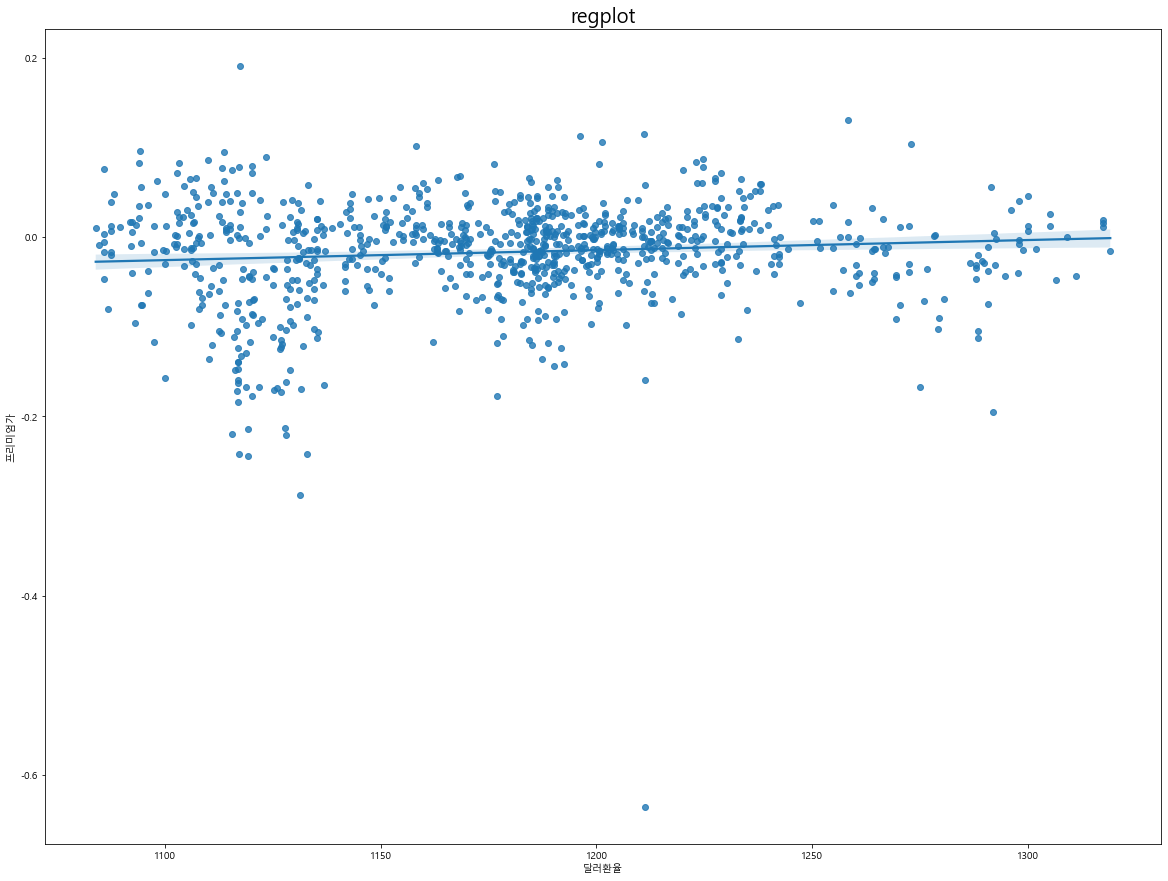

In [20]:
plt.figure(figsize=(20, 15))
plt.title('regplot', fontsize=20)
sns.regplot(x = '달러환율', y = '프리미엄가', data = df) # 단순 선형회귀 리그레션값을 바로 보여줌.
plt.show()

In [21]:
 
from statsmodels.formula.api import ols
fit = ols('프리미엄가 ~ 달러환율',data=df).fit() ## 단순선형회귀모형 적합
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  프리미엄가   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     9.258
Date:                Wed, 22 Mar 2023   Prob (F-statistic):            0.00241
Time:                        17:53:33   Log-Likelihood:                 1339.7
No. Observations:                 928   AIC:                            -2675.
Df Residuals:                     926   BIC:                            -2666.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1489      0.043     -3.431      0.001      -0.234      -0.064
달러환율           0.0001   3.68e-05      3.043      0.002    3.97e-05       0.000
==============================================================================
Omnibus:                      521.424   Durbin-Watson:                   1.102
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10976.155
Skew:                          -2.113   Prob(JB):                         0.00
Kurtosis:                      19.310   Cond. No.                     2.73e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.73e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

C:\Users\Happy\AppData\Local\Temp\ipykernel_8844\710028032.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df1 = data.corr()
C:\Users\Happy\AppData\Local\Temp\ipykernel_8844\710028032.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df1, dtype=np.bool)


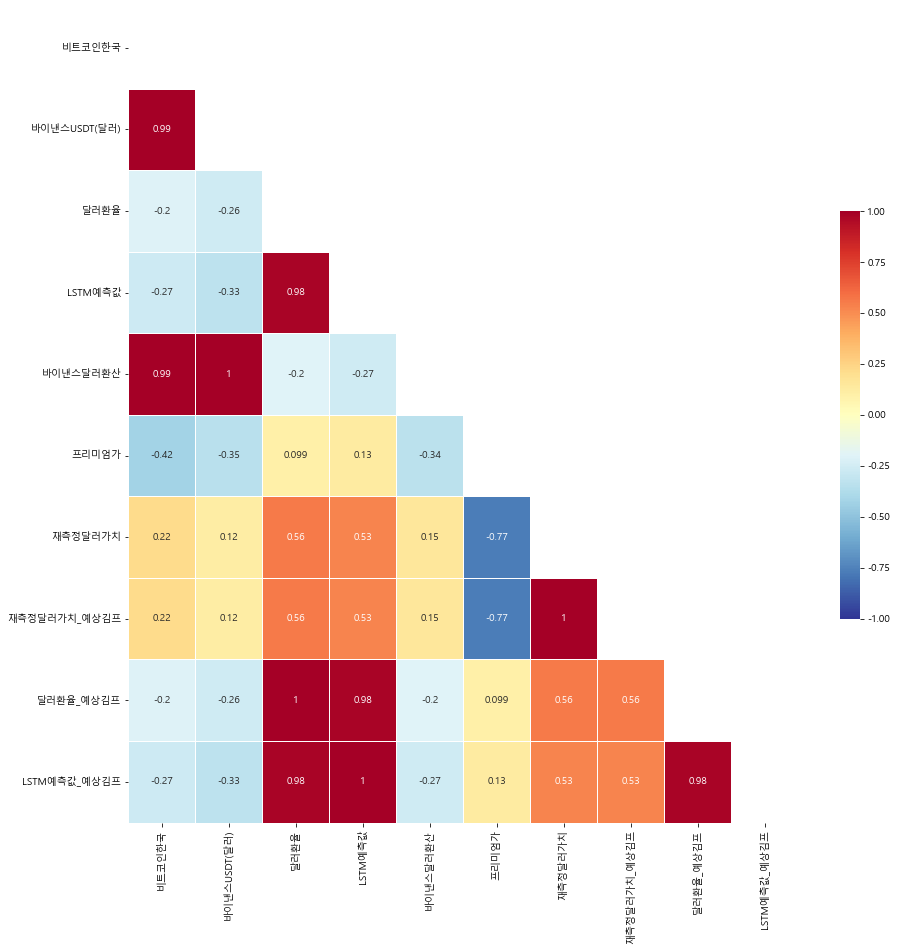

In [22]:



# sns.clustermap(data.corr(), 
#                annot = True,      # 실제 값 화면에 나타내기
#                cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
#                vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
#               )
df1 = data.corr()
# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(15,15) )

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(df1, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(df1, 
            cmap = 'RdYlBu_r', 
            annot = True,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

## 수익율 측정

In [32]:
import pandas as pd

In [41]:
data = pd.read_csv("data.csv",encoding = "utf-8")
# del data["Unnamed: 0"]

In [43]:
data

,날짜,비트코인한국,바이낸스USDT(달러),달러환율,날짜_2,LSTM예측값,바이낸스달러환산,프리미엄가,재측정달러가치,재측정달러가치_예상김프,달러환율_예상김프,LSTM예측값_예상김프
0,2017-09-26,4201000.0,3928.00,1134.80,2017-09-26 09:00:00,1129.182739,4.457494e+06,0.057542,1069.501018,-0.051642,-0.029256,-0.031182
1,2017-09-27,4317000.0,3882.36,1137.62,2017-09-27 09:00:00,1128.473267,4.416650e+06,0.022562,1111.952524,-0.037089,-0.028289,-0.031425
2,2017-09-28,4322000.0,4192.11,1145.75,2017-09-28 09:00:00,1127.876953,4.803110e+06,0.100166,1030.984397,-0.064847,-0.025502,-0.031629
3,2017-09-29,4657000.0,4178.98,1146.59,2017-09-29 09:00:00,1127.299927,4.791577e+06,0.028086,1114.386764,-0.036254,-0.025214,-0.031827
4,2017-09-30,4586000.0,4175.00,1146.59,2017-09-30 09:00:00,1126.810303,4.787013e+06,0.041991,1098.443114,-0.041720,-0.025214,-0.031995
...,...,...,...,...,...,...,...,...,...,...,...,...
1743,2022-07-14,25723000.0,20234.87,1305.10,2022-07-14 09:00:00,1293.320923,2.640853e+07,0.025959,1271.221411,0.017513,0.029127,0.025089
1744,2022-07-15,26604000.0,20588.84,1317.57,2022-07-15 09:00:00,1294.346924,2.712724e+07,0.019288,1292.156333,0.024690,0.033402,0.025441
1745,2022-07-16,27140000.0,20830.04,1317.57,2022-07-16 09:00:00,1296.176025,2.744504e+07,0.011114,1302.925967,0.028382,0.033402,0.026068
1746,2022-07-17,27496000.0,21195.60,1317.57,2022-07-17 09:00:00,1298.019409,2.792669e+07,0.015422,1297.250373,0.026436,0.033402,0.026700


In [44]:
# 9시인것을 다 뺴버려서 다시 맞추어줌.
data["날짜_2"] = [str(data["날짜"][i])[:]+" 09:00" for i in range(len(data["날짜"]))]
# 9시인것을 다 뺴버려서 다시 맞추어줌.
# data["날짜_2"] = [str(data["날짜"][i])[:-8]+"09:00" for i in range(len(data["날짜"]))]

In [45]:



data["날짜_2"] = pd.to_datetime(data['날짜_2'], format='%Y-%m-%d %H:%M', errors='raise')

# 서버 점검일 or 비트코인 전송 불가일
up_sutdown = [("2018-04-16 20:00", "2018-04-17 00:00"),
            ("2018-04-24 07:59", "2018-04-24 08:30"),
            ("2018-06-15 04:00", "2018-06-15 05:00"),
            ("2018-08-22 02:00", "2018-08-22 07:00"),
            ("2018-10-18 02:00", "2018-10-18 03:00"),
            ("2018-12-05 03:00", "2018-12-05 04:00"),
            ("2018-12-12 03:00", "2018-12-12 04:00"),
            ("2019-01-01 01:00", "2019-01-01 03:00"),
            ("2019-03-20 02:00", "2019-03-20 06:00"),
            ("2019-03-24 03:00", "2019-03-24 04:00"),
            ("2020-01-31 02:00", "2020-01-31 05:00"),
            ("2021-01-07 05:00", "2021-01-07 06:00"),
            ("2021-03-03 03:30", "2021-03-03 06:30"),
            ("2021-03-14 03:00", "2021-03-14 06:00"),
            ("2021-03-23 03:00", "2021-03-23 06:00"),
            ("2021-06-30 23:00", "2021-07-01 03:00"),
            ("2019-10-17 21:00", "2019-10-18 13:00"),
            ("2019-04-10 21:50", "2019-04-17 02:00"),
            ("2019-12-12 23:55", "2019-12-13 03:00"),
            ("2019-12-15 00:00", "2019-12-15 01:00"),
            ("2020-12-29 01:30", "2020-12-29 02:25"),
            ("2020-12-30 19:01", "2021-01-01 05:02"),
            ("2021-06-29 21:01", "2021-07-01 04:51"),
            ("2001-01-02" , "2018-04-10"), # trian 기간 제외
            ("2022-07-19" , "2022-08-02") # LSTM데이터 셋과 타임테이블 맞춤
             ]
# 서버 점검일이 아닌 날짜만 받기
for i in range(len(up_sutdown)):
    data = data.loc[~(data["날짜_2"].between(up_sutdown[i][0],up_sutdown[i][1]))]


In [46]:
Measure_Usdt =  1

seed = 1000000
up_fee = 0.0005
bin_fee = 0.0001
send_fee = 0.0009

up_to_bin_pre = 0.01
bin_to_up_pre = 0.15


data["바이낸스달러환산"] = data["달러환율"] * data["바이낸스USDT(달러)"]
data["프리미엄가"] = (1- data["비트코인한국"] / data["바이낸스달러환산"])
data["재측정달러가치"] = ((Measure_Usdt / data['바이낸스USDT(달러)']) *data['비트코인한국']) / Measure_Usdt


info = {"state": False, "enter_price": 0, "enter_time": None, "exit_price": 0, "ror": 1, "fiat_money": seed}
info_dataFrame = pd.DataFrame(info, index=[0])

data = data.reset_index(drop = True)

In [47]:
# 기간에 따른 수익율 재측정.
data = data.loc[(data["날짜"].between("2020-01-01","2024-01-01"))].reset_index(drop = True) # 위에서 정의됨
data

,날짜,비트코인한국,바이낸스USDT(달러),달러환율,날짜_2,LSTM예측값,바이낸스달러환산,프리미엄가,재측정달러가치,재측정달러가치_예상김프,달러환율_예상김프,LSTM예측값_예상김프
0,2020-01-01,8343000.0,7195.24,1155.07,2020-01-01 09:00:00,1155.874268,8.311006e+06,-0.003850,1159.516569,-0.020783,-0.022307,-0.022031
1,2020-01-02,8308000.0,7200.77,1155.02,2020-01-02 09:00:00,1155.259033,8.317033e+06,0.001086,1153.765500,-0.022754,-0.022324,-0.022242
2,2020-01-03,8300000.0,6965.49,1157.94,2020-01-03 09:00:00,1154.965576,8.065619e+06,-0.029059,1191.588819,-0.009787,-0.021323,-0.022343
3,2020-01-04,8038000.0,7345.00,1157.94,2020-01-04 09:00:00,1155.024292,8.505069e+06,0.054917,1094.349898,-0.043123,-0.021323,-0.022323
4,2020-01-05,8476000.0,7354.19,1157.94,2020-01-05 09:00:00,1155.293823,8.515711e+06,0.004663,1152.540253,-0.023174,-0.021323,-0.022230
...,...,...,...,...,...,...,...,...,...,...,...,...
923,2022-07-14,25723000.0,20234.87,1305.10,2022-07-14 09:00:00,1293.320923,2.640853e+07,0.025959,1271.221411,0.017513,0.029127,0.025089
924,2022-07-15,26604000.0,20588.84,1317.57,2022-07-15 09:00:00,1294.346924,2.712724e+07,0.019288,1292.156333,0.024690,0.033402,0.025441
925,2022-07-16,27140000.0,20830.04,1317.57,2022-07-16 09:00:00,1296.176025,2.744504e+07,0.011114,1302.925967,0.028382,0.033402,0.026068
926,2022-07-17,27496000.0,21195.60,1317.57,2022-07-17 09:00:00,1298.019409,2.792669e+07,0.015422,1297.250373,0.026436,0.033402,0.026700


In [48]:
# # 용어정리
# # 프리미엄가 == 김프 
# # 예상김프 == 단순선형회귀 예측 김프
# i = 0
# data["달러환율"][i] , data["재측정달러가치"][i],data["재측정달러가치_예상김프"][i] , data["달러환율_예상김프"][i] , data["프리미엄가"][i] 
# if (info['state'] == False) and (data["프리미엄가"][i] > data["달러환율_예상김프"][i]):
# if (info['state'] == False) and (data["프리미엄가"][i] > data["재측정달러가치_예상김프"][i]):

In [49]:
info

{'state': False,
 'enter_price': 0,
 'enter_time': None,
 'exit_price': 0,
 'ror': 1,
 'fiat_money': 1000000}

In [50]:
def fun_cheak_ror(data,seed,info_dataFrame,info):
    a = 1

    for i in range(len(data)):
        seed1 = seed

        # if (info['state'] == False) and (data["프리미엄가"][i] > data["달러환율_예상김프"][i]):
        if (info['state'] == False) and (data["프리미엄가"][i] > data["재측정달러가치_예상김프"][i]):
#         if ((data["LSTM예측값_예상김프"][i] - data["프리미엄가"][i])<0) and (info['state'] == False): # 475

#         현재 내 시드(원화/달러가치)가 전송 후 판매까지 완료한 달러가치보다 큰경우 => 내가 외국 거래소에서 환전 받을때 더 수익을 보는 경우.
#         if (float(seed / data['달러환율'][i]) <= (float((info["fiat_money"] / data['비트코인한국'][i] * (1 - up_fee)- send_fee) * data['바이낸스USDT(달러)'][i] * (1 - bin_fee) ))) and (info['state'] == False): # ror 525
        # 김프가 # 현재 내 시드(원화/달러가치)가 전송 후 판매까지 완료한 달러가치보다 큰경우
#         if (data["프리미엄가"][i] < up_to_bin_pre) and ((float(seed / data['달러환율'][i]) <= (float((info["fiat_money"] / data['비트코인한국'][i] * (1 - up_fee)- send_fee) * data['바이낸스USDT(달러)'][i] * (1 - bin_fee) ))) and (info['state'] == False)):

#         if ((data['프리미엄가'][i]) <= up_to_bin_pre) and (info['state'] == False):  # 프리미엄이 0보다 작고 포지션이 없다면
#         if ((data['프리미엄가'][i]) <= up_to_bin_pre) and (info['state'] == False) and (data["달러환율"][i] < data["재측정달러가치"][i]):  # 프리미엄이 0보다 작고 포지션이 없다면

#         if (info['state'] == False) and (data["달러환율"][i] > data["재측정달러가치"][i]):  # 환율보다 비공식 환율이 더 큰 경우

#         if (data["달러환율"][i] < data["LSTM예측값"][i]) and (info['state'] == False):
#         if (data["프리미엄가"][i] > data["LSTM예측값_예상김프"][i]) and (info['state'] == False) : # 역프일때 바로진입하지 않고 더 많은 수익을 볼 수 있군
        #         print("if문 통과 포지션 진입",data["프리미엄가"][i] , data["LSTM예측값_예상김프"][i])
            info["state"] = True  # 바이낸스로 차익봄
            info["enter_price"] = data['비트코인한국'][i]
            info["enter_time"] = data['날짜'][i]
            info["exit_price"] = data['바이낸스USDT(달러)'][i]
            info["비공식환율"] = data['재측정달러가치'][i]

            seed_usdt = float((info["fiat_money"] / data['비트코인한국'][i] * (1 - up_fee) - send_fee) * data['바이낸스USDT(달러)'][i] * (1 - bin_fee))  # 달러로 가질돈
            new_info_dataFrame = pd.DataFrame(info, index=[0])
            info_dataFrame = pd.concat([info_dataFrame, new_info_dataFrame], axis=0)  # 수익 데이터 저장
            a = 0
        #         info["ror"] = None


        #     if (((data['프리미엄가'][i]) >= bin_to_up_pre) and (info['state'] == True)):  # 프리미엄이 0보다 크고 포지션이 없다면
        elif  (a != 1) and((float(seed * (1 + bin_to_up_pre)) < (float(((seed_usdt  / data['바이낸스USDT(달러)'][i]) * (1 - bin_fee) - send_fee) * data['비트코인한국'][i] * (1 - up_fee)))))and (info['state'] == True):
    #         print("if문 통과 포지션 탈출",float(seed * (1 + bin_to_up_pre)) , (float(((seed_usdt  / data['바이낸스USDT(달러)'][i]) * (1 - bin_fee) - send_fee) * data['비트코인한국'][i] * (1 - up_fee))))
            info["state"] = False  # 업비트로 재전송
            info["enter_price"] = data['바이낸스USDT(달러)'][i]
            info["enter_time"] = data['날짜'][i]
            info["exit_price"] = data['비트코인한국'][i]
            info["비공식환율"] = data['재측정달러가치'][i]

            seed = info["fiat_money"] = float(((seed_usdt  / data['바이낸스USDT(달러)'][i]) * (1 - bin_fee) - send_fee) * data['비트코인한국'][i] * (1 - up_fee))
        #         print(info["fiat_money"])
            info["ror"] = seed / seed1
            new_info_dataFrame = pd.DataFrame(info, index=[0])
            info_dataFrame = pd.concat([info_dataFrame, new_info_dataFrame], axis=0)  # 수익 데이터 저장

    return info_dataFrame

In [51]:
# data = data.loc[~(abs(data["프리미엄가"])>0.1)].reset_index(drop = True)
a = 1
seed = 1000000
bin_to_up_pre = 0.01
info = {"state": False, "enter_price": 0, "enter_time": None, "exit_price": 0, "ror": 1, "fiat_money": seed, "비공식환율" : 0}
info_dataFrame = pd.DataFrame(info, index=[0])
info_dataFrame_ror = fun_cheak_ror(data,seed,info_dataFrame,info)

info_dataFrame = info_dataFrame_ror.reset_index(drop = True)
print("ror : ",(info_dataFrame["fiat_money"][len(info_dataFrame)-1])/(info_dataFrame["fiat_money"][0]))
info_dataFrame

ror :  550.4169045700711


,state,enter_price,enter_time,exit_price,ror,fiat_money,비공식환율
0,False,0.00,None,0.00,1.000000,1.000000e+06,0.000000
1,True,8343000.00,2020-01-01,7195.24,1.000000,1.000000e+06,1159.516569
2,False,6965.49,2020-01-03,8300000.00,1.011250,1.011250e+06,1191.588819
3,True,8038000.00,2020-01-04,7345.00,1.011250,1.011250e+06,1094.349898
4,False,7354.19,2020-01-05,8476000.00,1.036842,1.048506e+06,1152.540253
...,...,...,...,...,...,...,...
278,False,20175.84,2022-07-06,26399000.00,1.038912,5.194736e+08,1308.446142
279,True,26953000.00,2022-07-08,21624.99,1.038912,5.194736e+08,1246.382079
280,False,21594.75,2022-07-09,28129000.00,1.043742,5.421964e+08,1302.585119
281,True,25723000.00,2022-07-14,20234.87,1.043742,5.421964e+08,1271.221411


In [55]:
info_dataFrame.to_csv("info_dataFrame.csv",index = False)

In [56]:
import matplotlib.pyplot as plt

([<matplotlib.lines.Line2D at 0x1834e926fd0>],
 1.0460651736777387,
 0.010633492965186777,
 283)

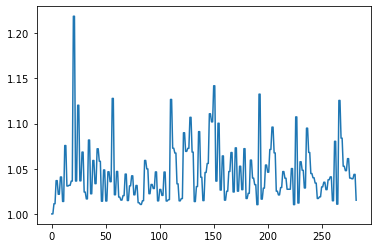

In [57]:
plt.plot(info_dataFrame["ror"]), info_dataFrame["ror"].mean(), sum( info_dataFrame["ror"]) / len(data)/30 , len(info_dataFrame)

In [58]:
data

,날짜,비트코인한국,바이낸스USDT(달러),달러환율,날짜_2,LSTM예측값,바이낸스달러환산,프리미엄가,재측정달러가치,재측정달러가치_예상김프,달러환율_예상김프,LSTM예측값_예상김프
0,2020-01-01,8343000.0,7195.24,1155.07,2020-01-01 09:00:00,1155.874268,8.311006e+06,-0.003850,1159.516569,-0.020783,-0.022307,-0.022031
1,2020-01-02,8308000.0,7200.77,1155.02,2020-01-02 09:00:00,1155.259033,8.317033e+06,0.001086,1153.765500,-0.022754,-0.022324,-0.022242
2,2020-01-03,8300000.0,6965.49,1157.94,2020-01-03 09:00:00,1154.965576,8.065619e+06,-0.029059,1191.588819,-0.009787,-0.021323,-0.022343
3,2020-01-04,8038000.0,7345.00,1157.94,2020-01-04 09:00:00,1155.024292,8.505069e+06,0.054917,1094.349898,-0.043123,-0.021323,-0.022323
4,2020-01-05,8476000.0,7354.19,1157.94,2020-01-05 09:00:00,1155.293823,8.515711e+06,0.004663,1152.540253,-0.023174,-0.021323,-0.022230
...,...,...,...,...,...,...,...,...,...,...,...,...
923,2022-07-14,25723000.0,20234.87,1305.10,2022-07-14 09:00:00,1293.320923,2.640853e+07,0.025959,1271.221411,0.017513,0.029127,0.025089
924,2022-07-15,26604000.0,20588.84,1317.57,2022-07-15 09:00:00,1294.346924,2.712724e+07,0.019288,1292.156333,0.024690,0.033402,0.025441
925,2022-07-16,27140000.0,20830.04,1317.57,2022-07-16 09:00:00,1296.176025,2.744504e+07,0.011114,1302.925967,0.028382,0.033402,0.026068
926,2022-07-17,27496000.0,21195.60,1317.57,2022-07-17 09:00:00,1298.019409,2.792669e+07,0.015422,1297.250373,0.026436,0.033402,0.026700
